In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
bc = '#FF4F39'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_parquet('drive/MyDrive/Personal/Datasets/sample_10_000_preprocessed.parquet')

In [ ]:
df.head()

msisdn  usage
2020-06-01    2860      0
2020-06-01    5126      0
2020-06-01    9047      0
2020-06-01    9900    114
2020-06-01    2406      0

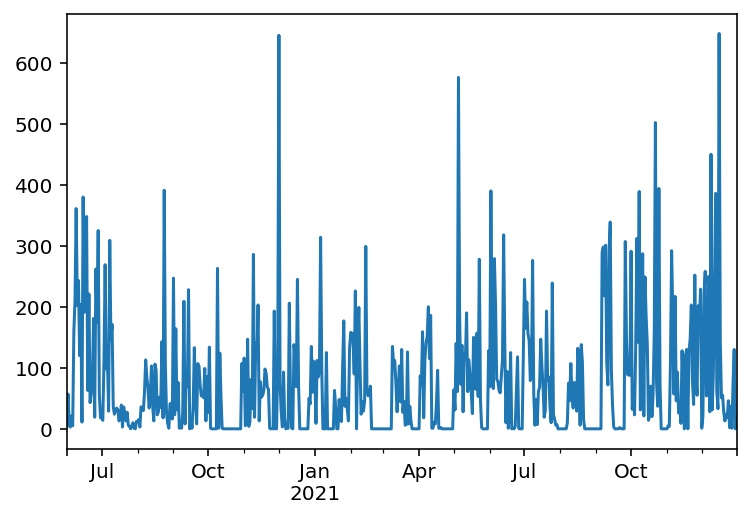

In [ ]:
sample_user = df[df.msisdn==6554]['usage']
ax = sample_user.plot.line()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

def plot_prophet_model(model,data,res):
  """
        model - fitted fbprophet model
        data - dataset used for training
        res - result dataset with y,yhat columns

  """
  _,ax = plt.subplots(4,1,figsize=(18,21))
  fitted_data = model.predict()
  fitted_data = fitted_data.set_index("ds")
  residuals = data - fitted_data['yhat']
  mean_res = np.mean(residuals)
  std_res = np.std(residuals)
  mape = MAPE(res['y'],res['yhat'])*100

  ax[0].set_title(f'Model performance\n MAPE:{mape:.3f}%',fontfamily='serif',fontweight='semibold',fontsize=18)
  ax[0].plot(fitted_data['yhat'],label='fitted data')
  ax[0].plot(fitted_data['trend'],label='trend',linestyle='--',color='red',alpha=0.6)
  ax[0].plot(data,label='actual data',color='black',alpha=0.5)
  ax[0].plot(res['y'],label='test',color='m',alpha=1,linestyle='--')
  ax[0].plot(res['yhat'],label='predictions',color='g',alpha=1,linewidth=4)
  ax[0].legend(loc='upper center',fontsize=18)

  plot_pacf(data,ax=ax[1])
  ax[1].set_title('Partial autocorrelation(Train)',fontfamily='serif',fontweight='semibold',fontsize=18)

  plot_pacf(residuals,ax=ax[2])
  ax[2].set_title('Partial autocorrelation(Residuals)',fontfamily='serif',fontweight='semibold',fontsize=18)


  ax[3].hist(residuals,color='blue',alpha=0.5)
  ax[3].set_title('Residual distribution',fontfamily='serif',fontweight='semibold',fontsize=18)

  plt.show()

In [ ]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window),fontfamily='serif',fontsize=18)
    plt.plot(rolling_mean, color='red',alpha=1, label="Rolling mean trend",linewidth=3)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "bo", markersize=10)

    plt.plot(series[window:],color='black',alpha=0.7,label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value),
            fontfamily='serif',fontsize=18
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())
    
def plotModelResults(
    model, X_train, X_test,y_train,y_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = MAPE(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset

    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data["weekday_average"] = list(
            map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
        )

        # drop encoded variables
        data.drop(["weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size
    )

    return X_train, X_test, y_train, y_test

# 01 predictions using default settings

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics

In [ ]:
prophet_data = sample_user.reset_index()
prophet_data.columns = ['ds','y']
prophet_data.head()

ds   y
0 2020-06-01   4
1 2020-06-02  57
2 2020-06-03   8
3 2020-06-04   3
4 2020-06-05  21

In [ ]:
def get_model():
  return Prophet(daily_seasonality=False,yearly_seasonality=True)

def get_rain_test(data):
  test = data[data.ds>='2021-12-01']
  train = data.loc[data.ds<'2021-12-01',:]
  return train,test

def fit(data,plot_model=True):
  train,test = get_rain_test(data)
  model = get_model()
  model.fit(train)
  preds = model.predict(test)
  train = train.set_index('ds')
  res_df = pd.DataFrame(index=test.ds)
  res_df['yhat'] = preds['yhat'].values.tolist()
  res_df['y'] = test['y'].values.tolist()
  if plot_model:plot_prophet_model(model,train['y'],res_df)
  return model,train['y'],res_df

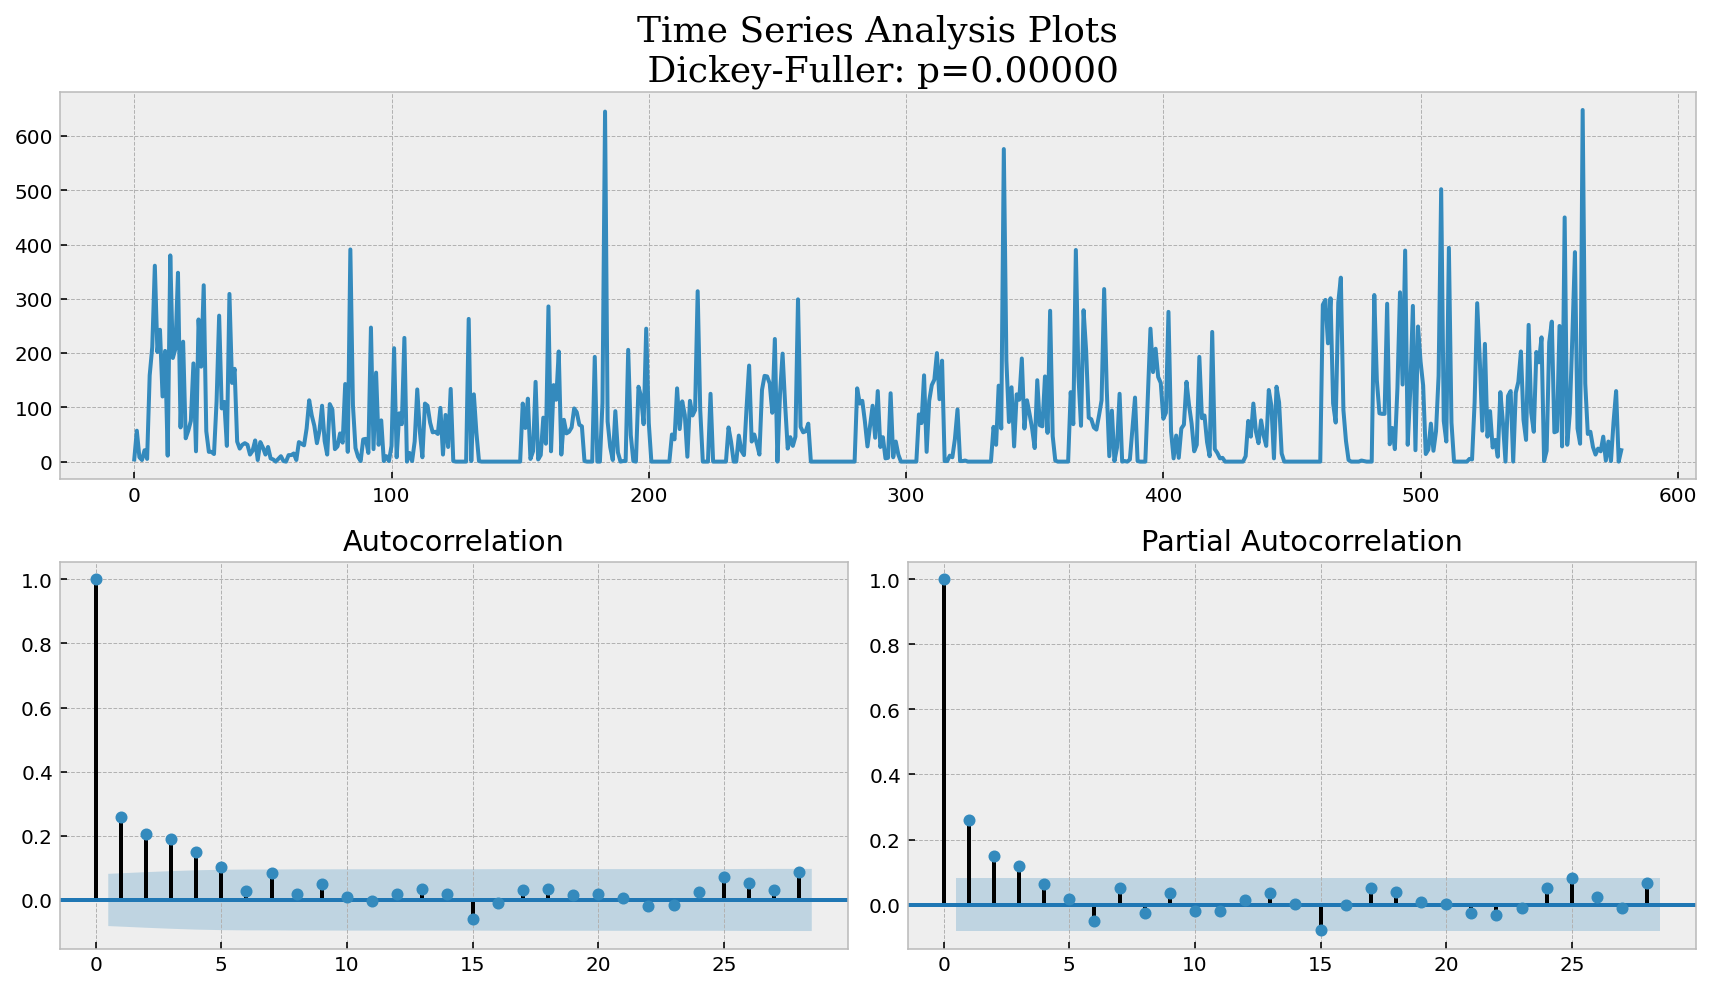

In [ ]:
tsplot(prophet_data['y'])

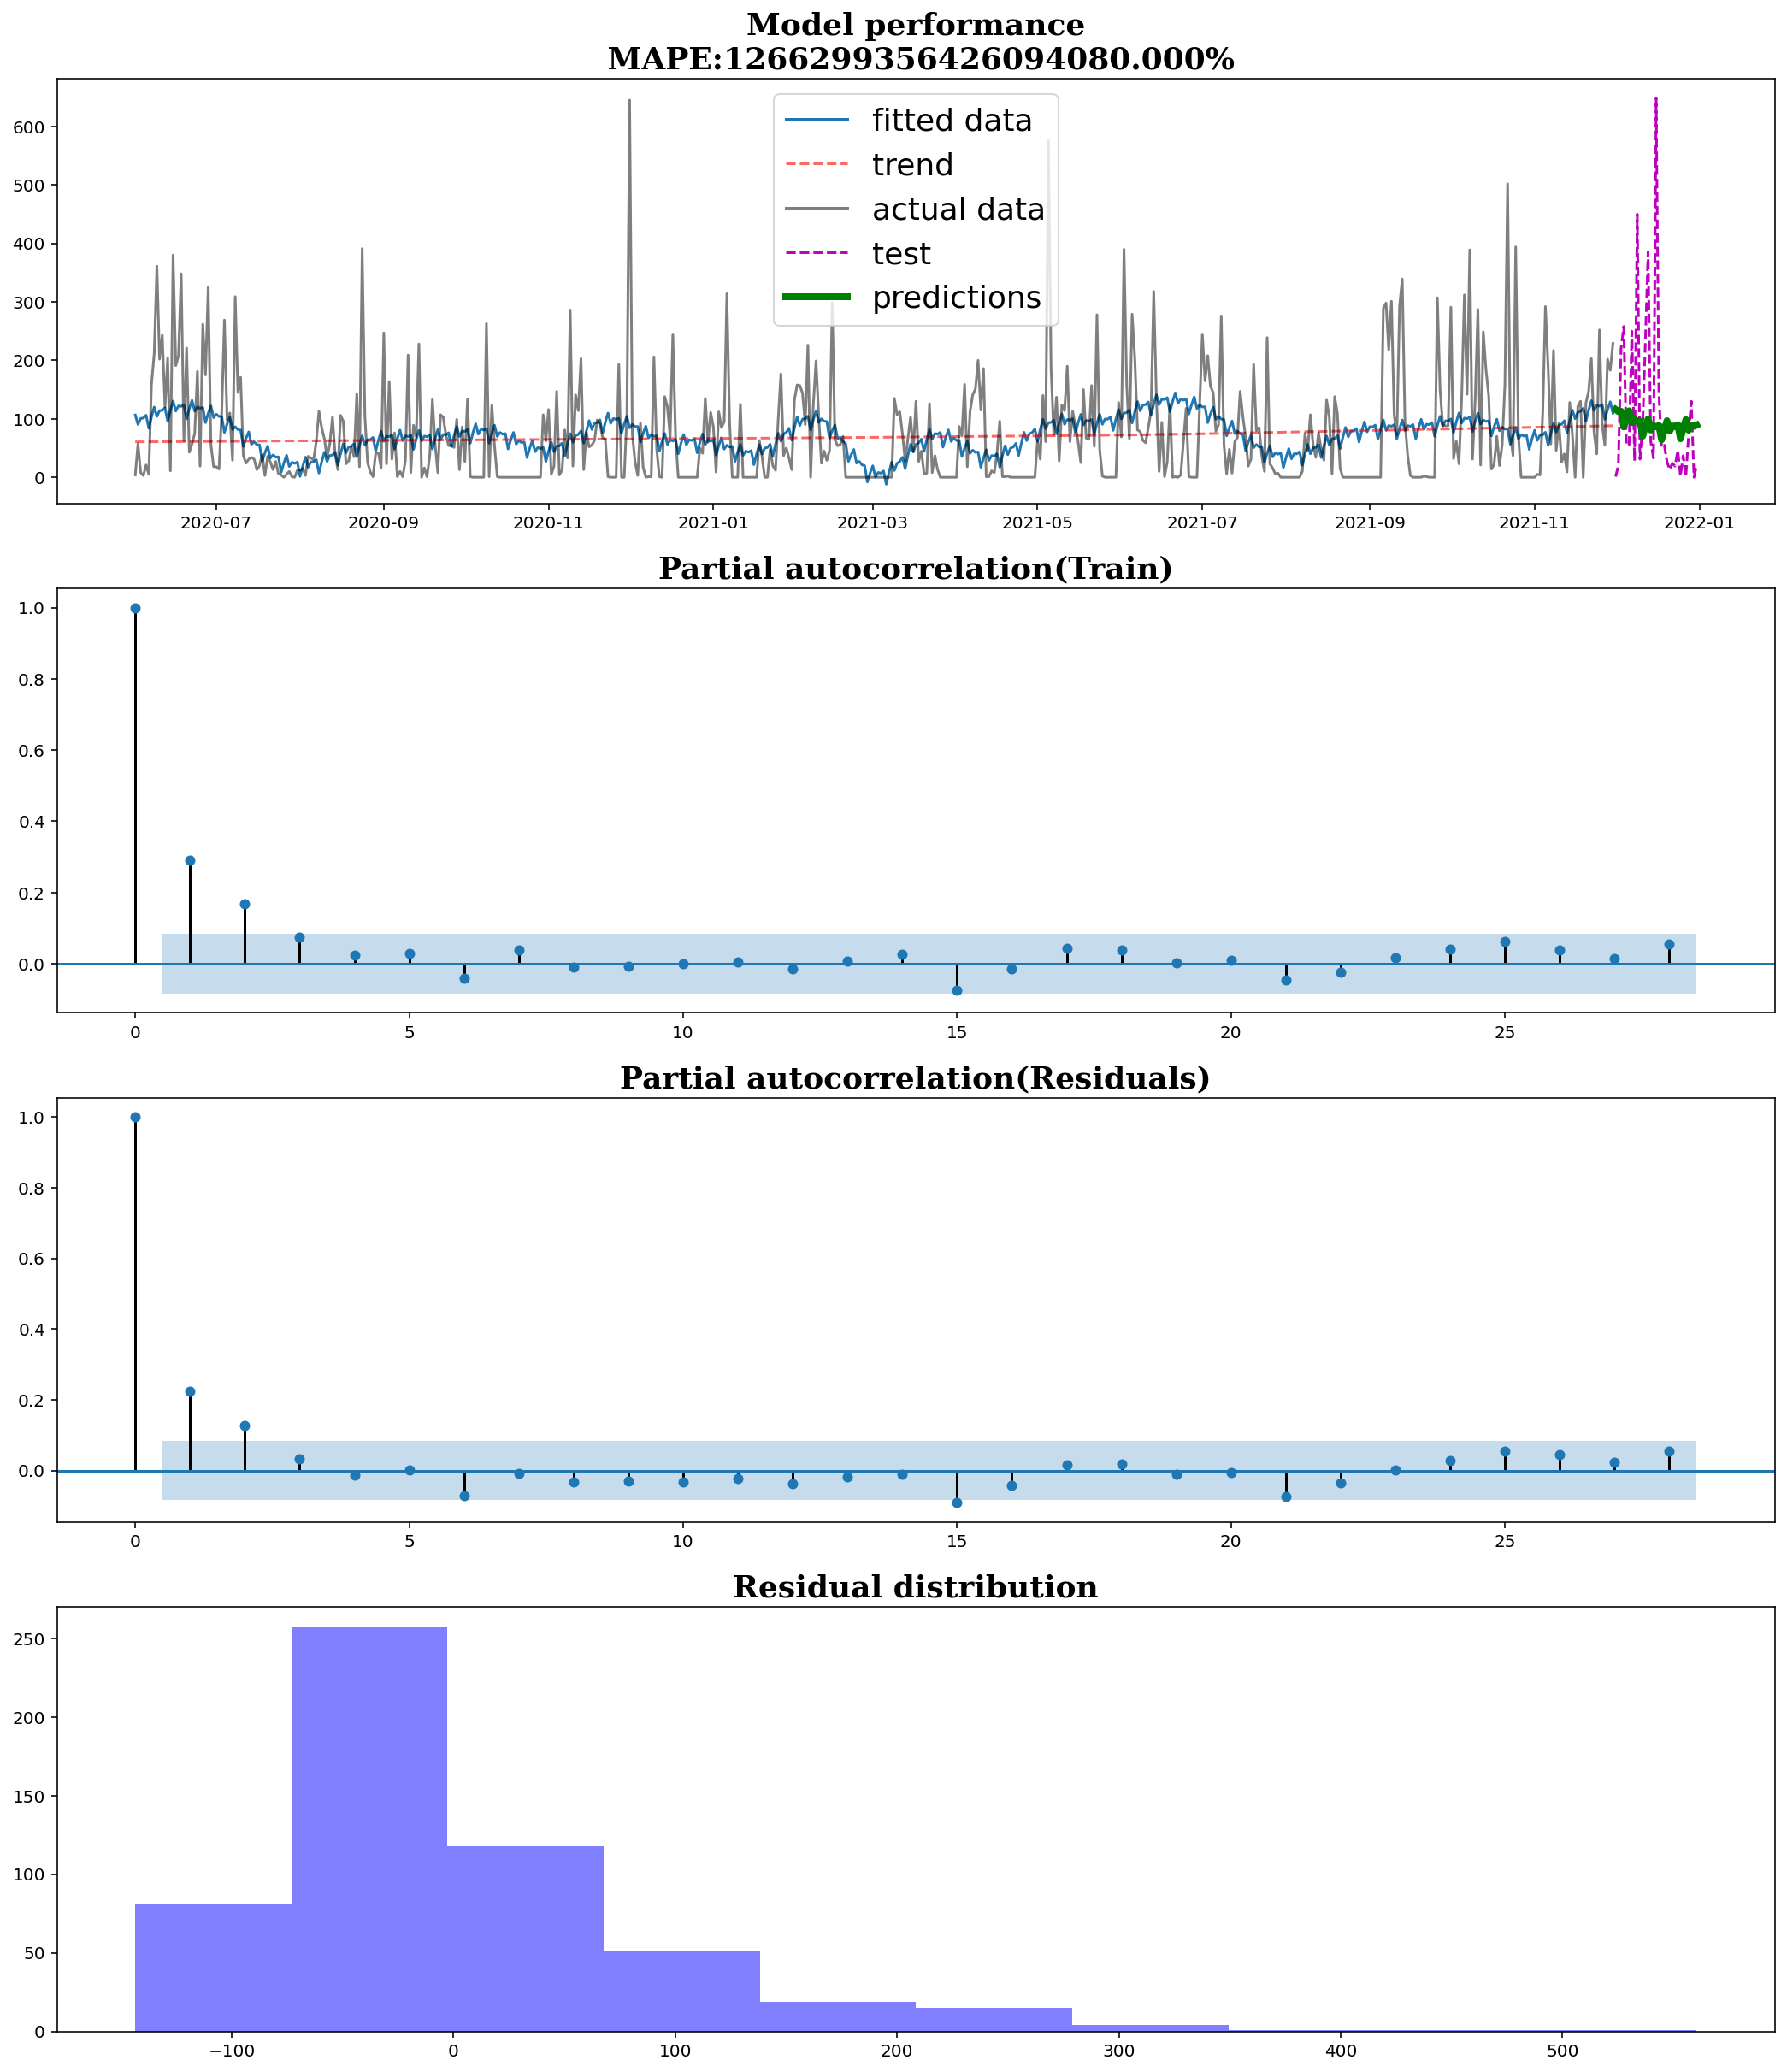

In [ ]:
model,y,res_df = fit(prophet_data)

# 02 predictions using denoiced data - STE

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decomp = seasonal_decompose(prophet_data.set_index('ds'))

In [ ]:
denoiced_data = prophet_data.copy()
denoiced = denoiced_data['y'].values - decomp.resid.y.values
denoiced_data['y'] = denoiced

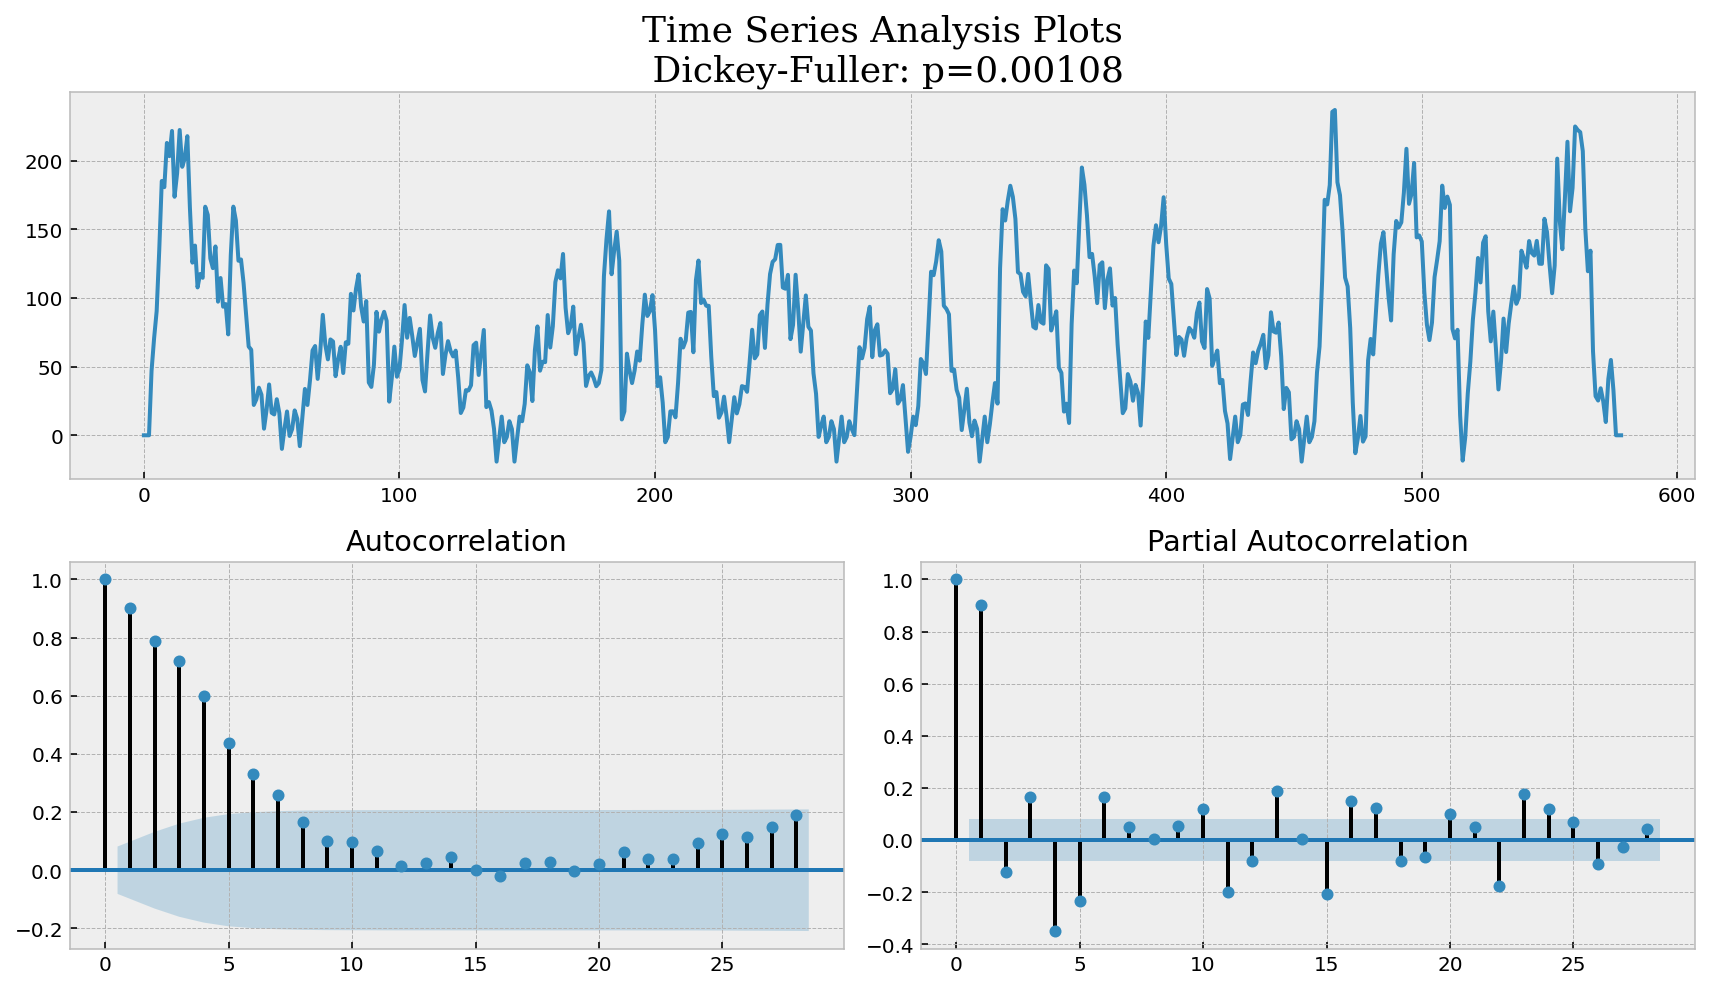

In [ ]:
tsplot(denoiced_data['y'].fillna(0))

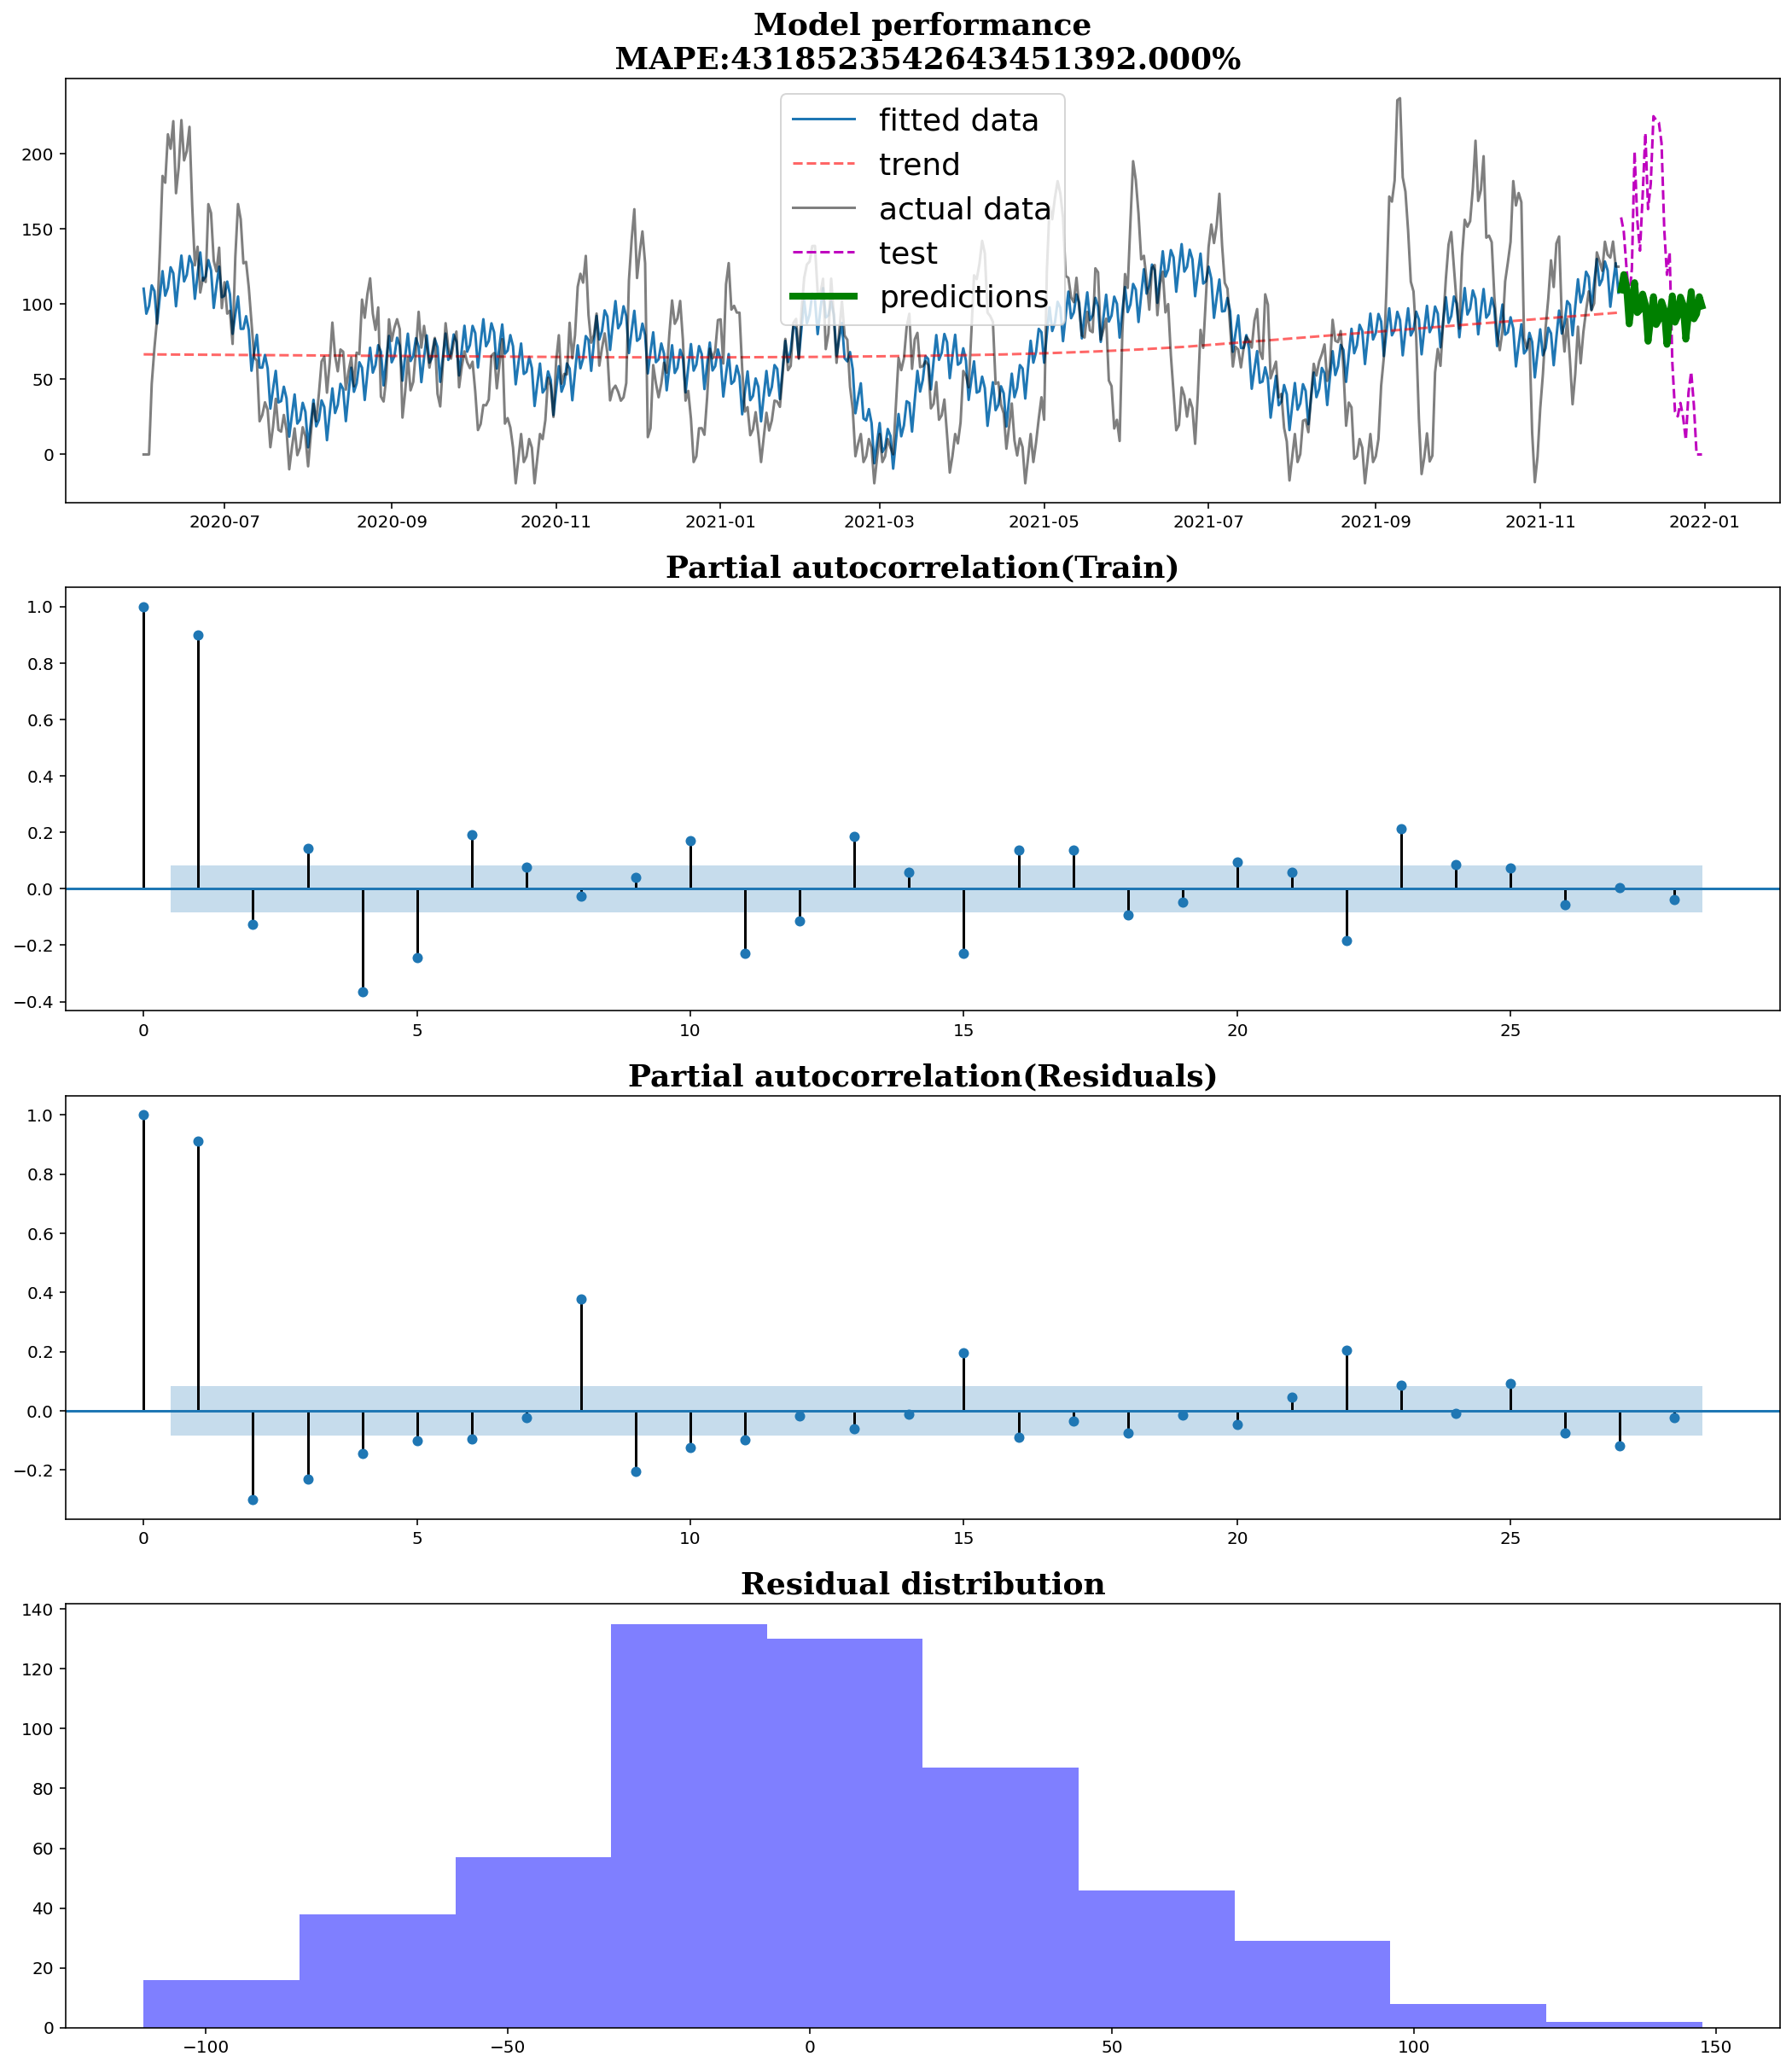

In [ ]:
model,y,res_df = fit(denoiced_data.fillna(0))

# 03 predictions using smoothed data

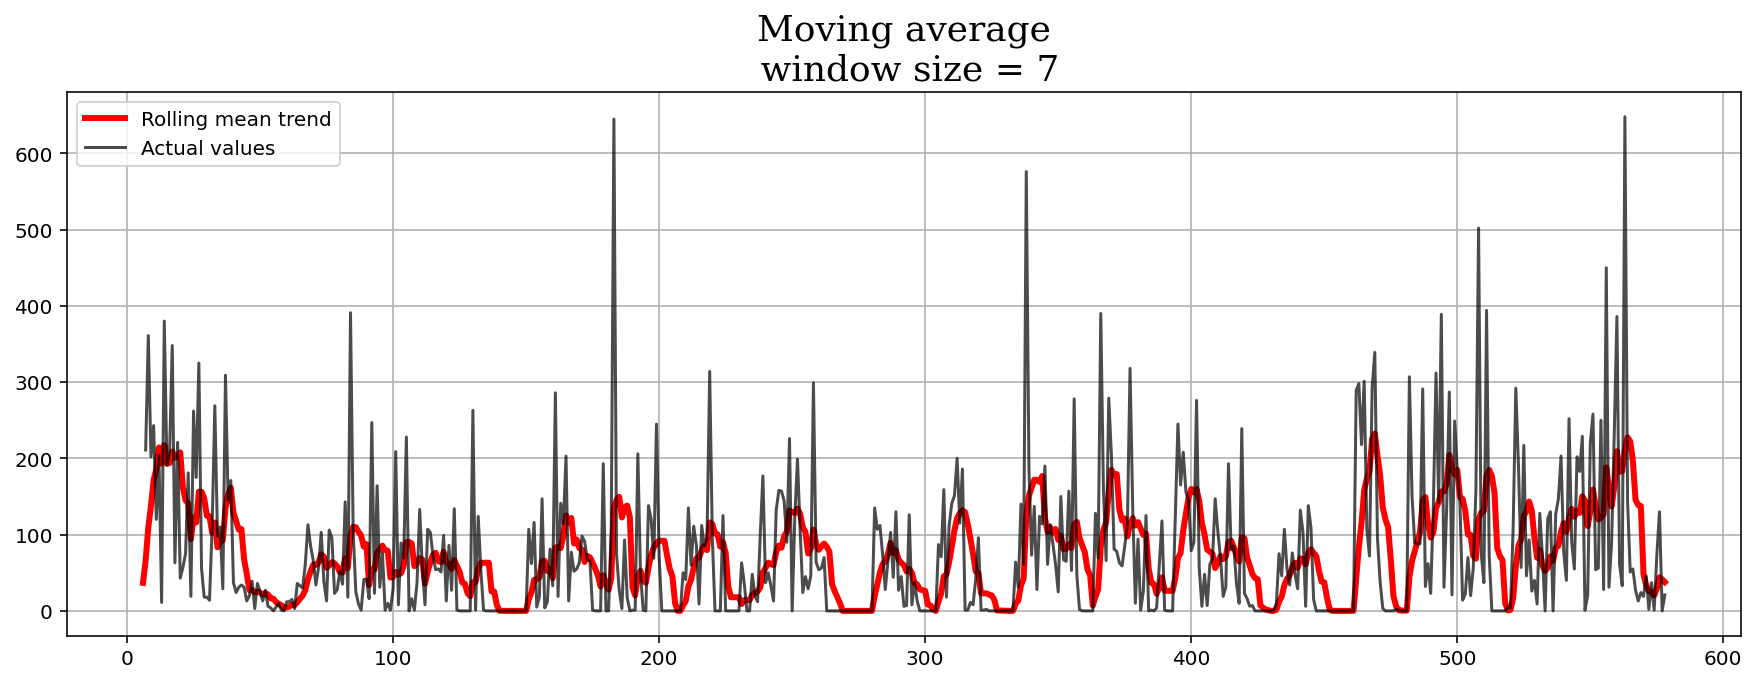

In [ ]:
plotMovingAverage(prophet_data['y'],window=7)

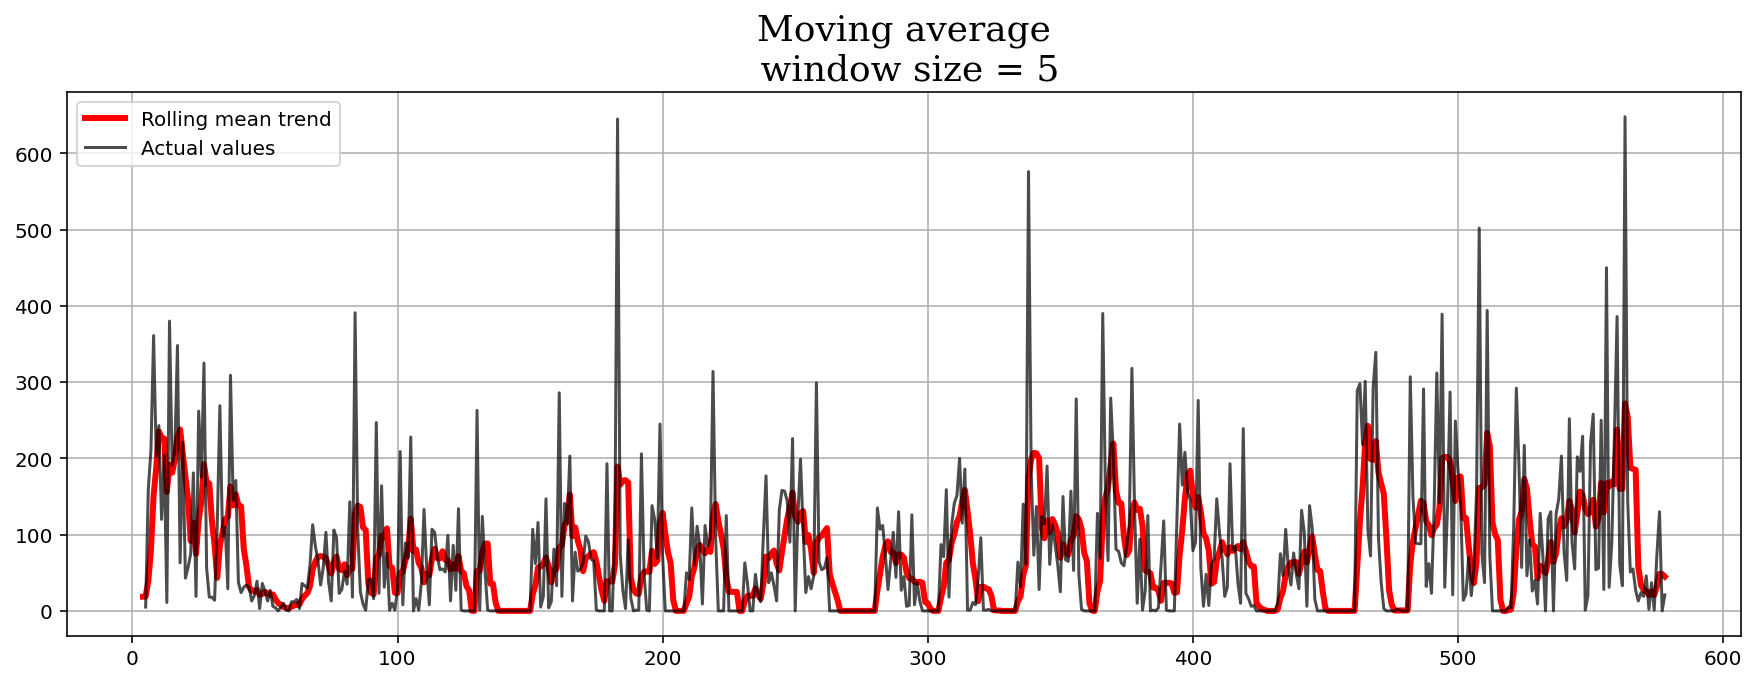

In [ ]:
plotMovingAverage(prophet_data['y'],window=5)

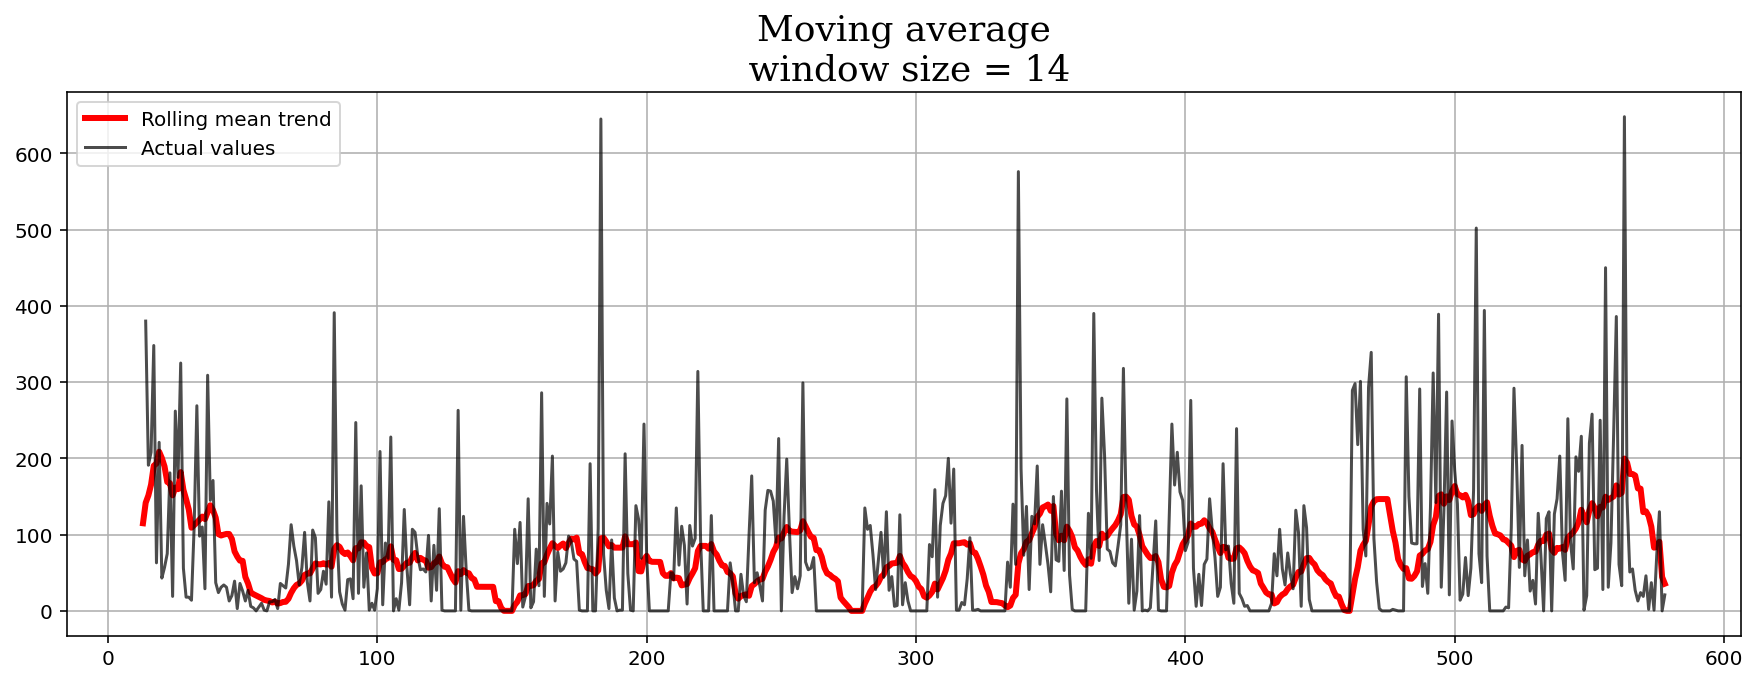

In [ ]:
plotMovingAverage(prophet_data['y'],window=14)

In [ ]:
moving_average = prophet_data.copy()
ma = prophet_data.y.rolling(7).mean().values
moving_average['y'] =  ma
moving_average.sample(5)

ds           y
485 2021-09-29   90.571429
391 2021-06-27   26.428571
552 2021-12-05  137.857143
152 2020-10-31   24.142857
484 2021-09-28   78.142857

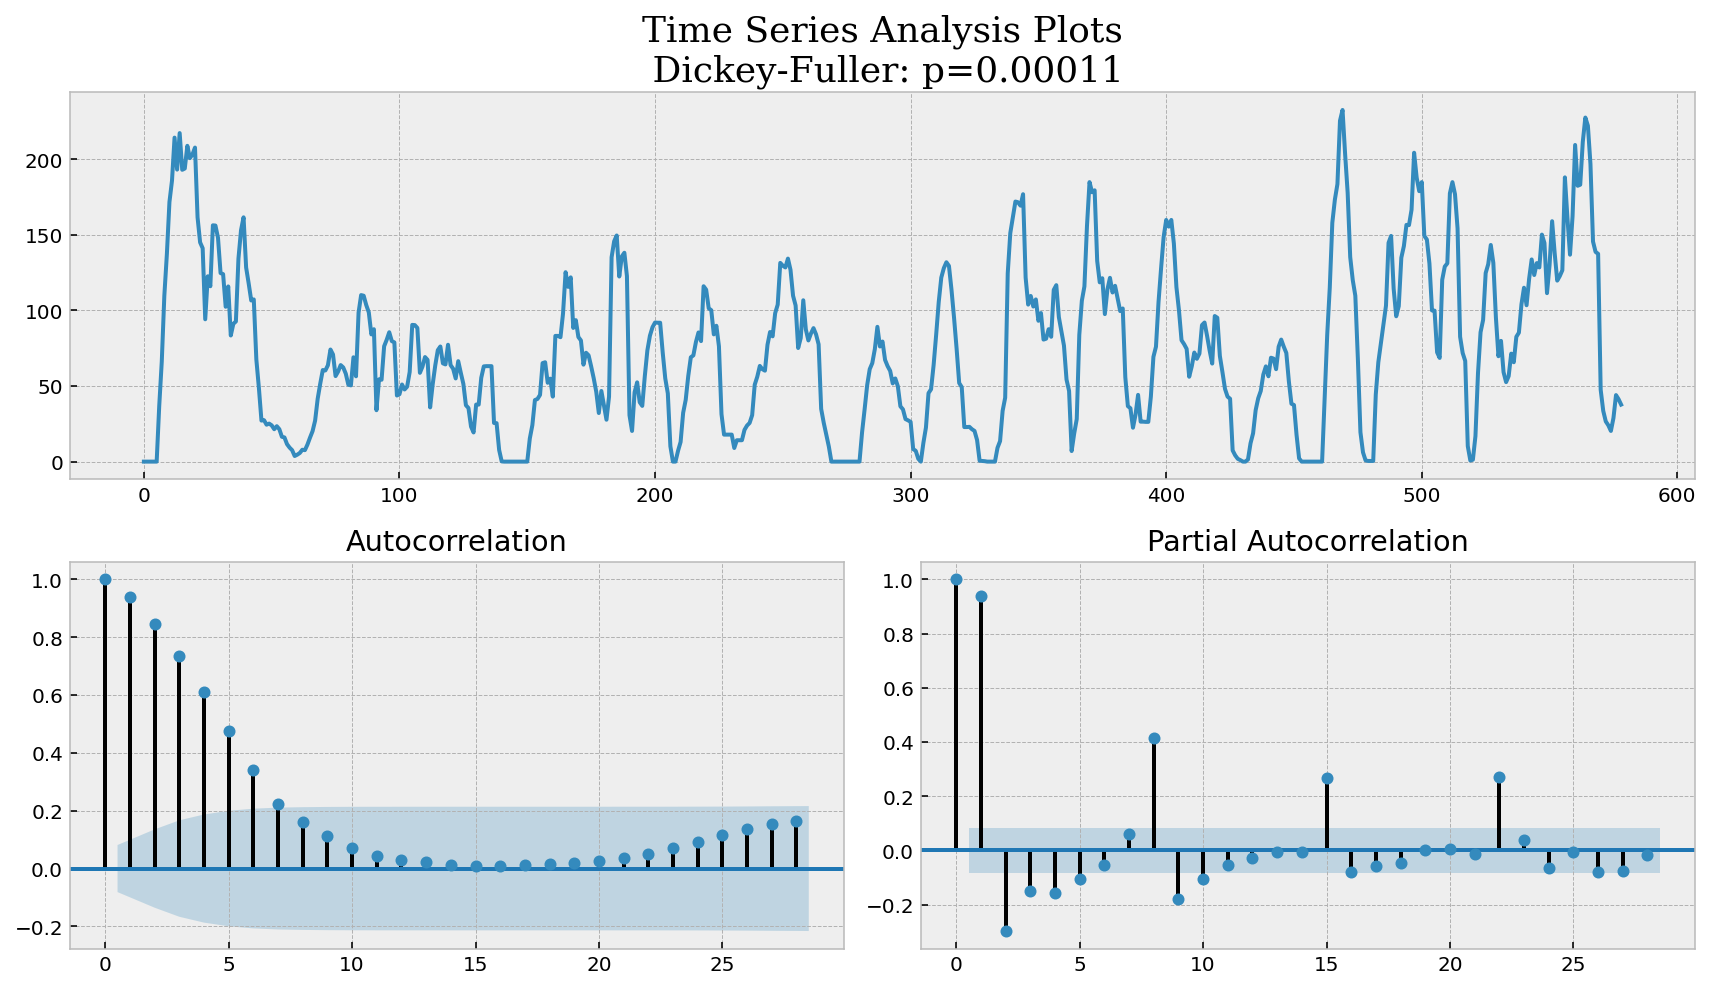

In [ ]:
tsplot(moving_average['y'].fillna(0))

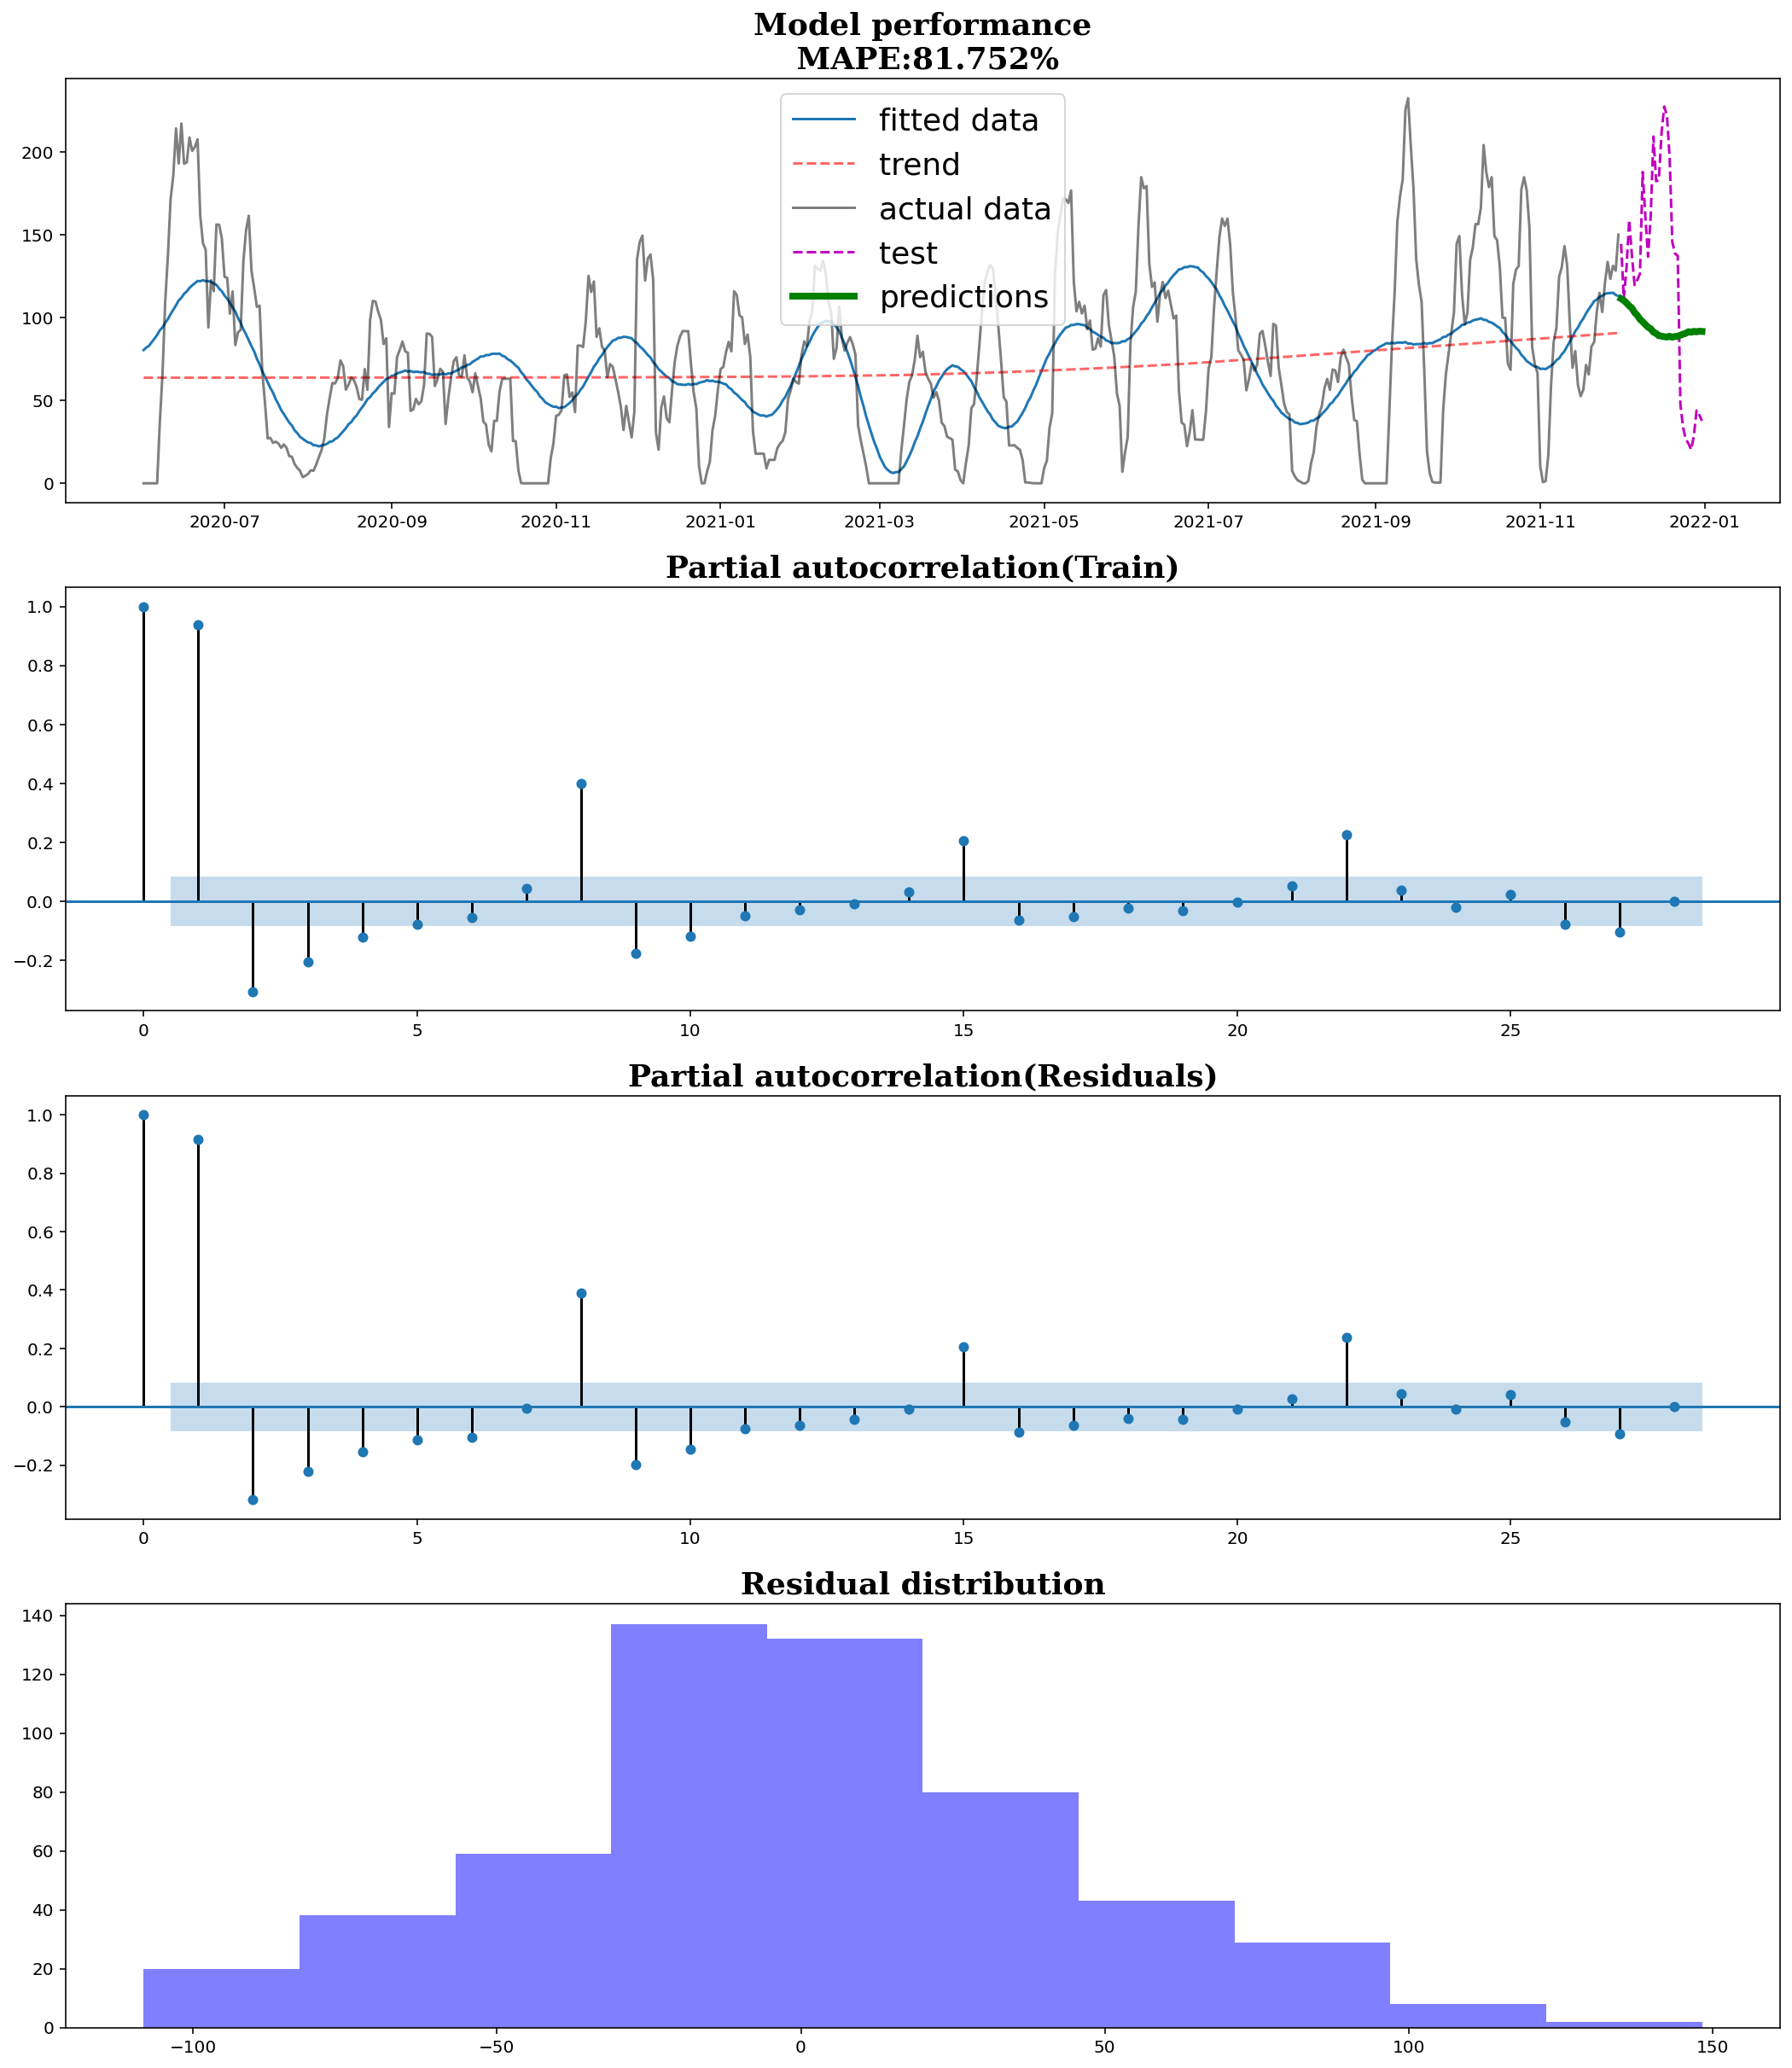

In [ ]:
model,y,res_df = fit(moving_average.fillna(0))

# 04 predictions using denoiced data + predicted residuals

In [ ]:
y = y.reset_index()
y.columns = ['ds','y']
y.head()

ds    y
0 2020-06-01  0.0
1 2020-06-02  0.0
2 2020-06-03  0.0
3 2020-06-04  0.0
4 2020-06-05  0.0

In [ ]:
yhat = model.predict(y)['yhat']
residuals = y['y'] - yhat

## Fitting SARIMA Model

In [ ]:
from itertools import product 
import scipy.stats as scs
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize 
from tqdm.notebook import tqdm

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    if not isinstance(series,pd.Series):
      # print("fu")
      series = pd.Series(series)
    data = series.copy()
    # print(data)
    data = pd.DataFrame()
    data['actual'] = series.values
    data["arima_model"] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data["arima_model"][: s + d] = np.NaN
    print(data)

    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    print("breask")
    error = MAPE(
        data['actual'][s + d :], data["arima_model"][s + d :]
    )
    print("breask")
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color="r", label="model")
    # plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color="lightgrey")
    plt.plot(data, label="actual")
    plt.legend()
    plt.grid(True)

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                residuals,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24  # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 26min 10s, sys: 18min 15s, total: 44min 26s
Wall time: 22min 40s


In [ ]:
result_table['aic'].min()

4427.813900013029

In [ ]:
result_table[result_table['aic']==result_table['aic'].min()]

parameters        aic
0  (4, 4, 0, 1)  4427.8139

In [ ]:
params = (4, 4, 0, 1)

In [ ]:
p, q, P, Q = params

best_model = sm.tsa.statespace.SARIMAX(
    residuals, order=(p, d, q), seasonal_order=(P, D, Q, s)
).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  548
Model:             SARIMAX(4, 1, 4)x(0, 1, 1, 24)   Log Likelihood               -2203.907
Date:                            Mon, 25 Apr 2022   AIC                           4427.814
Time:                                    17:24:47   BIC                           4470.410
Sample:                                         0   HQIC                          4444.496
                                            - 548                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3673      0.044     -8.419      0.000      -0.453      -0.282
ar.L2          0.4387      0.044   

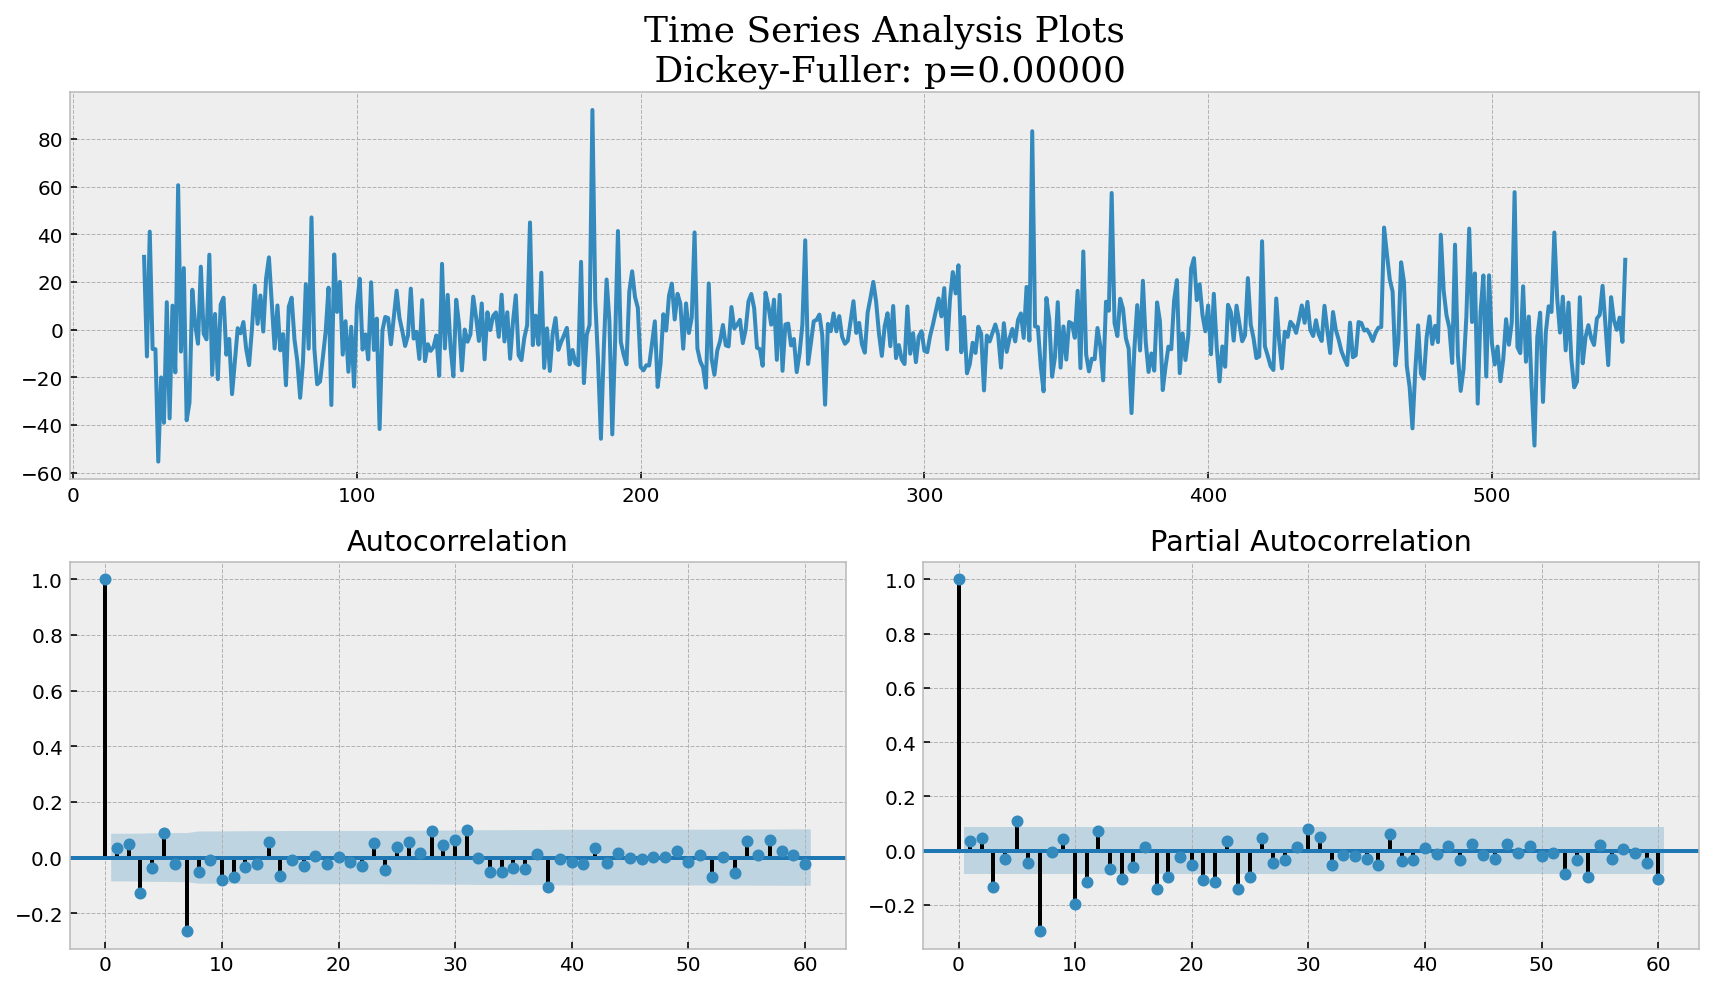

In [ ]:
tsplot(best_model.resid[24 + 1 :], lags=60)

        actual  arima_model
0   -80.462720          NaN
1   -82.000771          NaN
2   -83.060540          NaN
3   -85.241904          NaN
4   -87.317097          NaN
..         ...          ...
543  18.902123    15.009531
544   8.537487     8.616225
545  16.187619    11.143884
546  14.686973    19.817166
547  37.049925     7.736304

[548 rows x 2 columns]
breask
breask


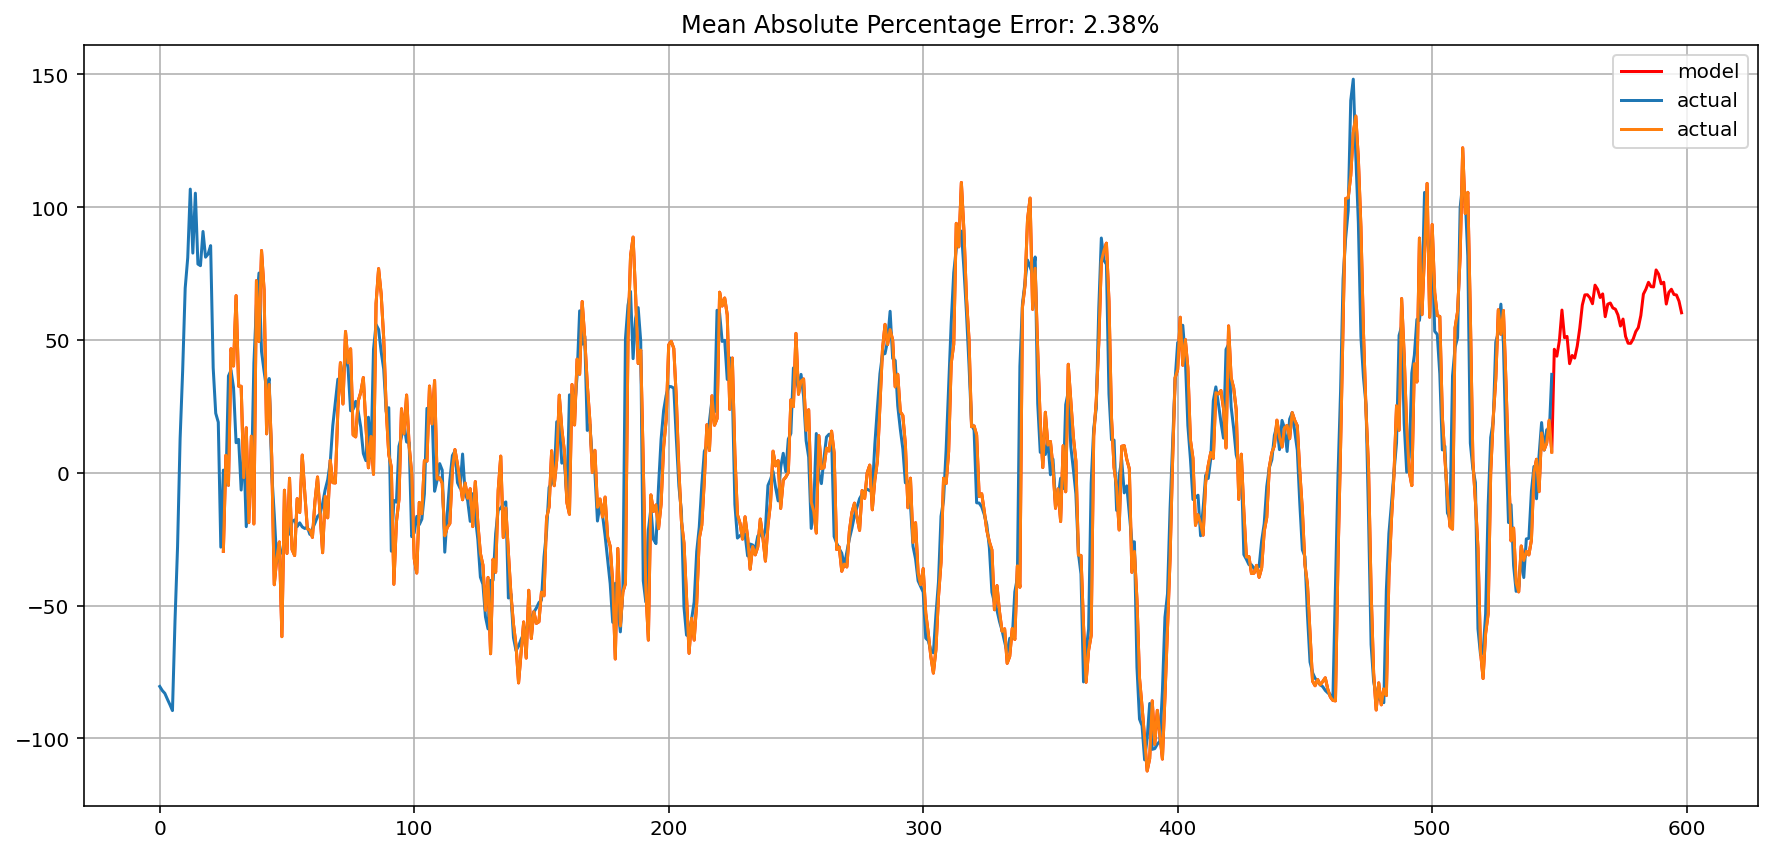

In [ ]:
plotSARIMA(residuals, best_model, 50)

In [ ]:
month_preds = best_model.predict(start=residuals.shape[0], end=residuals.shape[0] + 30)

In [ ]:
res_df['final_preds'] = month_preds.values + res_df['yhat']
res_df.head()

yhat           y  final_preds
ds                                             
2021-12-01  111.436401  144.571429   157.936212
2021-12-02  110.424559  111.428571   154.326242
2021-12-03  108.891241  130.000000   158.679853
2021-12-04  107.174087  159.000000   168.440476
2021-12-05  105.810183  137.857143   156.681608

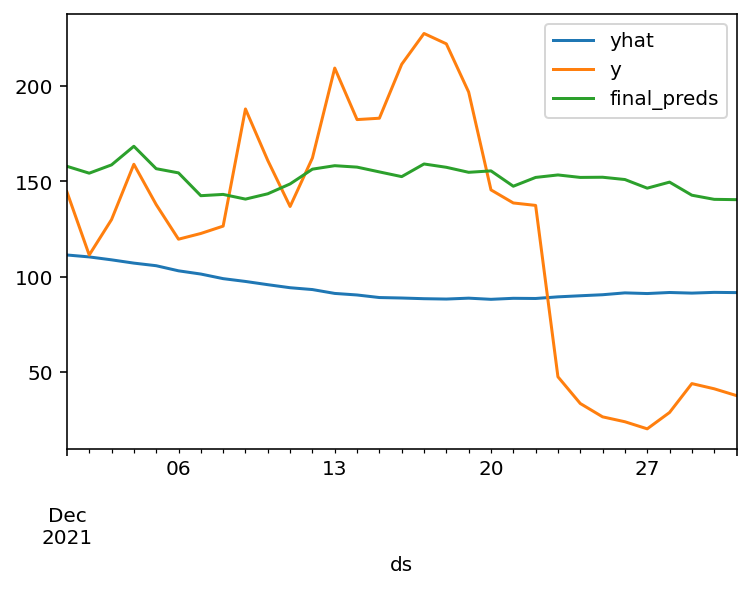

In [ ]:
res_df.plot()

In [ ]:
MAPE(res_df['y'],res_df['final_preds'])

1.205576994954422

# 05 Linear Model

## (i) LinearR

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,TimeSeriesSplit
import seaborn as sns 

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
data = prophet_data[['y']]
data.columns = ["y"]

In [ ]:
linear_data = prophet_data.set_index('ds')

In [ ]:
for i in range(6, 25):
    data["lag_{}".format(i)] = data['y'].shift(i)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

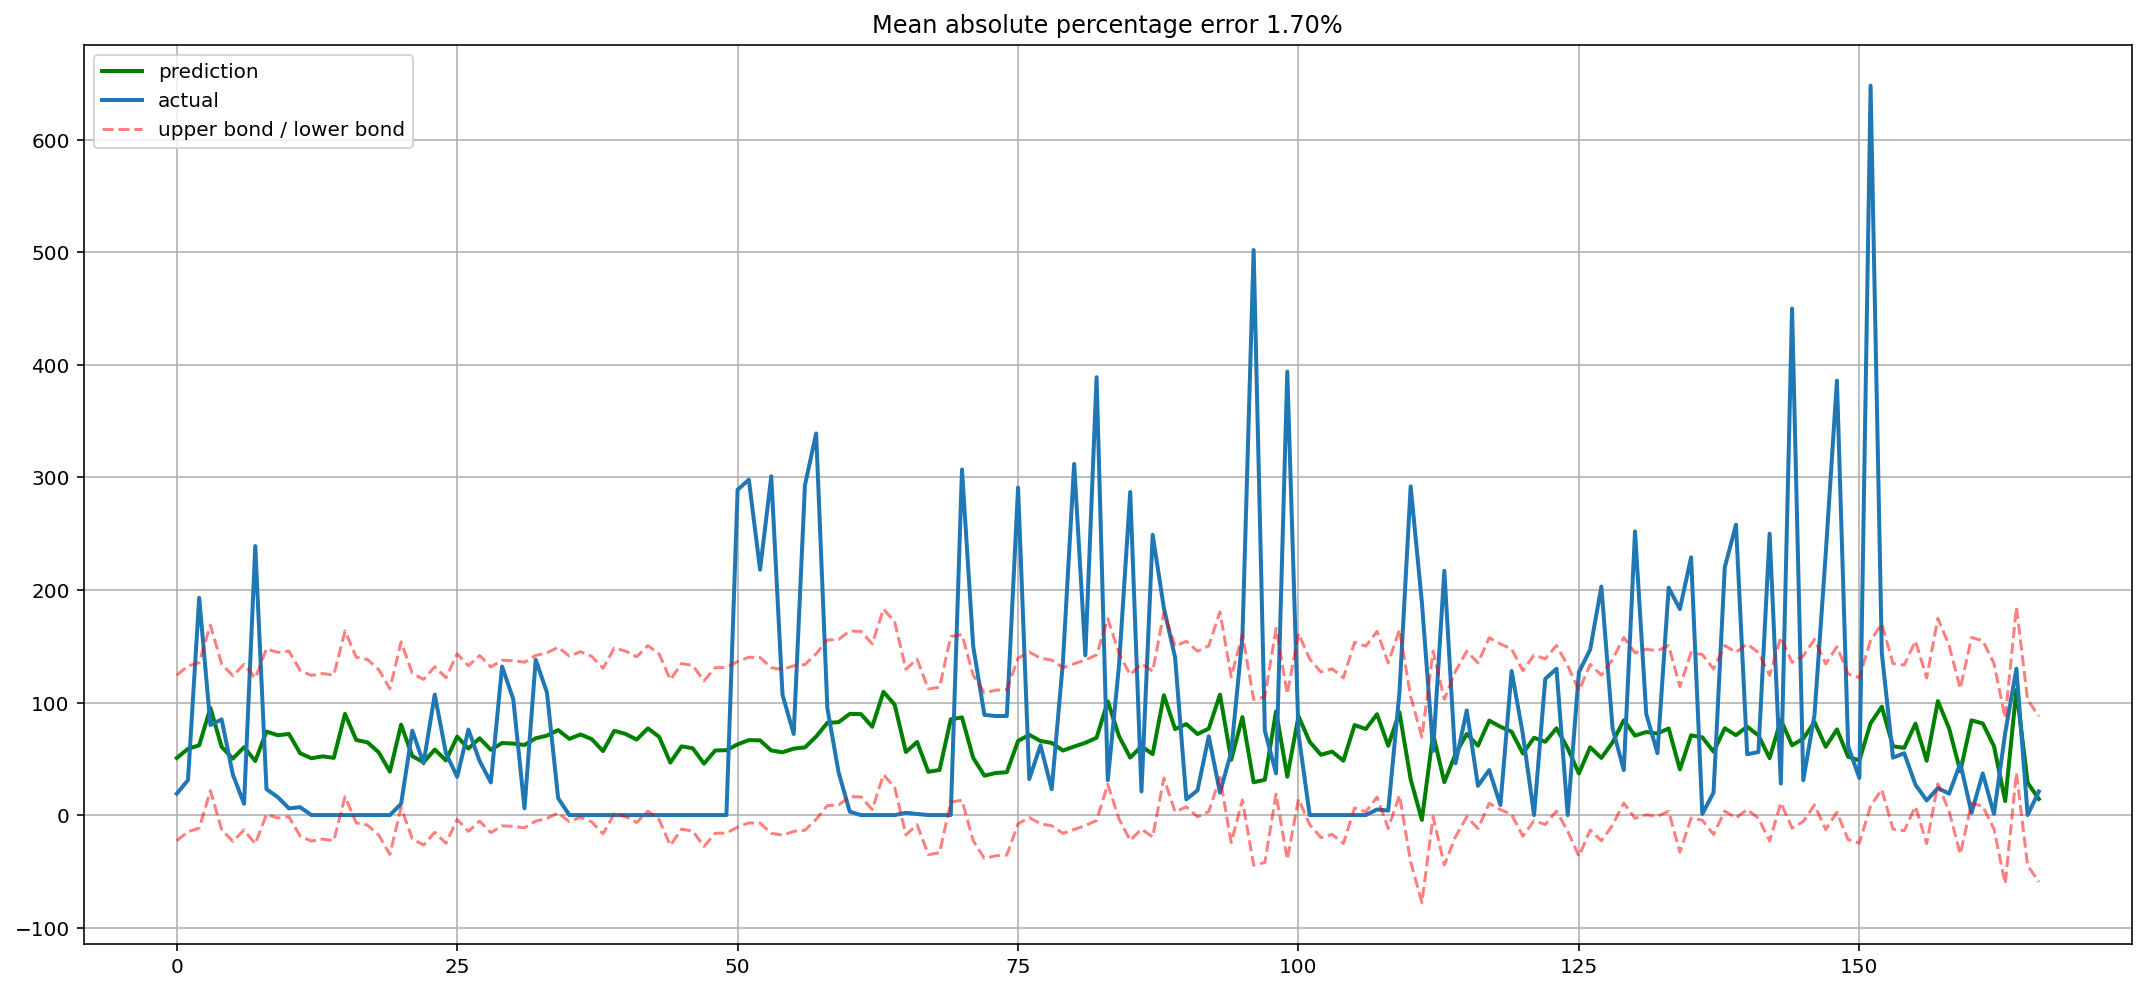

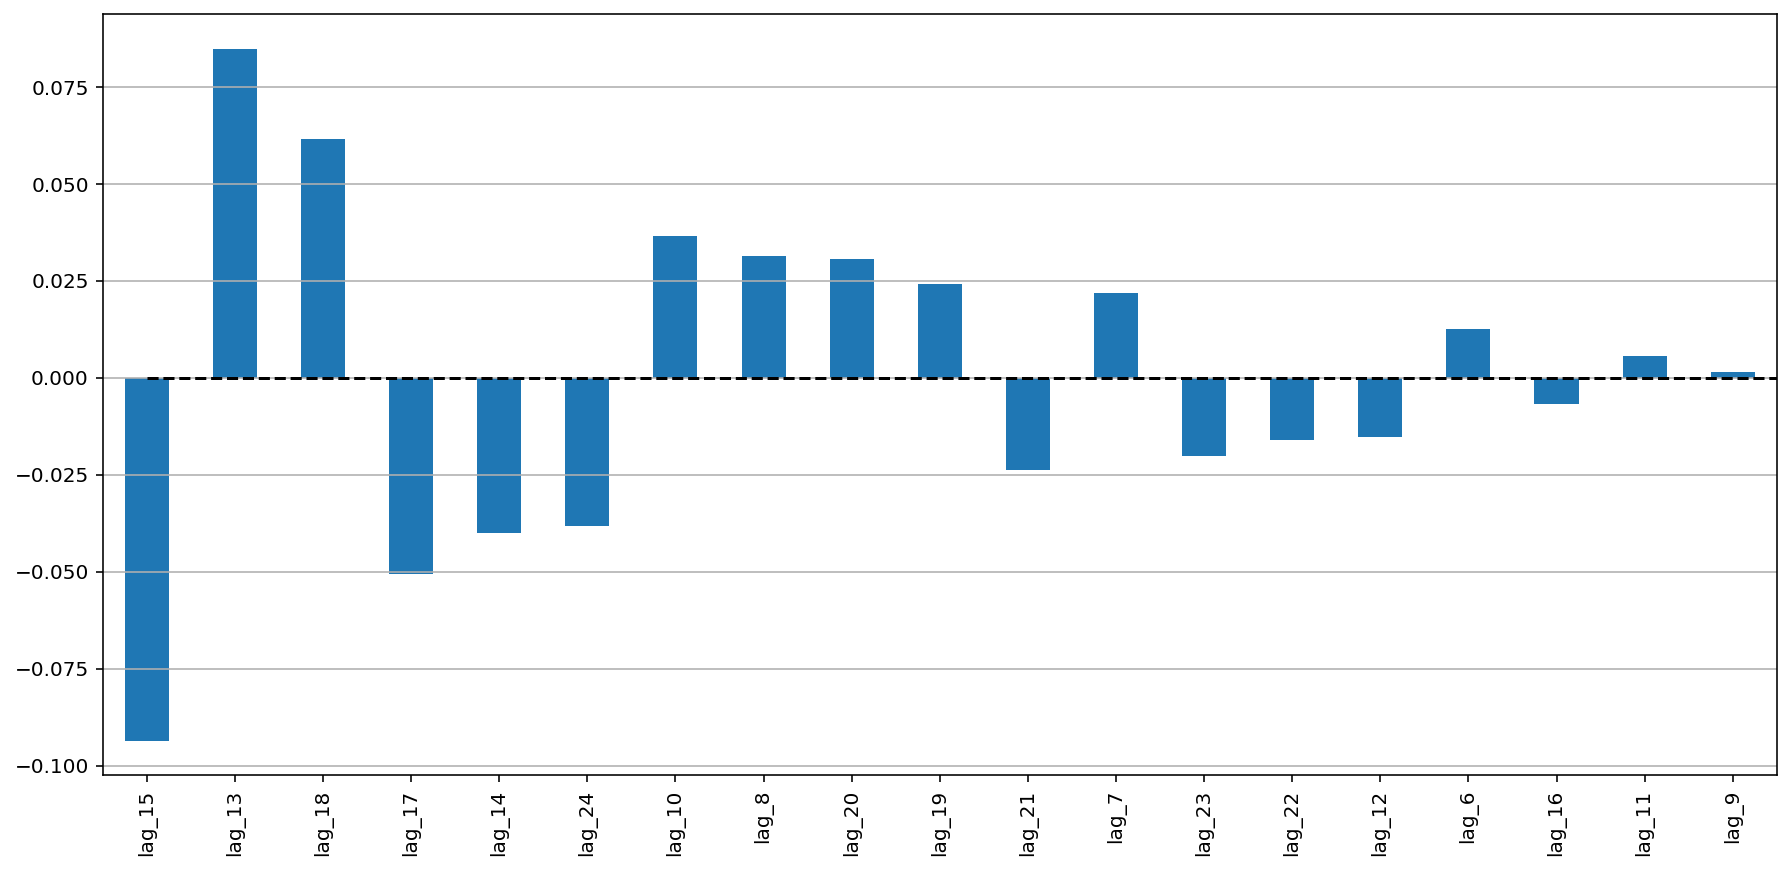

In [ ]:
plotModelResults(lr,X_train, X_test, y_train, y_test,plot_intervals=True)
plotCoefficients(lr)

In [ ]:
data.index = pd.to_datetime(prophet_data.ds)
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1
data.tail()

y  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
ds                                                                            
2021-12-27    1   13.0   27.0   55.0   51.0   144.0   648.0    33.0    61.0   
2021-12-28   73   24.0   13.0   27.0   55.0    51.0   144.0   648.0    33.0   
2021-12-29  130   19.0   24.0   13.0   27.0    55.0    51.0   144.0   648.0   
2021-12-30    0   46.0   19.0   24.0   13.0    27.0    55.0    51.0   144.0   
2021-12-31   21    2.0   46.0   19.0   24.0    13.0    27.0    55.0    51.0   

            lag_14  ...  lag_17  lag_18  lag_19  lag_20  lag_21  lag_22  \
ds                  ...                                                   
2021-12-27   386.0  ...    31.0   450.0    28.0   250.0    56.0    54.0   
2021-12-28    61.0  ...    89.0    31.0   450.0    28.0   250.0    56.0   
2021-12-29    33.0  ...   232.0    89.0    31.0   450.0    28.0   250.0   
2021-12-30   648.0  ...   386.0   232.0    89.0    31.0   450.0    28.0   
2021-12-31   144.0  ...    61.0   386.0   232.0    89.0    31.0   450.0   

            lag_23  lag_24  weekday  is_weekend  
ds                                               
2021-12-27   258.0   220.0        0           0  
2021-12-28    54.0   258.0        1           0  
2021-12-29    56.0    54.0        2           0  
2021-12-30   250.0    56.0        3           0  
2021-12-31    28.0   250.0        4           0  

[5 rows x 22 columns]

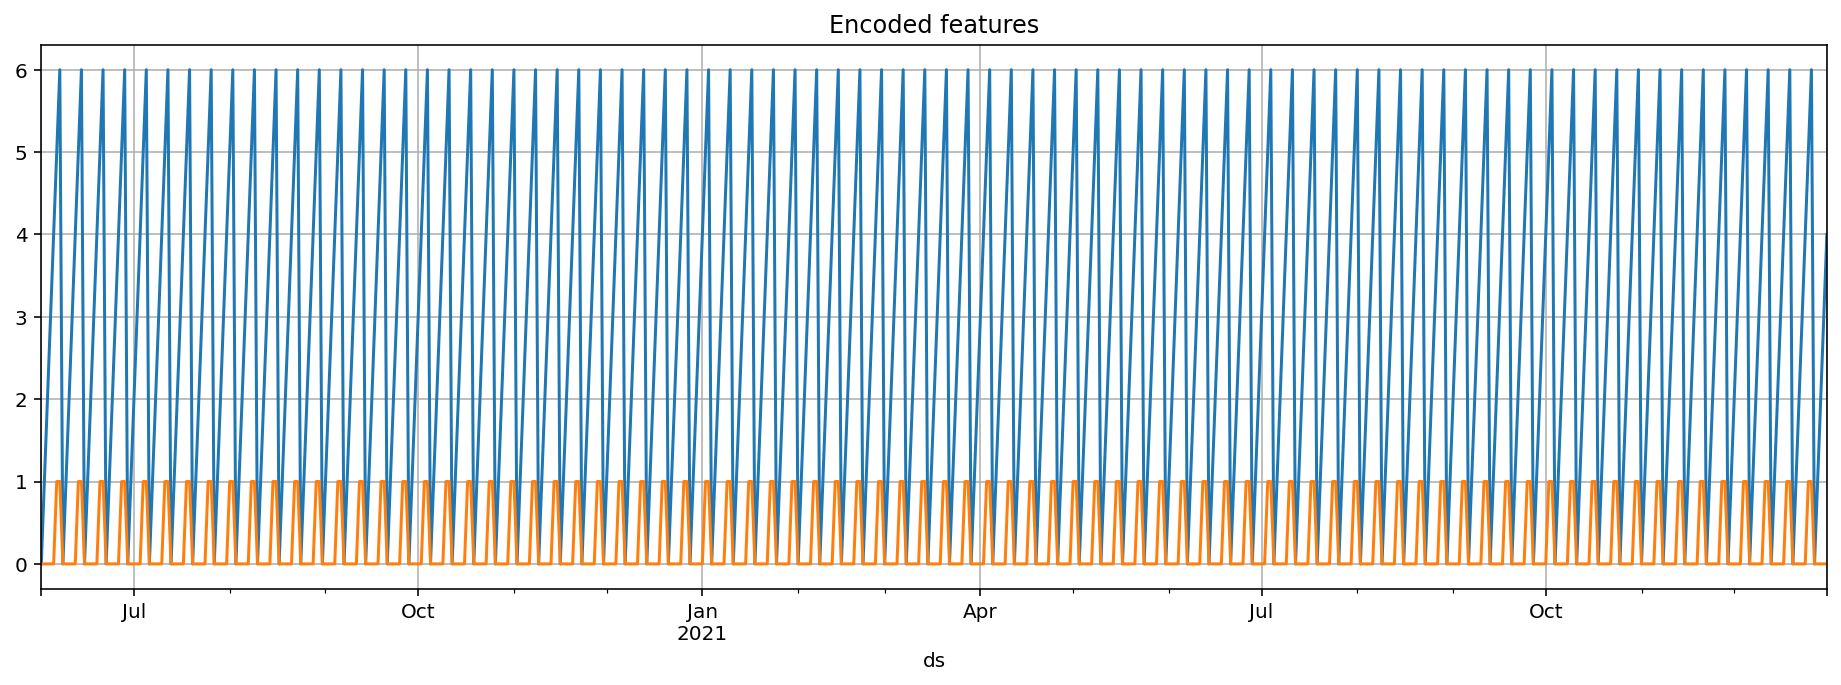

In [ ]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

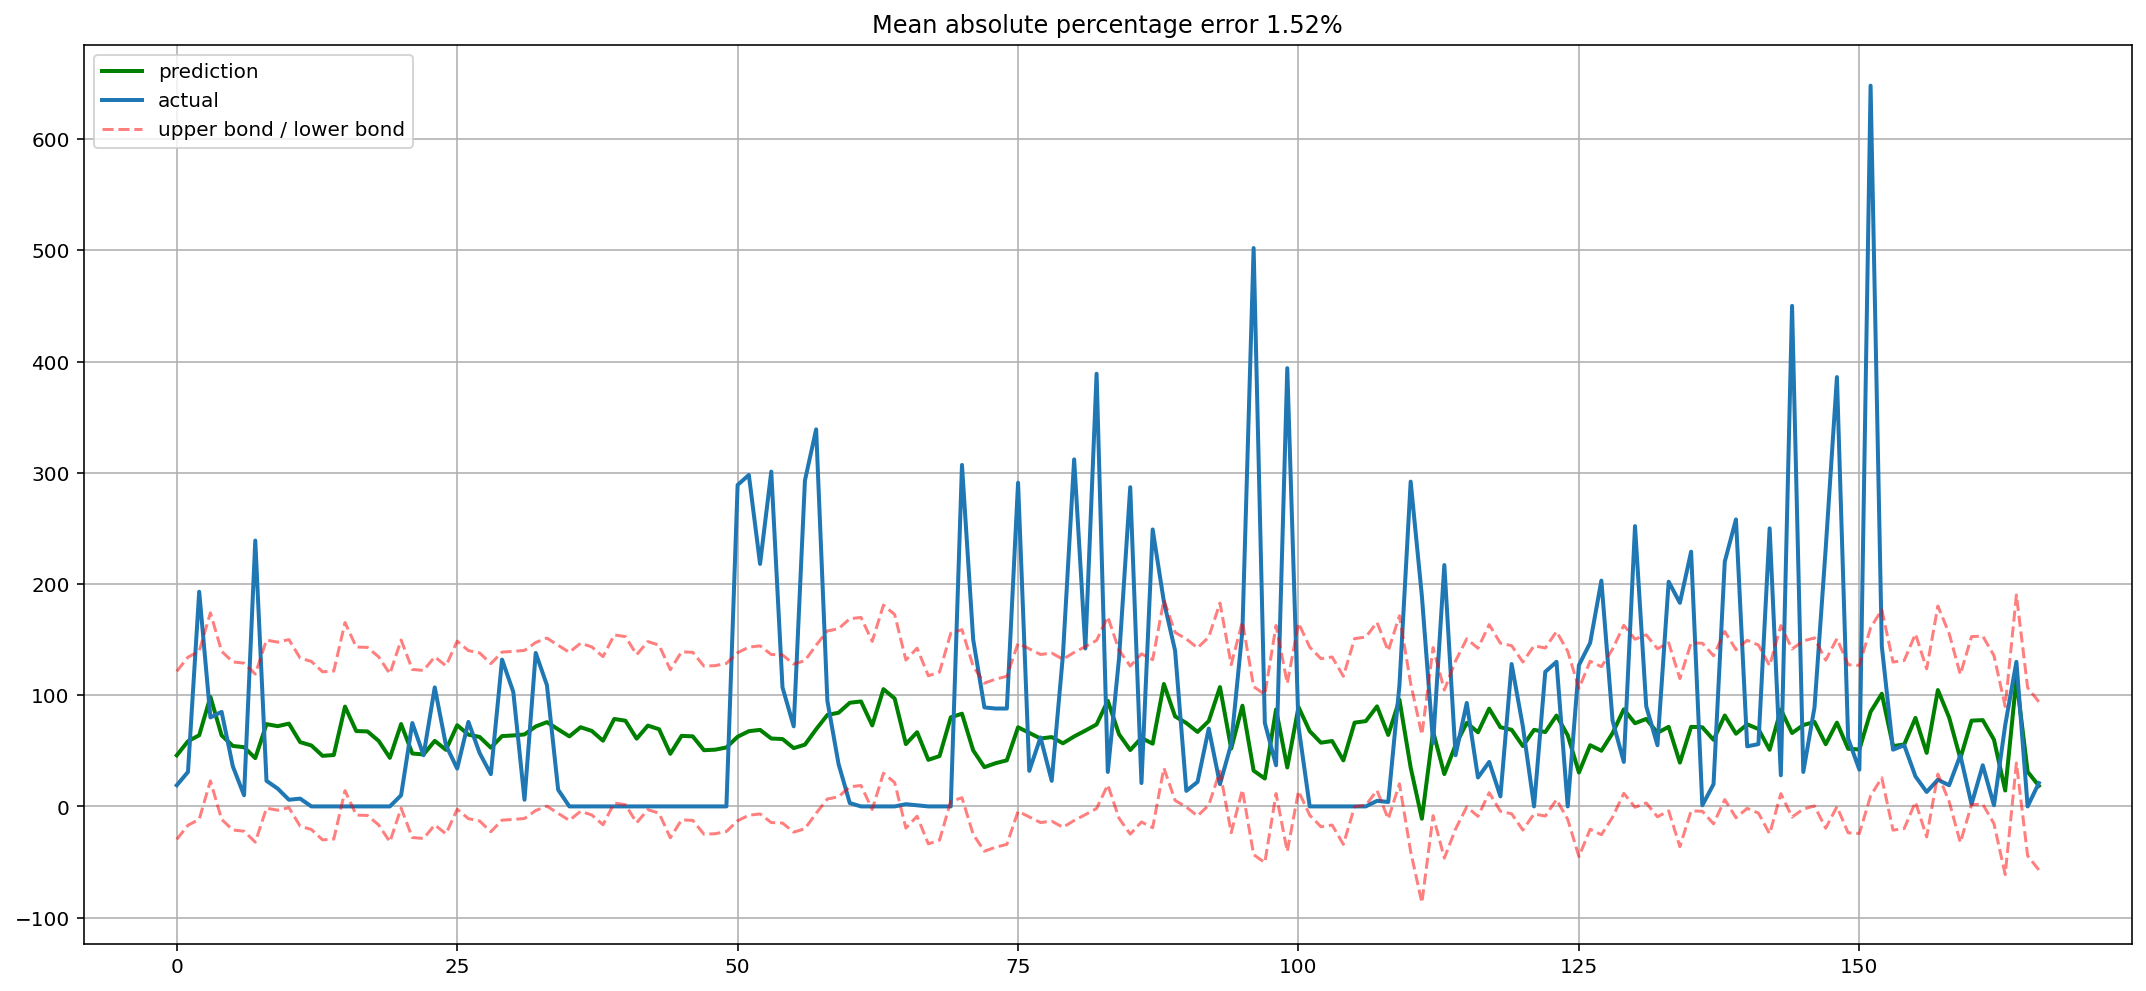

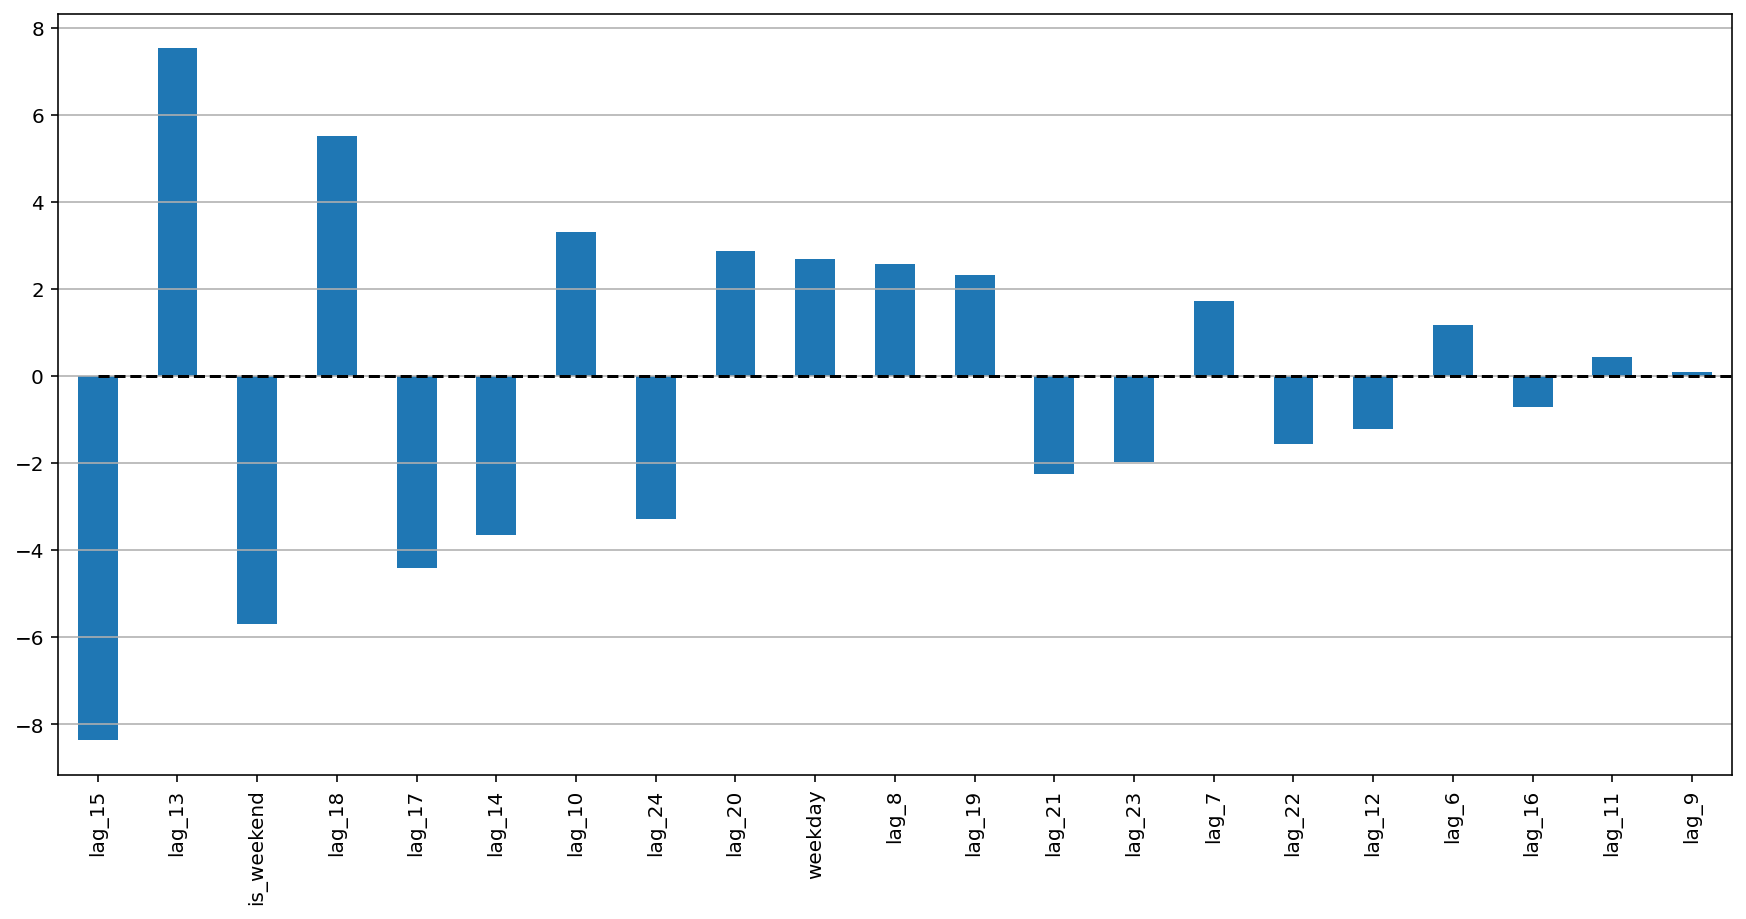

In [ ]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled,y_train=y_train,y_test=y_test, plot_intervals=True)
plotCoefficients(lr)

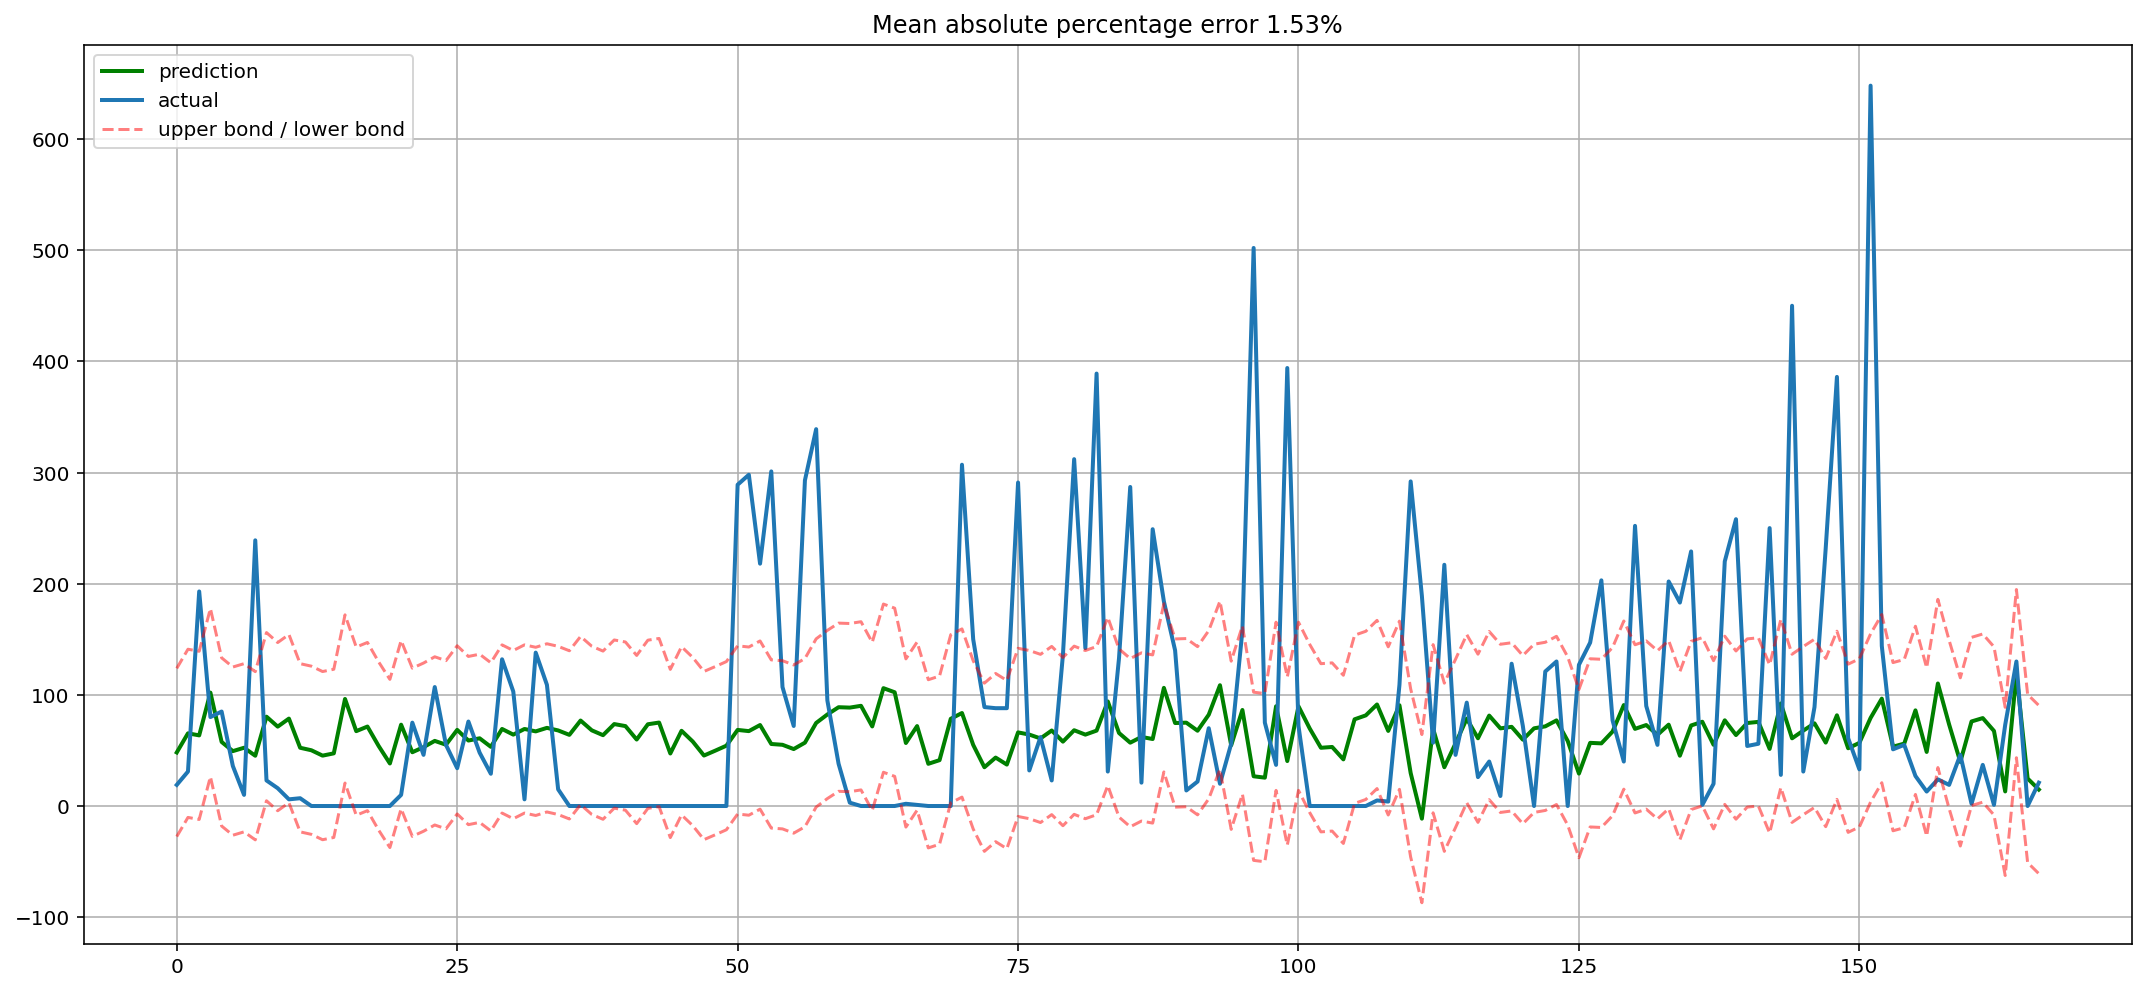

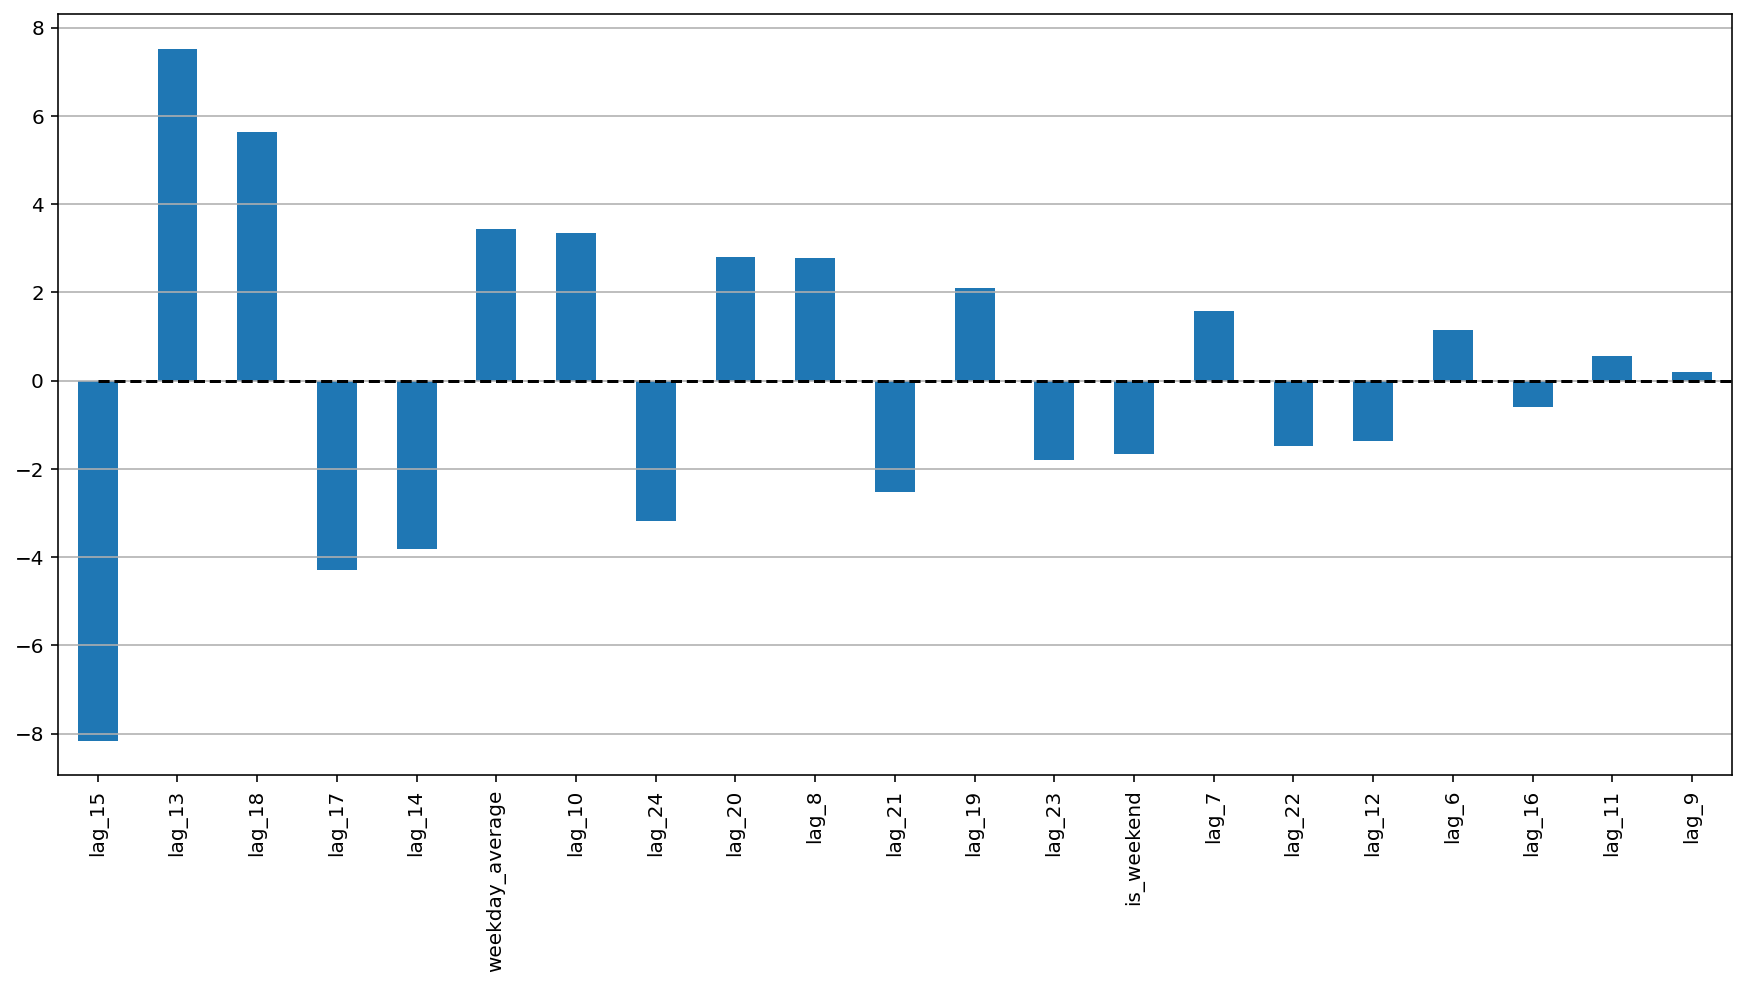

In [ ]:
X_train, X_test, y_train, y_test = prepareData(
    linear_data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(
    lr,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    plot_intervals=True,
    # plot_anomalies=True,
)
plotCoefficients(lr)

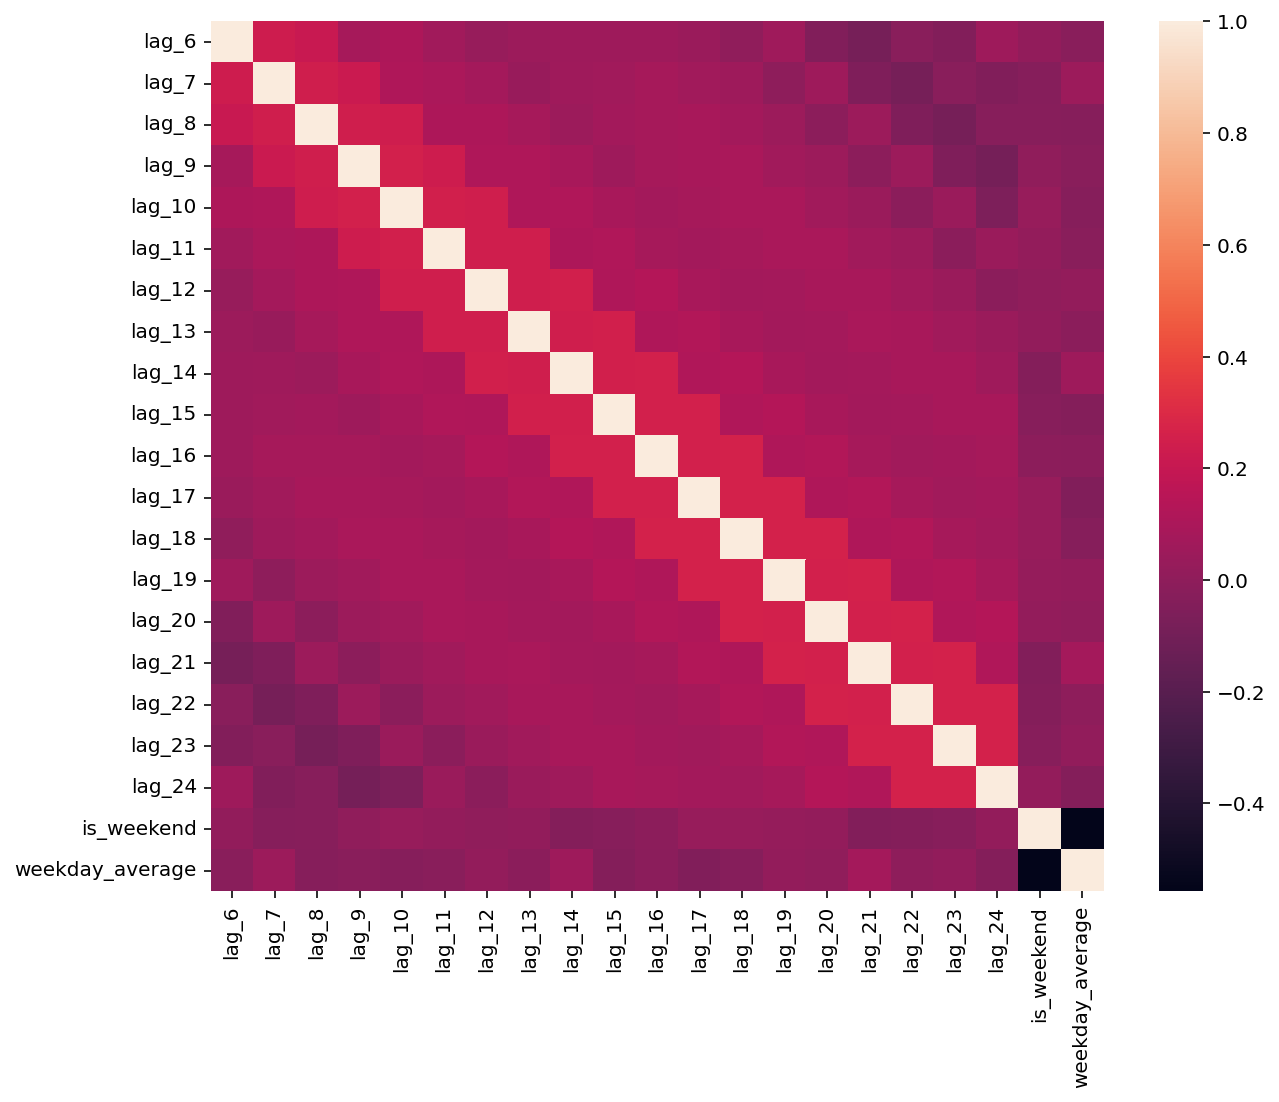

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

## (ii) Treebased

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
data.index = pd.DatetimeIndex(prophet_data.ds)
data.shape

(579, 22)

In [ ]:
for i in range(30, 60):
    data["lag_{}".format(i)] = data['y'].shift(i)

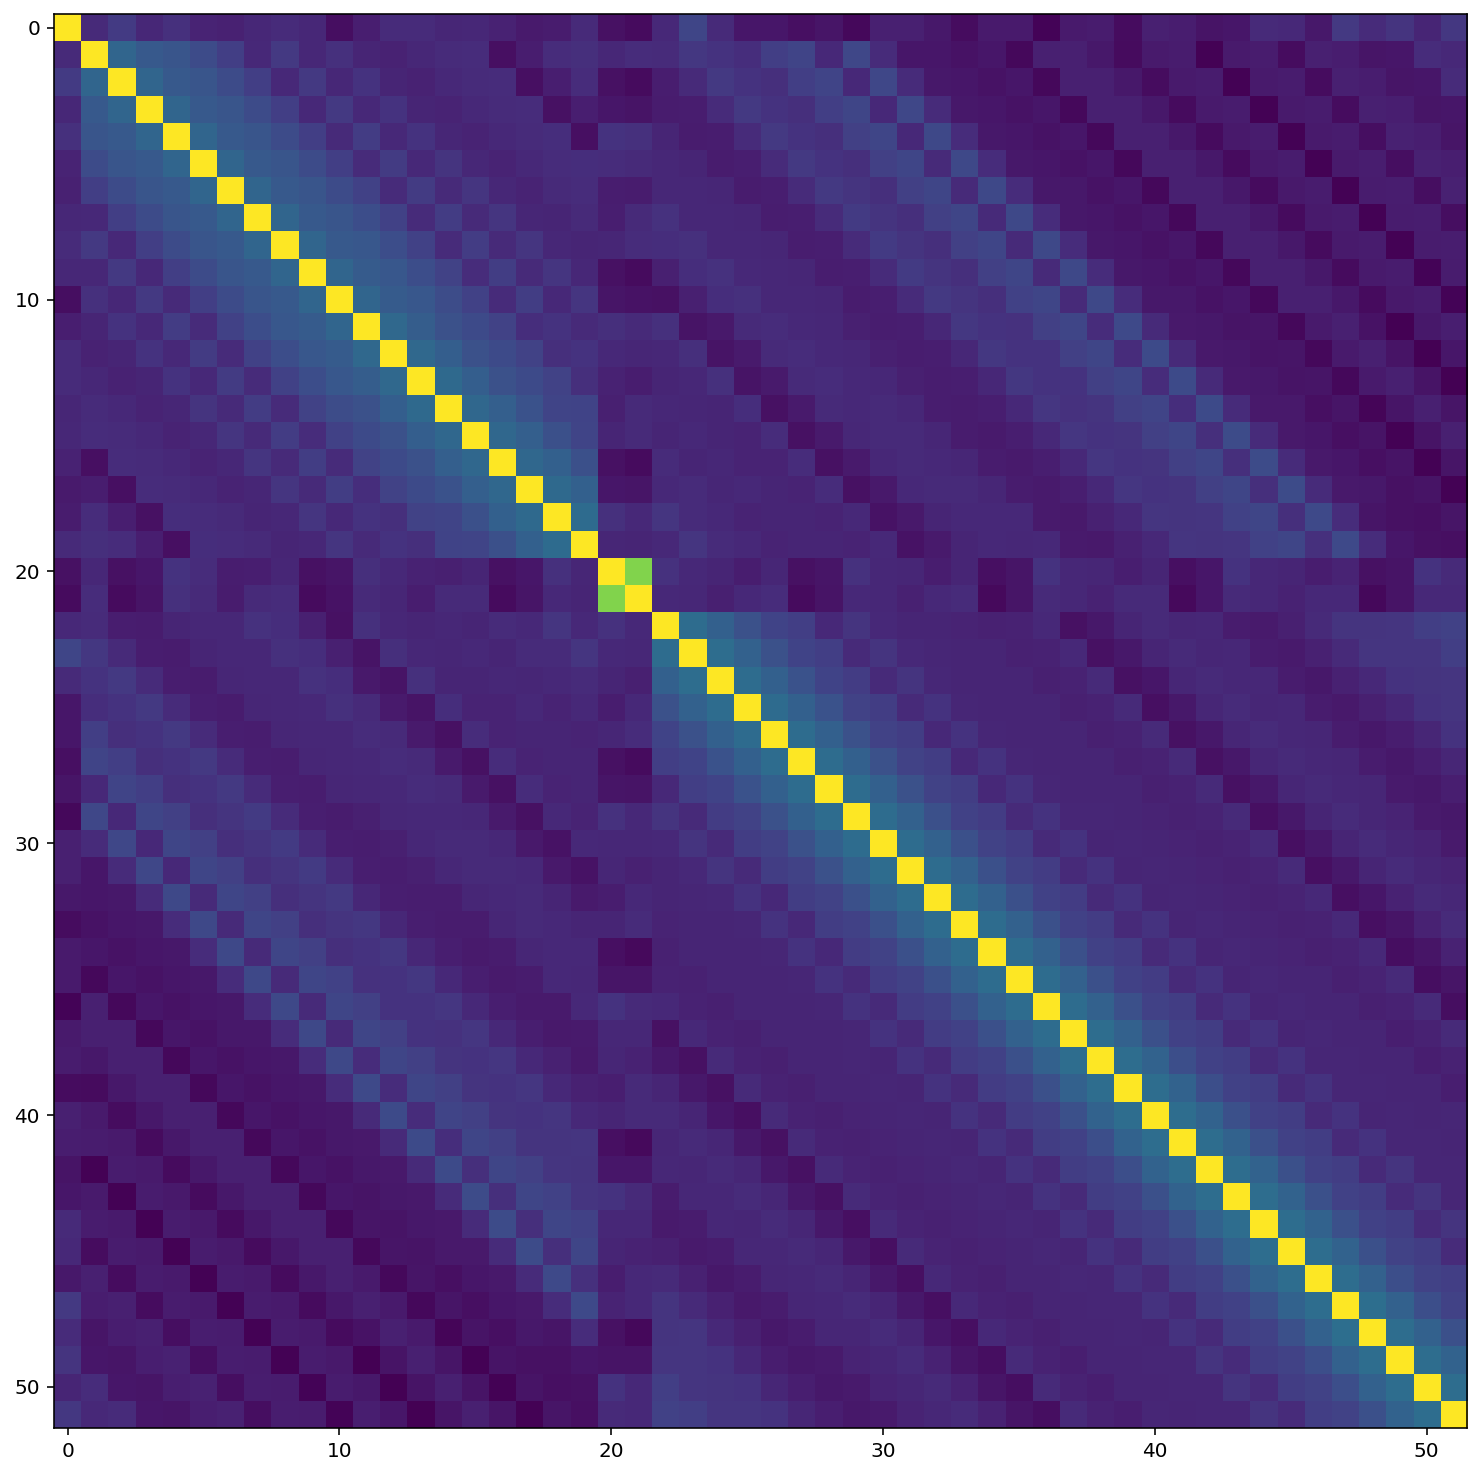

In [ ]:
fig = plt.figure(figsize=(13,13))
ax = plt.imshow(data.corr())
plt.show()

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
y = data.pop('y')
X = data

In [ ]:
xtrain,xvalid,ytrain,yvalid = timeseries_train_test_split(X,y,test_size=0.1)
xtrain,xtest,ytrain,ytest = timeseries_train_test_split(xtrain,ytrain,test_size=0.3)

In [ ]:
len(xtrain),len(ytrain)

(364, 364)

In [ ]:
len(xvalid),len(yvalid)

(58, 58)

In [ ]:
len(xtest),len(ytest)

(157, 157)

In [ ]:
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)
xvalid_scaled = scaler.transform(xvalid)

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(verbosity=1)
xgb.fit(xtrain_scaled, ytrain)

[03:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

[03:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


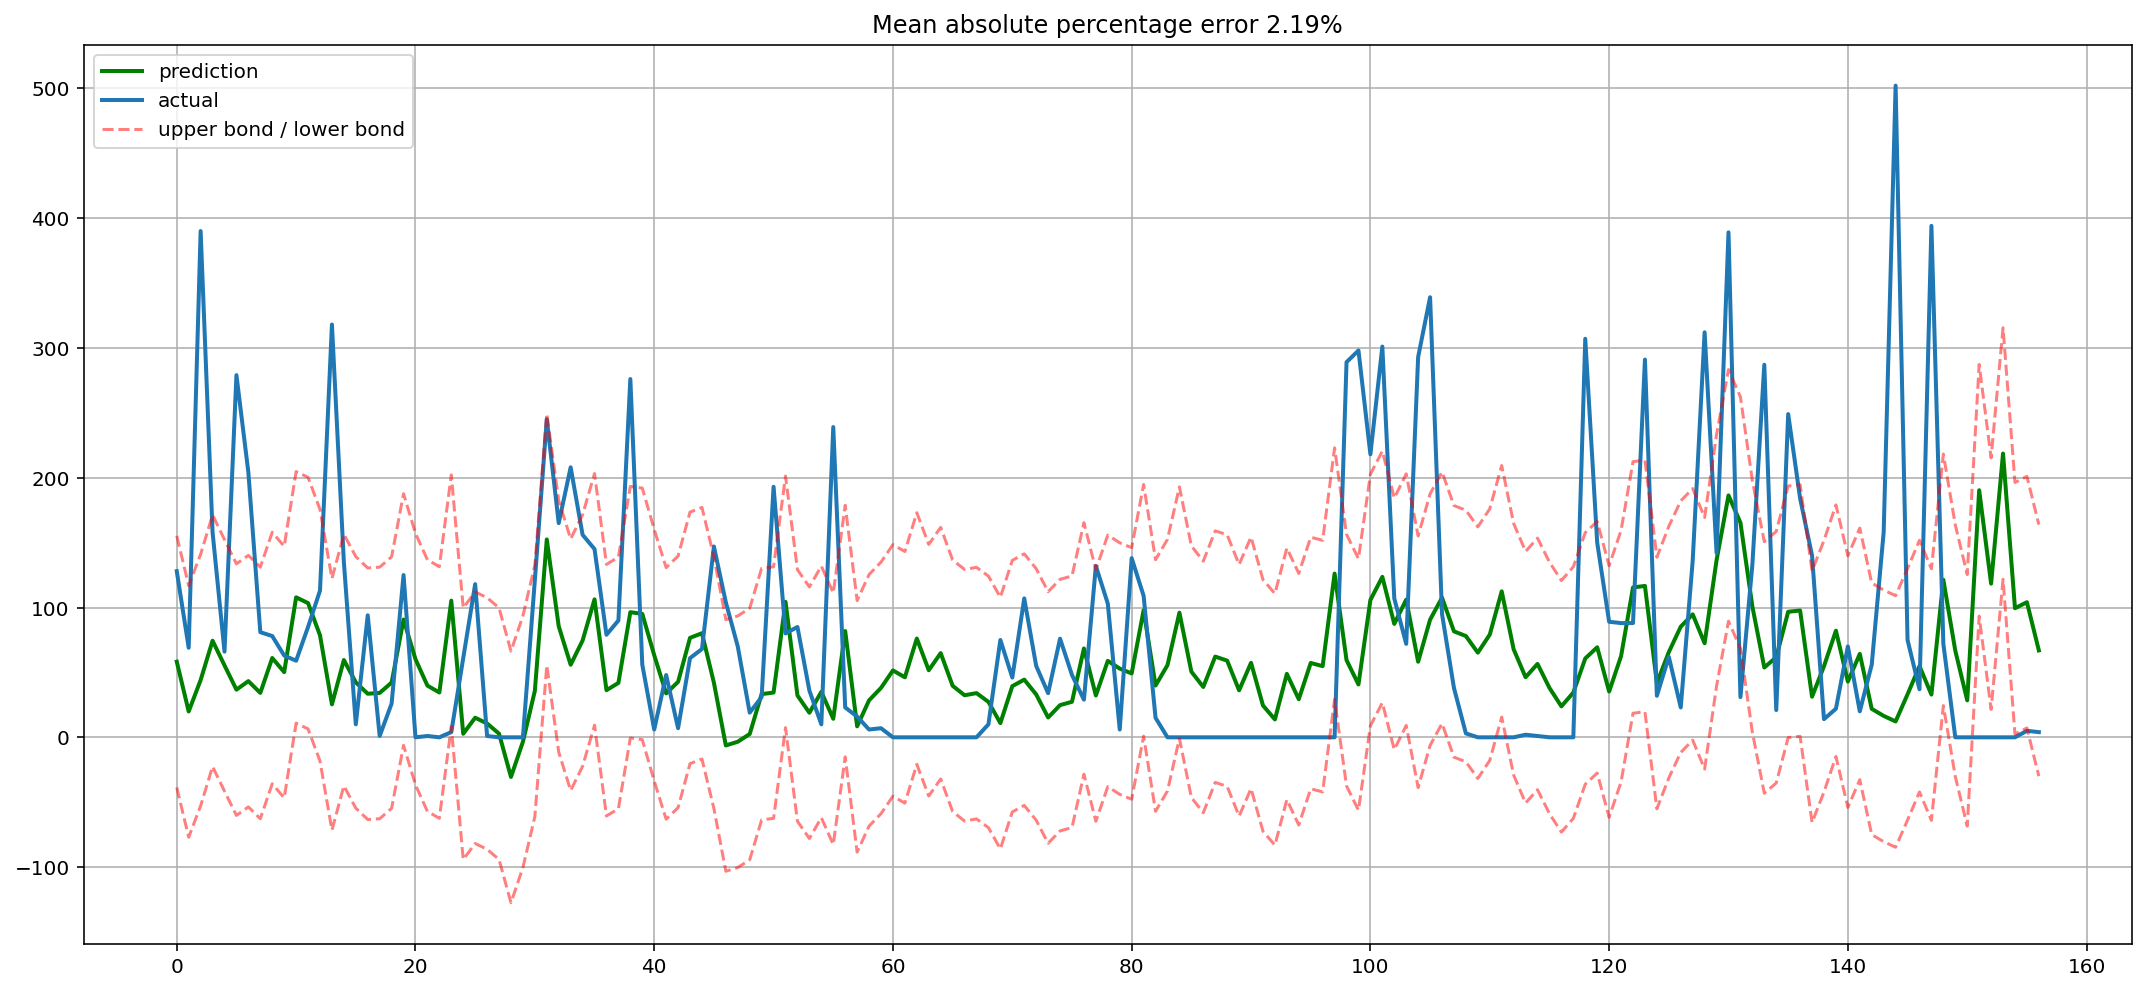

In [ ]:
plotModelResults(
    xgb,
    X_train=xtrain_scaled,
    X_test=xtest_scaled,
    y_test= ytest,
    y_train=ytrain,
    plot_intervals=True
)

[03:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


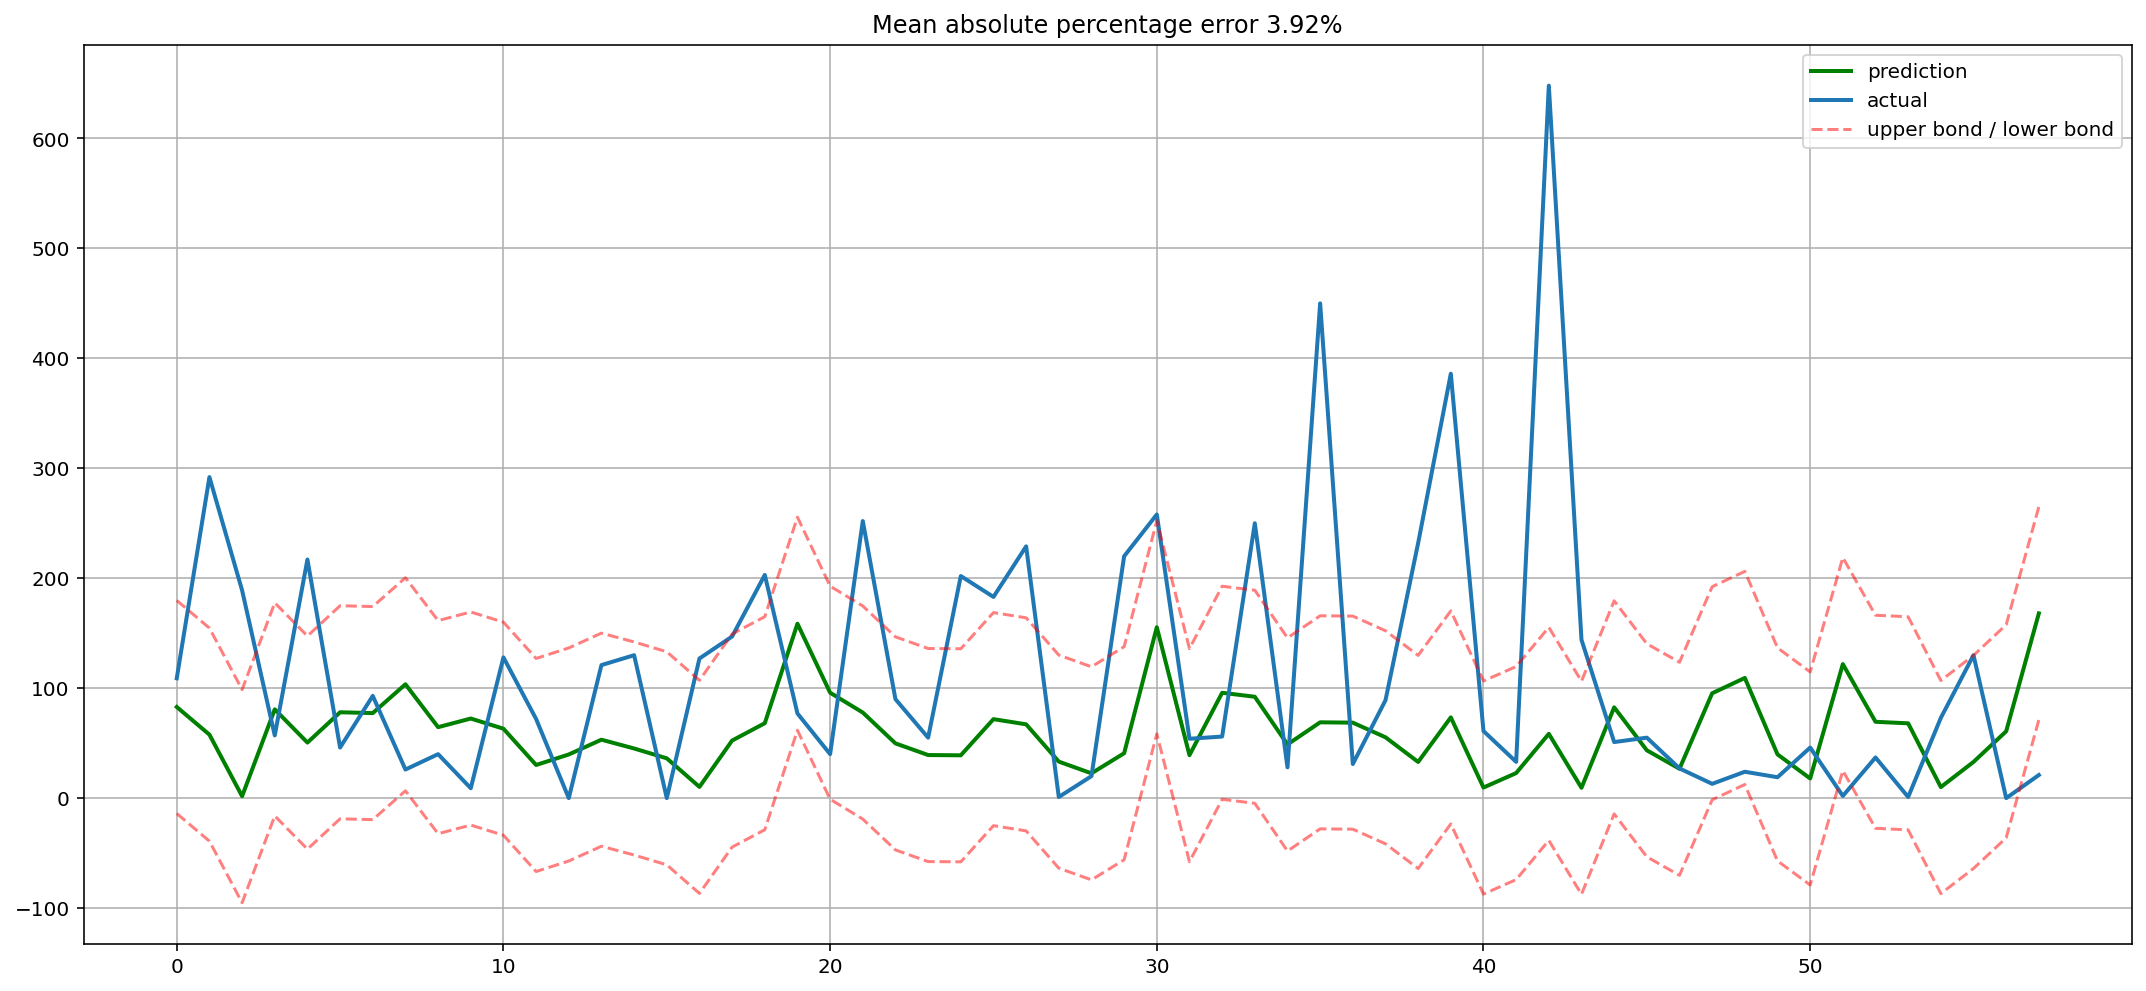

In [ ]:
plotModelResults(
    xgb,
    X_train=xtrain_scaled,
    X_test=xvalid_scaled,
    y_test= yvalid,
    y_train=ytrain,
    plot_intervals=True
)

# 06 Mutiple TS

## Initial try

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
def get_scaled_data(xtrain,xtest):
  scaler = StandardScaler()
  xtrain_scaled = scaler.fit_transform(xtrain)
  xtest_scaled = scaler.transform(xtest)
  return xtrain_scaled,xtest_scaled

In [ ]:
df_copy = df.copy()
df_copy.usage = df_copy.usage +1

In [ ]:
def train_bulk(df,users,error='mape',log_usage=False):
  errors= []
  unusual_behaviours = {}
  result = {msisdn:
            {"actual":[],
             "predicted":[]
             } for msisdn in users}
  for uid in tqdm(users):
    data = df.query("msisdn==@uid")['usage']
    xtrain,xtest,ytrain,ytest = prepareData(data,lag_start=30,lag_end=60,test_size=0.1)
    xtrain_scaled,xtest_scaled = get_scaled_data(xtrain,xtest)

    xgb = XGBRegressor(verbosity=1,objective ='reg:squarederror')
    xgb.fit(xtrain_scaled, ytrain)

    predictions = xgb.predict(xtest_scaled).tolist()
    if log_usage:predictions = [np.exp(x) for x in predictions]

    ytest = ytest.values.tolist()
    if log_usage:[np.exp(x) for x in ytest]

    result[uid]['actual'].extend(ytest)
    result[uid]['predicted'].extend(predictions)
    # if error=='mape':
    error = MAPE(result[uid]['actual'],result[uid]['predicted'])
    # elif error=='mae':
    # error = MAE(result[uid]['actual'],result[uid]['predicted'])
    errors.append(error)
    # print(error)
  return result,errors

In [ ]:
sample_users = np.random.choice(df.msisdn.unique(),100)

In [ ]:
predictions_100,error_100 = train_bulk(df_copy,sample_users,error='mape')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.mean(error_100)

91.06434623287538

In [ ]:
low_error_users = {}
high_error_users = {}
medium_error_users = {}

for x in sample_users:
  error = MAPE(predictions_100[x]['actual'],predictions_100[x]['predicted'])
  if error <40:
    low_error_users[x] = error
  elif error <=60:
    medium_error_users[x] = error
  else:
    high_error_users[x] = error


In [ ]:
error_low = np.mean(list(low_error_users.values()))
error_medium = np.mean(list(medium_error_users.values()))
error_high = np.mean(list(high_error_users.values()))

In [ ]:
f"MAPE for low error users is {error_low:.3f} count of users {len(low_error_users)}"

'MAPE for low error users is 22.822 count of users 52'

In [ ]:
f"MAPE for low error users is {error_medium:.3f} count of users {len(medium_error_users)}"

'MAPE for low error users is 49.368 count of users 13'

In [ ]:
f"MAPE for low error users is {error_high:.3f} count of users {len(high_error_users)}"

'MAPE for low error users is 207.941 count of users 35'

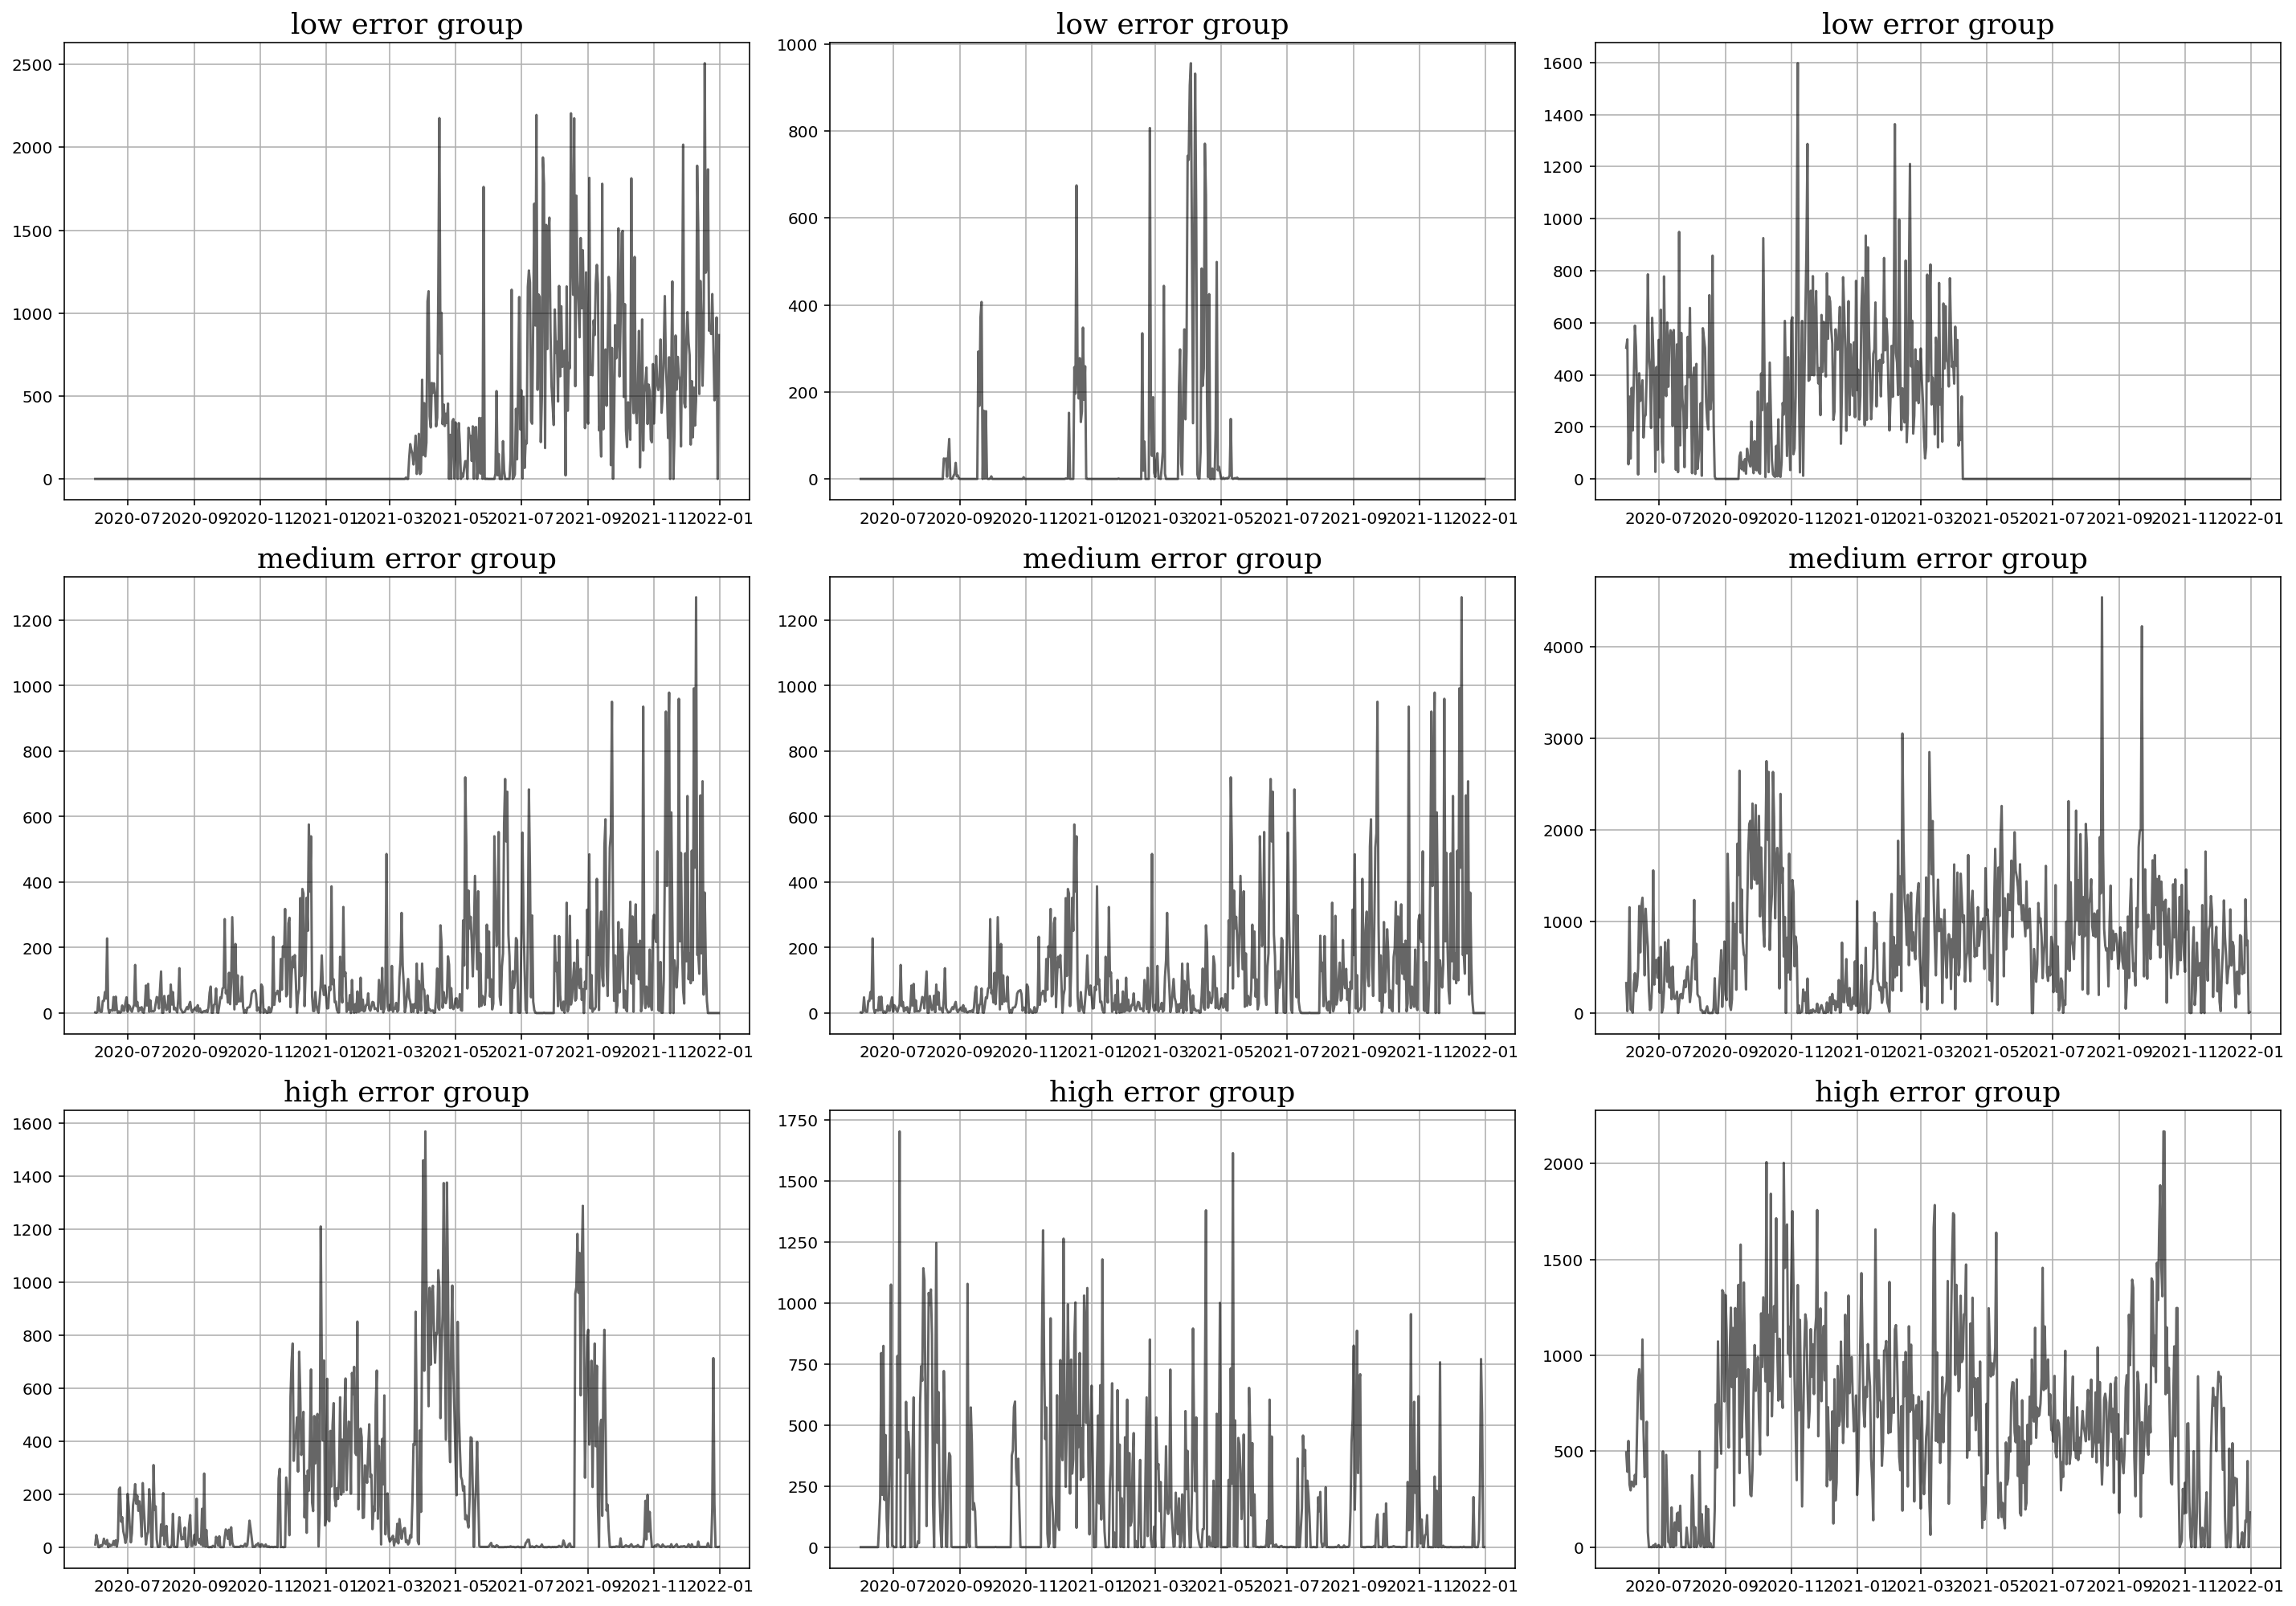

In [ ]:
_,ax = plt.subplots(3,3,figsize=(20,14))

low_error_sample = np.random.choice(list(low_error_users.keys()),3)
medium_error_sample = np.random.choice(list(medium_error_users.keys()),3)
high_error_sample = np.random.choice(list(high_error_users.keys()),3)
map_ = {0:"low error group",1:"medium error group",2:"high error group"}

for i,group in enumerate([low_error_sample,medium_error_sample,high_error_sample]):
  for j,user in enumerate(group):
    ax[i][j].plot(df.query("msisdn==@user")['usage'],color='black',alpha=0.6)
    ax[i][j].set_title(map_[i],fontfamily='serif',fontsize=18)
    ax[i][j].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
users_0 = list(low_error_users.keys())

In [ ]:
predictions_low,error_low = train_bulk(df_copy,users_0,error='mape')

  0%|          | 0/52 [00:00<?, ?it/s]

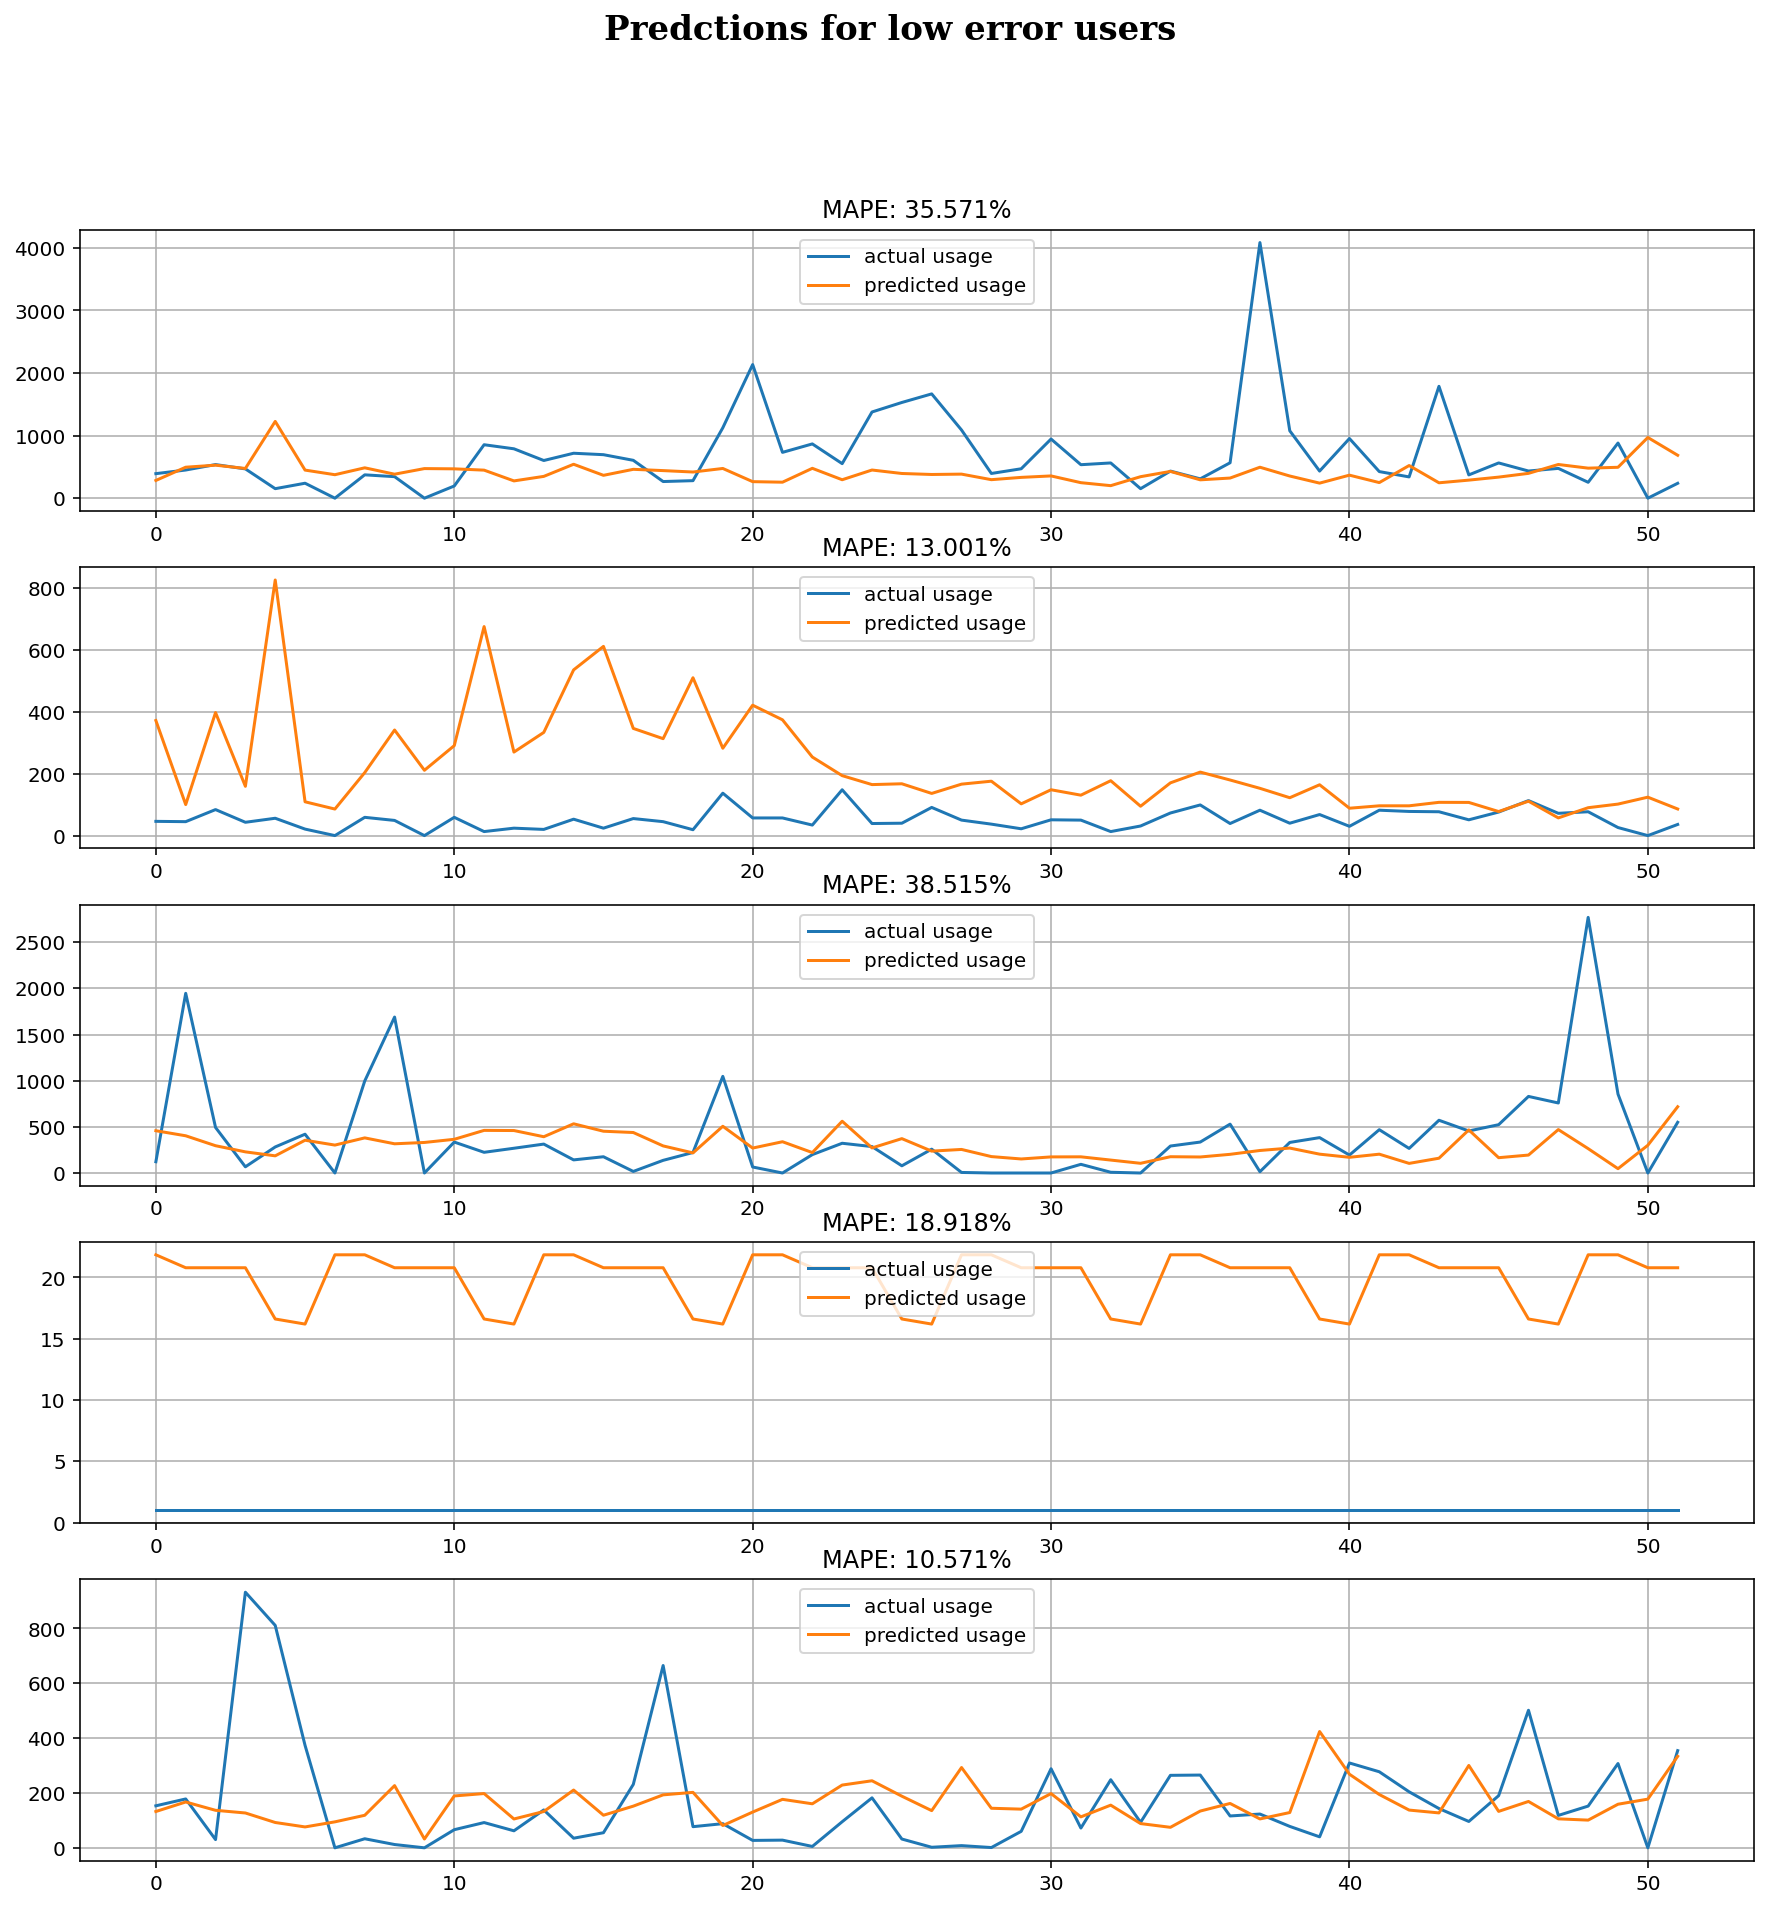

In [ ]:
fig,ax= plt.subplots(5,1,figsize=(15,15))

for i,user in enumerate(predictions_low):

  if i==5:break

  actual = predictions_low[user]['actual']
  predicted = predictions_low[user]['predicted']
  mape_ = MAPE(actual,predicted)
  ax[i].plot(actual,label='actual usage')
  ax[i].plot(predicted,label='predicted usage')
  ax[i].legend(loc='upper center')
  ax[i].set_title(f"MAPE: {mape_:.3f}%")
  ax[i].grid(True)

fig.suptitle('Predctions for low error users',fontfamily='serif',fontsize='17',fontweight='semibold')
# plt.tight_layout()
plt.show()

## Tring few transformations

### (i) Log trans

In [ ]:
from scipy.special import inv_boxcox
from scipy import stats

def box_cox_transformation(x: pd.Series):
    x_transformed, lambda_value = stats.boxcox(x)
    return x_transformed, lambda_value
    
def box_cox_inverse_transformation(x: pd.Series, lambda_value: float) -> pd.Series:
    return inv_boxcox(x, lambda_value)

In [ ]:
df_log = df_copy.copy()
df_log.usage = df_copy.usage.apply(lambda x:np.log(x)+1)
df_log.head()

msisdn     usage
2020-06-01    2860  1.000000
2020-06-01    5126  1.000000
2020-06-01    9047  1.000000
2020-06-01    9900  5.744932
2020-06-01    2406  1.000000

In [ ]:
users_01 = list(medium_error_users.keys())
users_02 = list(high_error_users.keys())

In [ ]:
predictions_medium,errors_medium = train_bulk(df_log,users_01,log_usage=True)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
predictions_high,errors_high = train_bulk(df_log,users_02,log_usage=True)

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
np.mean(errors_medium)

169.60408353259467

In [ ]:
np.mean(errors_high)

615.2887371394872

In [ ]:
# ?plt.subplots

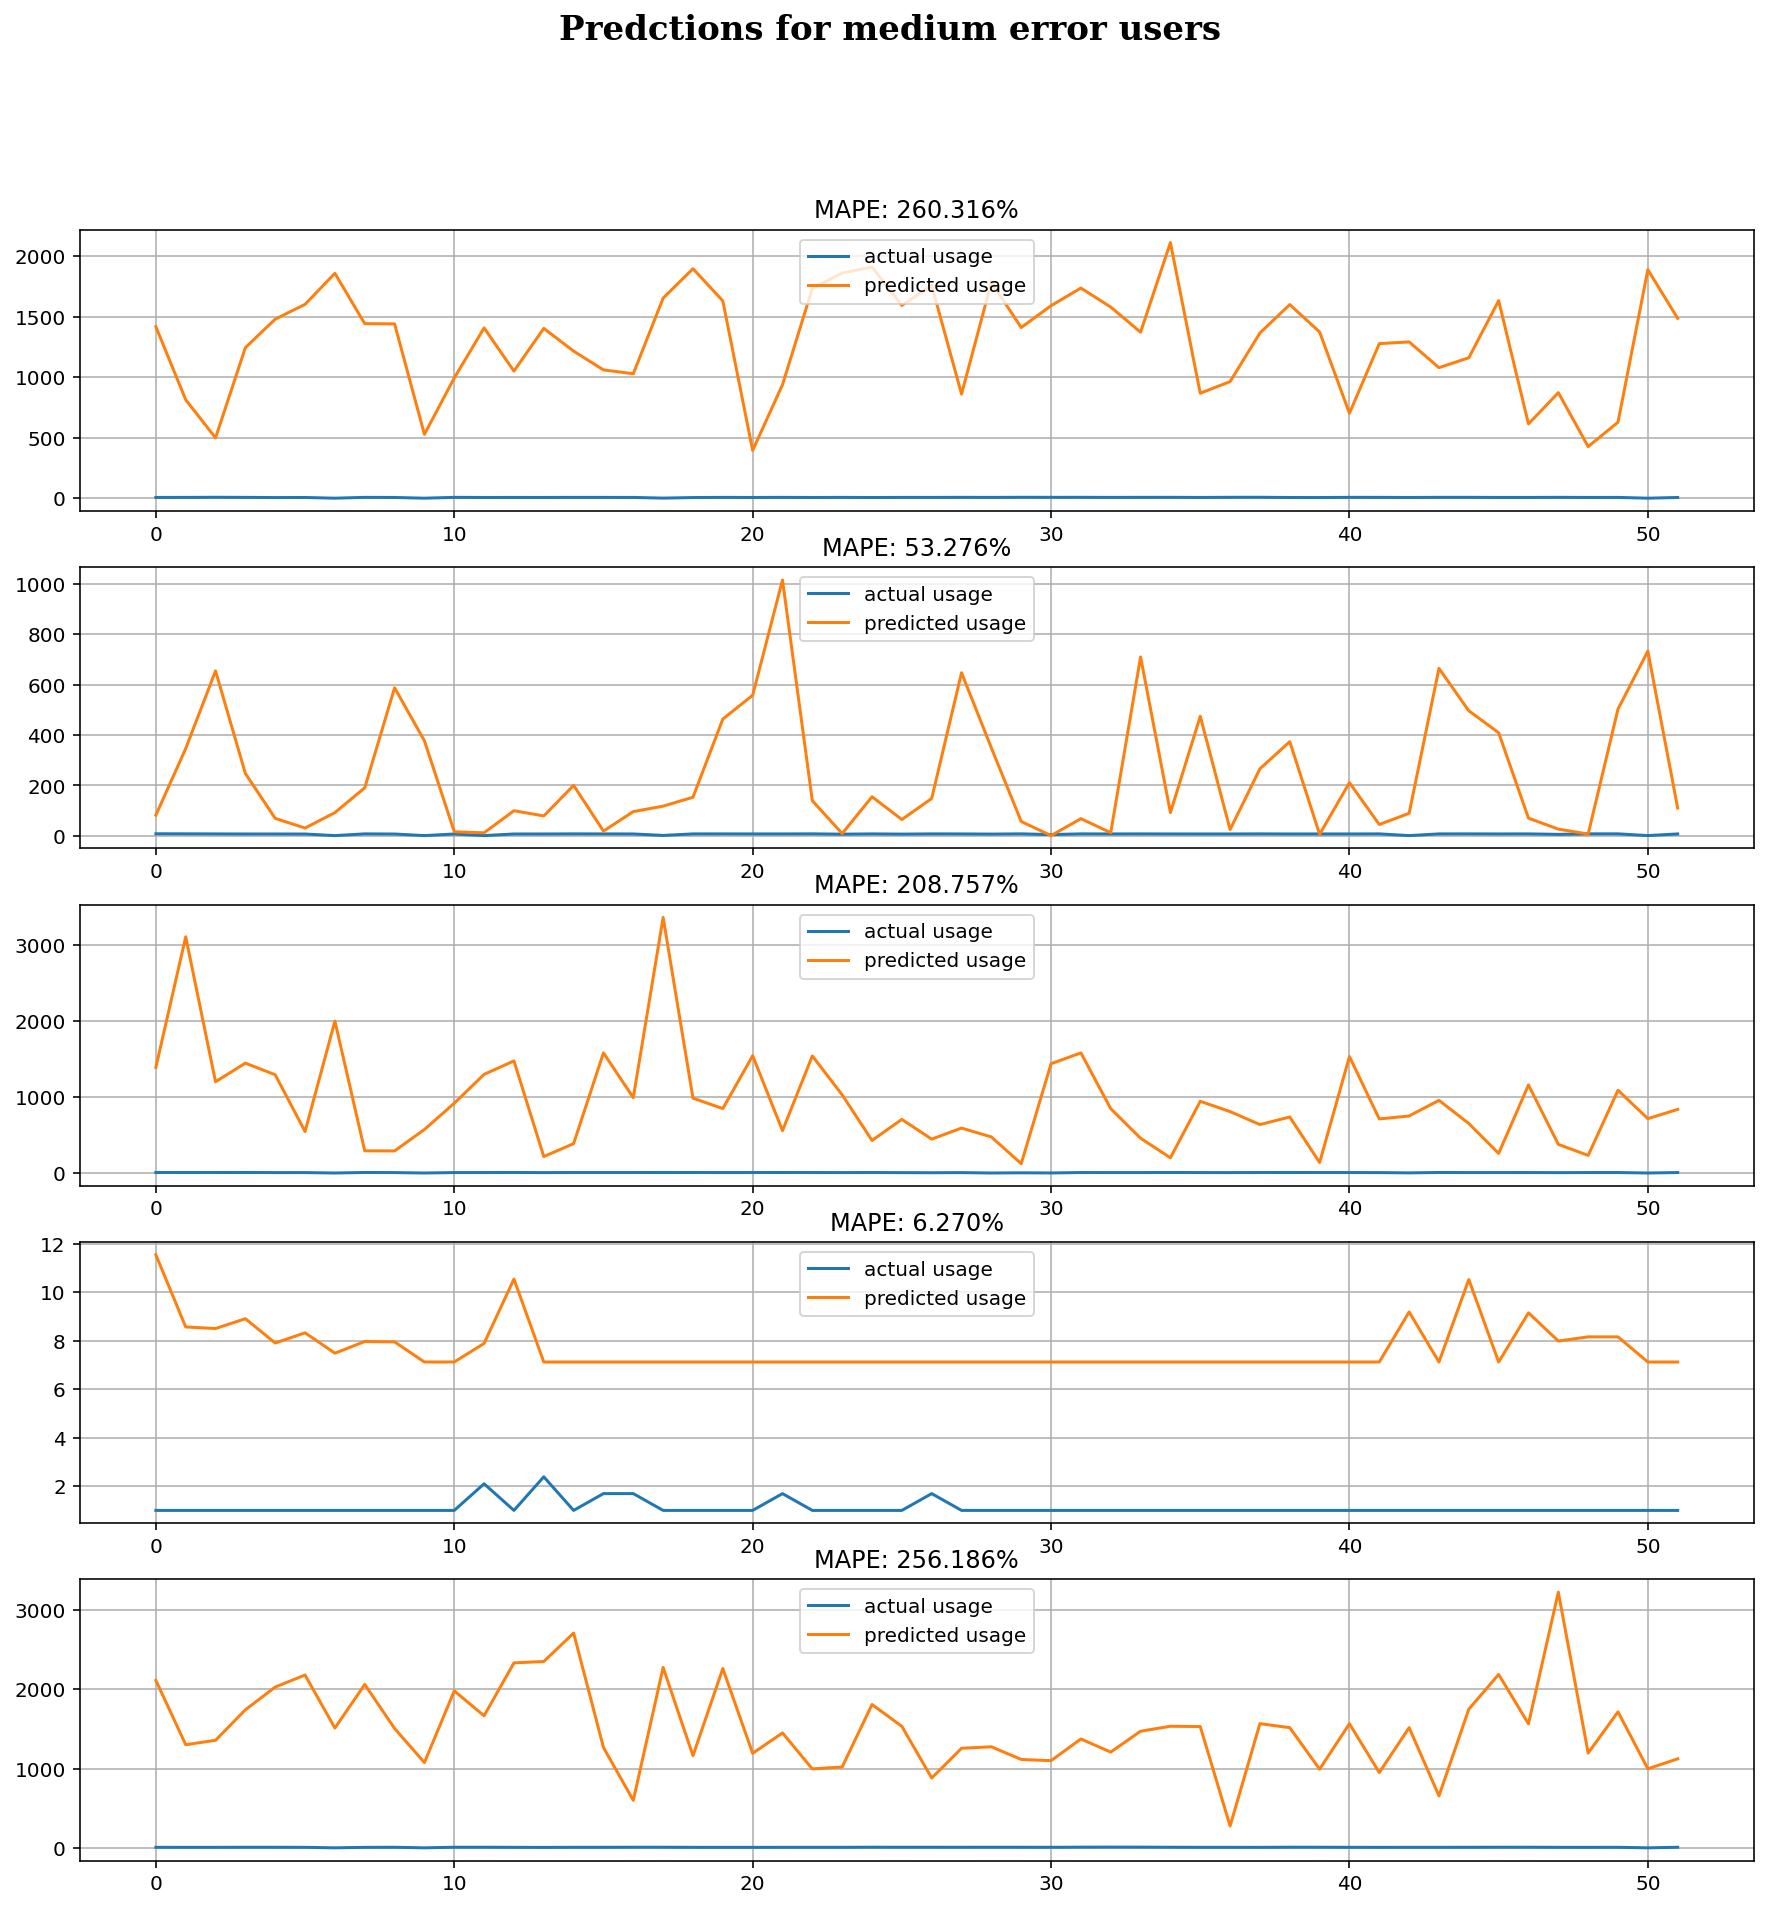

In [ ]:
fig,ax= plt.subplots(5,1,figsize=(15,15))

for i,user in enumerate(predictions_medium):

  if i==5:break

  actual = predictions_medium[user]['actual']
  predicted = predictions_medium[user]['predicted']
  mape_ = MAPE(actual,predicted)
  ax[i].plot(actual,label='actual usage')
  ax[i].plot(predicted,label='predicted usage')
  ax[i].legend(loc='upper center')
  ax[i].set_title(f"MAPE: {mape_:.3f}%")
  ax[i].grid(True)

fig.suptitle('Predctions for medium error users',fontfamily='serif',fontsize='17',fontweight='semibold')
# plt.tight_layout()
plt.show()

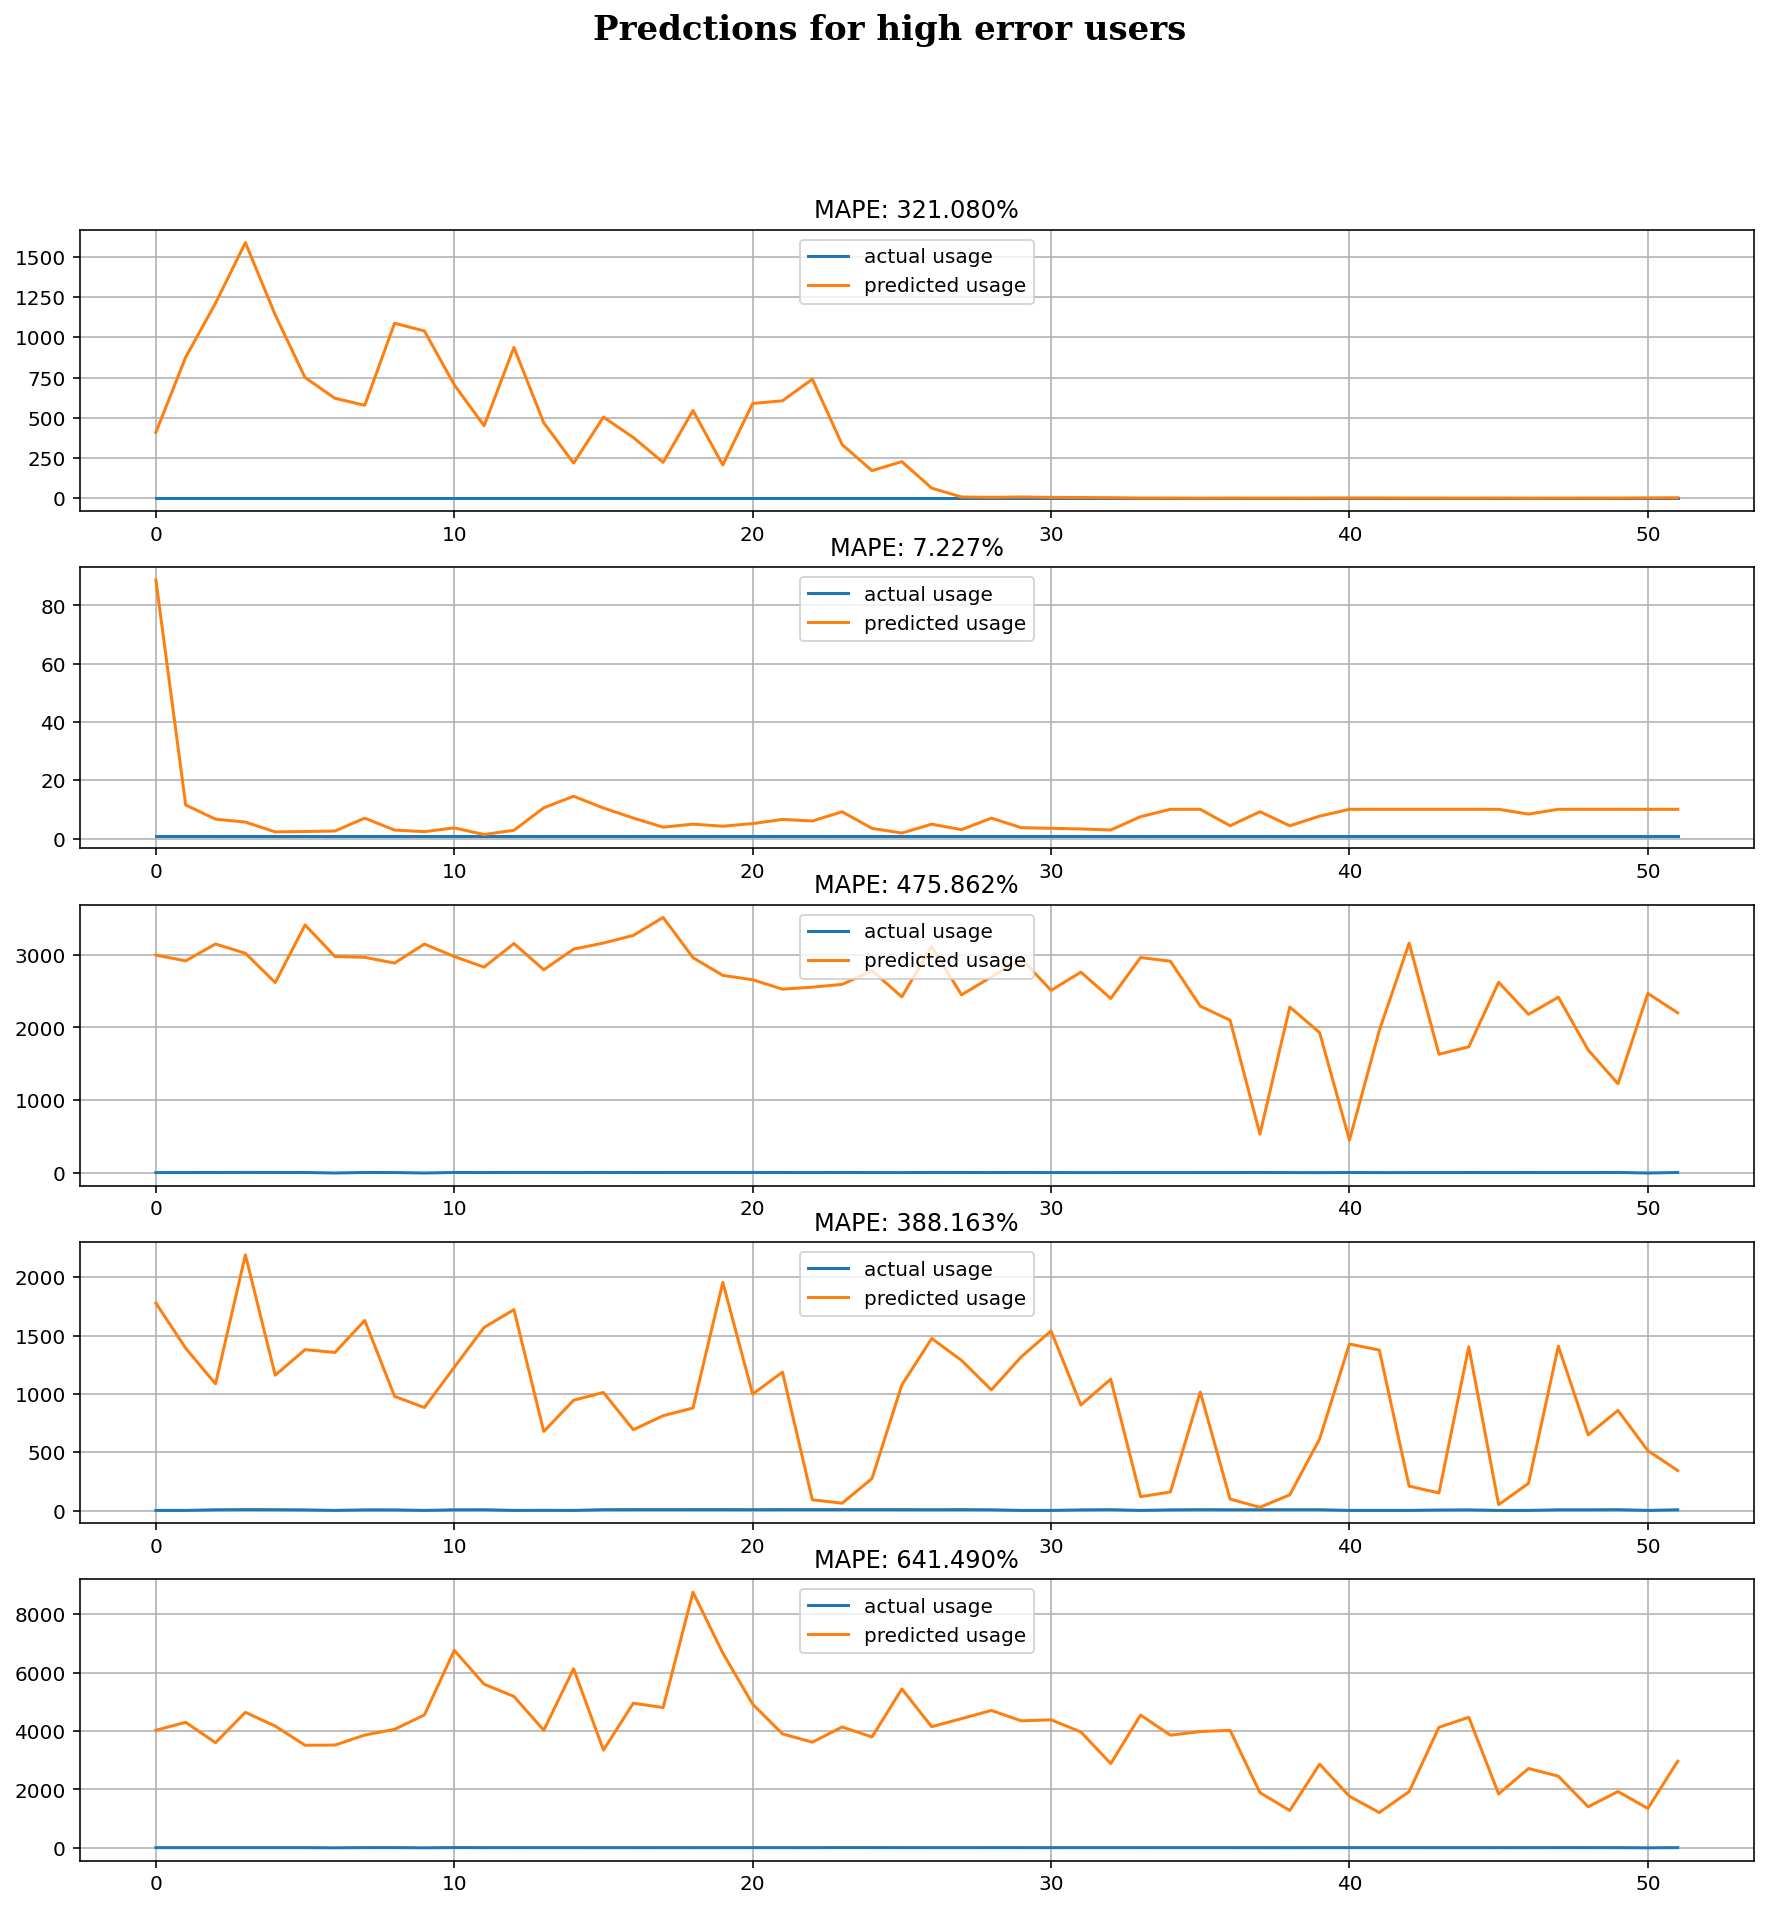

In [ ]:
fig,ax= plt.subplots(5,1,figsize=(15,15))

for i,user in enumerate(predictions_high):

  if i==5:break

  actual = predictions_high[user]['actual']
  predicted = predictions_high[user]['predicted']
  mape_ = MAPE(actual,predicted)
  ax[i].plot(actual,label='actual usage')
  ax[i].plot(predicted,label='predicted usage')
  ax[i].legend(loc='upper center')
  ax[i].set_title(f"MAPE: {mape_:.3f}%")
  ax[i].grid(True)

fig.suptitle('Predctions for high error users',fontfamily='serif',fontsize='17',fontweight='semibold')
# plt.tight_layout()
plt.show()

### (ii) Box-cox

In [ ]:
df_box = df_copy.copy()
df_box.usage,lambda_value = box_cox_transformation(df_box.usage)
df_box.head()

msisdn     usage
2020-06-01    2860  0.000000
2020-06-01    5126  0.000000
2020-06-01    9047  0.000000
2020-06-01    9900  6.316594
2020-06-01    2406  0.000000

In [ ]:
df_box.usage = df_box.usage + 1
df_box.head()

msisdn     usage
2020-06-01    2860  1.000000
2020-06-01    5126  1.000000
2020-06-01    9047  1.000000
2020-06-01    9900  7.316594
2020-06-01    2406  1.000000

In [ ]:
def train_bulk(df,users,error='mape',log_usage=False,lambda_value=lambda_value):
  errors= []
  unusual_behaviours = {}
  result = {msisdn:
            {"actual":[],
             "predicted":[]
             } for msisdn in users}
  for uid in tqdm(users):
    data = df.query("msisdn==@uid")['usage']
    xtrain,xtest,ytrain,ytest = prepareData(data,lag_start=30,lag_end=60,test_size=0.1)
    xtrain_scaled,xtest_scaled = get_scaled_data(xtrain,xtest)

    xgb = XGBRegressor(verbosity=1,objective ='reg:squarederror')
    xgb.fit(xtrain_scaled, ytrain)

    predictions = xgb.predict(xtest_scaled).tolist()
    if log_usage:predictions = [box_cox_inverse_transformation(x,lambda_value=lambda_value) for x in predictions]

    ytest = ytest.values.tolist()
    if log_usage:[box_cox_inverse_transformation(x,lambda_value=lambda_value) for x in ytest]

    result[uid]['actual'].extend(ytest)
    result[uid]['predicted'].extend(predictions)
    # if error=='mape':
    error = MAPE(result[uid]['actual'],result[uid]['predicted'])
    # elif error=='mae':
    # error = MAE(result[uid]['actual'],result[uid]['predicted'])
    errors.append(error)
    # print(error)
  return result,errors

In [ ]:
predictions_medium,errors_medium = train_bulk(df_log,users_01,log_usage=True)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
predictions_high,errors_high = train_bulk(df_log,users_02,log_usage=True)

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
np.mean(errors_high),np.mean(errors_medium)

(49.465693223881985, 25.358623527612856)

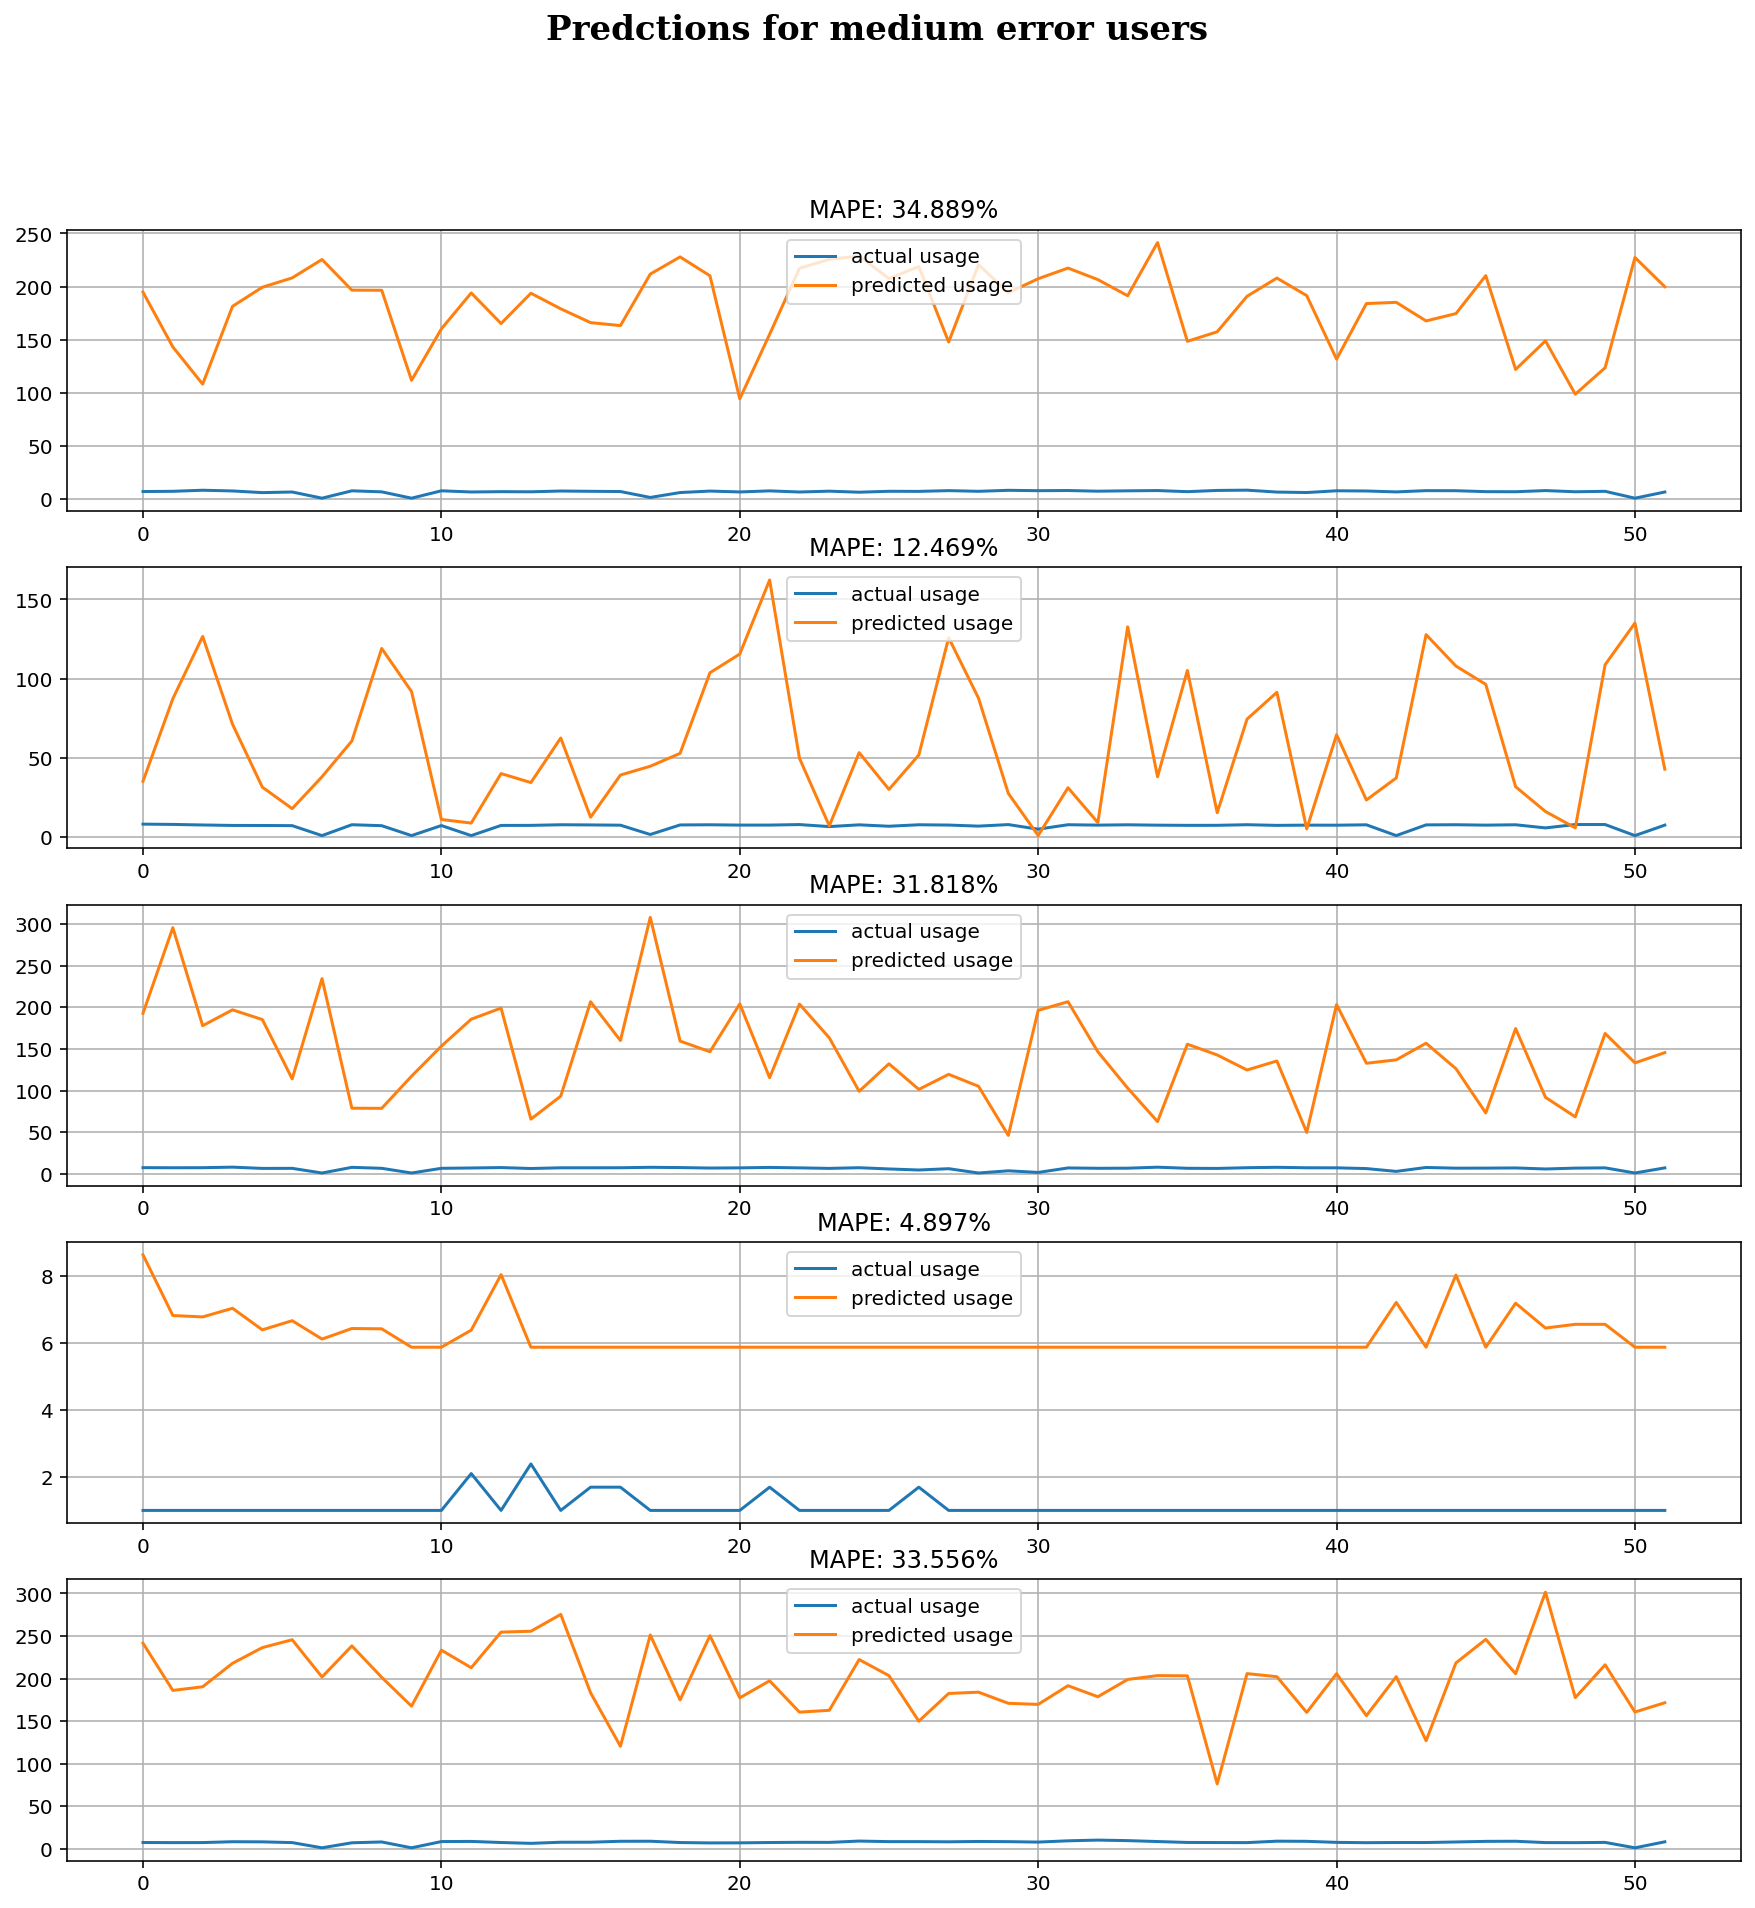

In [ ]:
fig,ax= plt.subplots(5,1,figsize=(15,15))

for i,user in enumerate(predictions_medium):

  if i==5:break

  actual = predictions_medium[user]['actual']
  predicted = predictions_medium[user]['predicted']
  mape_ = MAPE(actual,predicted)
  ax[i].plot(actual,label='actual usage')
  ax[i].plot(predicted,label='predicted usage')
  ax[i].legend(loc='upper center')
  ax[i].set_title(f"MAPE: {mape_:.3f}%")
  ax[i].grid(True)

fig.suptitle('Predctions for medium error users',fontfamily='serif',fontsize='17',fontweight='semibold')
# plt.tight_layout()
plt.show()

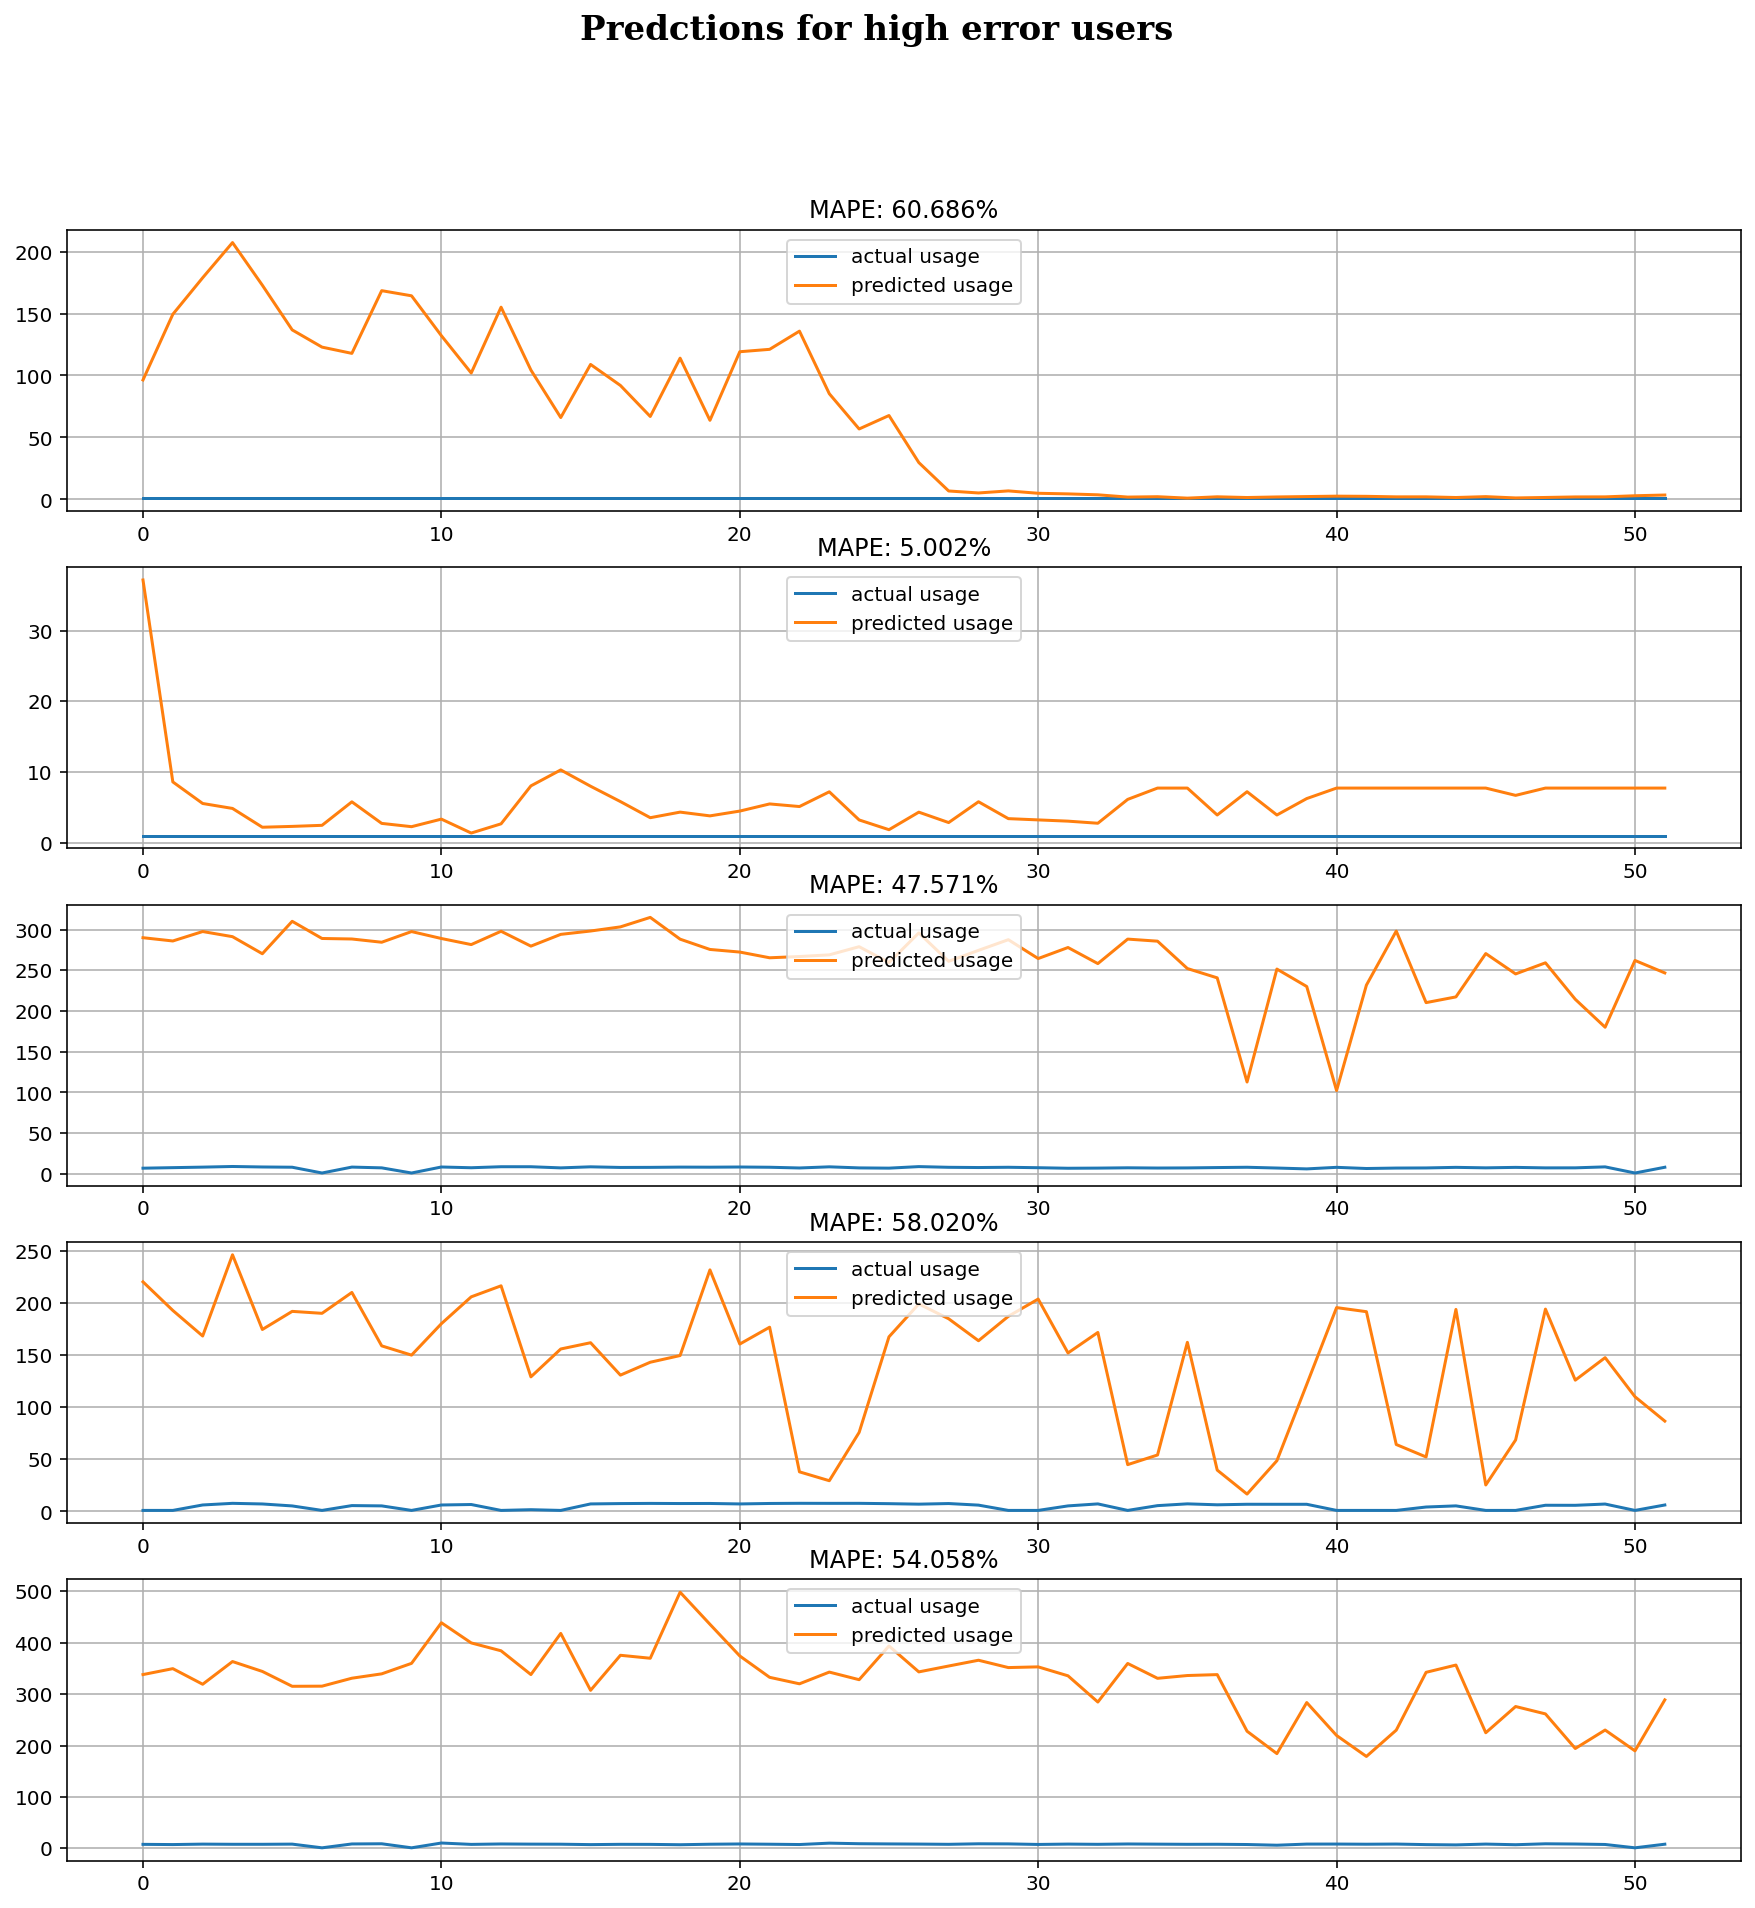

In [ ]:
fig,ax= plt.subplots(5,1,figsize=(15,15))

for i,user in enumerate(predictions_high):

  if i==5:break

  actual = predictions_high[user]['actual']
  predicted = predictions_high[user]['predicted']
  mape_ = MAPE(actual,predicted)
  ax[i].plot(actual,label='actual usage')
  ax[i].plot(predicted,label='predicted usage')
  ax[i].legend(loc='upper center')
  ax[i].set_title(f"MAPE: {mape_:.3f}%")
  ax[i].grid(True)

fig.suptitle('Predctions for high error users',fontfamily='serif',fontsize='17',fontweight='semibold')
# plt.tight_layout()
plt.show()